# Data Preprocessing
#### Run this script to proprocess all the data that will be coming in from one, many, or all of the following sources:
1. **MonkeyLogic:** (.bhv2 | .h5) behavior data *[500 or 1000Hz]*
  > * Photodiode data
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
2. **SpikeGLX:** (.meta & .bin) duplicates of analog data *[20000-30000Hz]*
  > * Photodiode data (split from ML)
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
3. **WhiteMatter:** (.mp4 | .avi) video files *[60-120 fps]*
***

## Find Files
`FileContainer` will hold the relevant files listed above. <br>
* Specify `ROOT_DIR` to set the directory when prompted to select the files.
* `WARNING` printed if dates and monkeys not aligned across files

In [4]:
%load_ext autoreload
%autoreload 2
import re
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
# Custom classes
from classes.FileContainer import FileContainer
from classes.SpikeGLX import SpikeGLX
# Custom functions
from spike_glx import read_SGLX

# pandas options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

ROOT_DIR = '/Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/tasks'
file_container_obj = FileContainer(ROOT_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Select .bhv2/.h5 behavior file (i.e. 230927_Aragorn_choice.h5)
Behavior file selected: G:/.shortcut-targets-by-id/1iwYyt135rRNSZX7kvXzZZh7UDwRKFPfa/data_Probabilistic_Reward_Airpuff_Generalization/231212_Aragorn_generalization.h5
  MonkeyLogic Date: 231212
  MonkeyLogic Monkey: aragorn
Select directory containing White Matter video files (i.e. 230927_Aragorn)
Video files directory selected: C:/Users/rober/Desktop/rhAirpuff/videos/231212_Aragorn
  White Matter Video Date: 231212
  White Matter Video Monkey: aragorn
Select directory containing SpikeGLX files
SpikeGLX files directory selected: C:/Users/rober/SynologyDrive/Rahim/aragorn_20231212/aragorn_20231212_g1
  SpikeGLX Date: 231212
  SpikeGLX Monkey: aragorn



***
## Convert MonkeyLogic File to Pandas
In order to run the behavior files through the preprocessing pipeline, we'll need to convert the MonkeyLogic file (either `.bhv2` or `.h5`) into a Session object which contains the following relevant attributes:
> * `session_obj.df`: pandas DataFrame with columns:
>   * `'photodiode'`: photodiode signal
>   * `'Gen2'`: WM sync signal
>   * `'Gen3'`: WM save signal
> * `'session_obj.video_path'`: directory of WM videos
> * `session_obj.monkey`: monkey name
> * `session_obj.date`: date of session (<YYMMDD>)

In [5]:
session_obj, error_dict, behavioral_code_dict = file_container_obj.ml_to_pd()

Parsing .h5 file...
Total number of trials: 608
  Choice task detected.
Parsing session data...


  0%|          | 0/608 [00:00<?, ?it/s]

  Complete.
    Correct trials: 350
    Errored trials: 258
    Session Length:  01:59:13
Creating Session Objects...
Lick threshold: 3.77 mV
  Min Values (X,Y): (-28.011,-31.582)
  Max Values (X,Y): (109.482,130.101)
  Reward Mag: 1.0
    Reward Drops: 12.0
    Reward Frequency: 1.0
    Reward Length: 220.0
  Reward Mag: 0.5
    Reward Drops: 4.0
    Reward Frequency: 1.0
    Reward Length: 200.0
  Reward Mag: 0.0
    Reward Drops: 0.0
    Reward Frequency: 0.0
    Reward Length: 0.0
  Airpuff Mag: 1.0
    Airpuff Magnitude: 1.0
    Airpuff Frequency: 1.0
  Airpuff Mag: 0.5
    Airpuff Magnitude: 0.5
    Airpuff Frequency: 1.0
  Airpuff Mag: 0.0
    Airpuff Magnitude: 0.0
    Airpuff Frequency: 0.0
Adding additional fields to session_df DataFrame...


c:\Users\rober\Desktop\Monkey-Emotions\config\add_fields.py:335: RuntimeWarning: Mean of empty slice
  lick_avg = np.nanmean(lick_in_window)


  ['cam_frames'] field added.
  20 new fields added.
	0 rows removed due to nan valence.


In [8]:
from config.add_fields import add_fields
# save is lick
# lick is photodiode
# photodiode is save
if session_obj.monkey == 'gandalf':
  session_obj.df['cam_save_2'] = session_obj.df['cam_save'].copy()
  session_obj.df['cam_sync_2'] = session_obj.df['cam_sync'].copy()
  session_obj.df['cam_sync'] = session_obj.df['lick'].copy() # correct
  session_obj.df['cam_save'] = session_obj.df['cam_sync_2'].copy()
  session_obj.df['lick'] = session_obj.df['cam_save_2'].copy()
  del session_obj.df['cam_sync_2']
  del session_obj.df['cam_save_2']

  session_obj.df, session_obj = \
  add_fields(session_obj.df, session_obj, behavioral_code_dict)

Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...
   No blink window column found, skipping blink window...
   No pupil column found, skipping pupil pre-CS...
   No lick window column found, skipping lick window...
   No blink window column found, skipping blink window...
   No lick duration column found, skipping lick duration...
   No blink duration column found, skipping blink duration...
   No blink duration column found, skipping blink duration...
   No eye distance column found, skipping eye distance...
  ['cam_frames'] field added.
  20 new fields added.
   No behavioral analysis performed...
   No novel fractal column found, skipping novel fractal...
   No fractal column found, skipping fractal count...


In [6]:
session_obj.df.head()

date  session_num  subject  trial_num  block  condition  correct  error  \
0  231212            0  aragorn          1      1          1        1      0   
1  231212            0  aragorn          2      1          1        1      0   
2  231212            0  aragorn          3      1          1        0      1   
3  231212            0  aragorn          4      1          1        0      1   
4  231212            0  aragorn          5      1          1        0      1   

   error_type                            behavioral_code_markers  \
0           0  [9, 100, 101, 102, 103, 104, 105, 106, 107, 11...   
1           0  [9, 100, 101, 102, 103, 104, 105, 106, 107, 11...   
2           4              [9, 100, 101, 102, 103, 104, 113, 18]   
3           4              [9, 100, 101, 102, 103, 104, 113, 18]   
4           4              [9, 100, 101, 102, 103, 104, 113, 18]   

                               behavioral_code_times stimuli_name_0 x_0_pos  \
0  [4.814800005988218, 2862.4538000003668, 2939.7...           _fix   [0.0]   
1  [1464.8955000011483, 1587.390900007449, 1620.4...           _fix   [0.0]   
2  [1498.7583000038285, 1600.7229999959236, 1633....           _fix   [0.0]   
3  [1499.4447000062792, 1591.7214000073727, 1625....           _fix   [0.0]   
4  [1500.5889000021853, 1611.819400000968, 1644.8...           _fix   [0.0]   

  y_0_pos stimuli_name_1 x_1_pos y_1_pos stimuli_name_2 x_2_pos y_2_pos  \
0   [0.0]     _fractal_B   [0.0]   [0.0]     _fractal_B   [0.0]   [0.0]   
1   [0.0]     _fractal_D   [0.0]   [0.0]     _fractal_D   [0.0]   [0.0]   
2   [0.0]     _fractal_A   [0.0]   [0.0]     _fractal_A   [0.0]   [0.0]   
3   [0.0]     _fractal_D   [0.0]   [0.0]     _fractal_D   [0.0]   [0.0]   
4   [0.0]     _fractal_C   [0.0]   [0.0]     _fractal_C   [0.0]   [0.0]   

   reward_1  reward_prob_1  reward_mag_1  reward_drops_1  reward_length_1  \
0         0            0.0           0.0             0.0              0.0   
1         0            0.0           0.0             0.0              0.0   
2         0            0.0           0.0             0.0              0.0   
3         0            0.0           0.0             0.0              0.0   
4         0            0.0           0.0             0.0              0.0   

   reward_2  reward_prob_2  reward_mag_2  airpuff_1  airpuff_prob_1  \
0         0            0.0           0.0          0             0.0   
1         0            0.0           0.0          0             0.0   
2         0            0.0           0.0          0             0.0   
3         0            0.0           0.0          0             0.0   
4         0            0.0           0.0          0             0.0   

   airpuff_mag_1  airpuff_2  airpuff_prob_2  airpuff_mag_2  \
0            0.0          0             0.0            0.0   
1            0.0          0             0.0            0.0   
2            0.0          0             0.0            0.0   
3            0.0          0             0.0            0.0   
4            0.0          0             0.0            0.0   

                                               eye_x  \
0  [-19.185954376356676, -19.185954376356676, -19...   
1  [109.48164008498311, 109.48164008498311, 109.4...   
2  [-1.9205451347796556, -1.9330166168518232, -1....   
3  [22.140937436917294, 22.140937436917294, 22.14...   
4  [-10.213688292771982, -10.213688292771982, -10...   

                                               eye_y  \
0  [-24.548548930891815, -24.548548930891815, -24...   
1  [130.10102043570407, 130.10102043570407, 130.1...   
2  [-5.171249027928454, -5.170768647387971, -5.17...   
3  [-6.588136235382706, -6.588136235382706, -6.58...   
4  [-21.111890031092162, -21.111890031092162, -21...   

                                           eye_pupil  \
0  [6959.0, 6959.0, 6959.0, 6959.0, 6959.0, 6924....   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [6780.0, 6780.0, 6780.0, 6780.0, 6780.0, 6790....   
3  [6795.0, 6795.0, 6753.0, 

In [70]:
import pickle
from config.h5_helper import pickler

pickler(True, os.path.dirname(file_container_obj.ml_file_path), 
        session_obj.df, 'gandalf', 'UnityVR', error_dict, behavioral_code_dict)

Saving .pickle files to: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff
  Pickling 231004_gandalf_UnityVR_behave.pkl
  Total time to pickle: 0.5141 sec


*** 
## Process SpikeGLX

Assign `signal_dict` channels manually based on how you set up the PXI board. `epochs` are the MonkeyLogic eventcodes within `session_obj.df` distinguishing epochs in the task that you will reference later to break up videos based on.

In [7]:
# Manually assign the signal channel numbers
# from how you set them up on the NI PXIe-6341 board
signal_dict = {
  0: 'cam_sync',
  1: 'cam_save',
  2: 'lick',
  3: 'photodiode',
}

# Manually assign the time epochs you care about
# which have to exist as rows in session_df
if session_obj.monkey in ['aragorn', 'bear']:
  epochs = ['Start Trial', 'Fixation On', 'CS On',	
          'Trace Start', 'Outcome Start', 'End Trial']
else:
  epochs = ['Start trial', 'End trial']
print('Epochs:')
# Print each epoch on its own line
for epoch in epochs:
  print(f'  {epoch}')

Epochs:
  Start Trial
  Fixation On
  CS On
  Trace Start
  Outcome Start
  End Trial


### Peek at SpikeGLX Analog Data
Always view the data you are working with before doing any type of analysis. Calling `read_SGLX` prompts a file selection tool (choose the .bin file that **must have the .meta file in the same directory as is the default for SpikeGLX output**), and `plot_channels_raw` allows for visualization of a window specified by [tStart - tEnd] **seconds**. 

Reading SGLX meta and bin files...
Select binary file
Bin File Path: C:\Users\rober\SynologyDrive\Rahim\aragorn_20231212\aragorn_20231212_g1\aragorn_20231212_g1_t0.nidq.bin
File Name: D://aragorn_2023112_g1/aragorn_2023112_g1_t0.nidq.bin
  Number of Channels: 9
  File Created: 2023-12-12T12:52:07
  File Length: 7168.9690151920695
nChan: 9, nFileSamp: 14337914
 Complete.
Plotting channels...
  SpikeGLX object missing attributes (meta, chan_dict, signal_dict)
  Using input arguments instead.
Sample Rate:  1999.996648
 Channel [0]: cam_sync
  Max Val: 3342.896
  Min Val: -5.493
 Channel [1]: cam_save
  Max Val: 3357.849
  Min Val: -10.986
 Channel [2]: lick
  Max Val: 5007.019
  Min Val: -22.583
 Channel [3]: photodiode
  Max Val: 2286.072
  Min Val: 536.194
 Channel [4]: empty
 Channel [5]: empty
 Channel [6]: empty
 Channel [7]: empty
 Channel [8]: empty


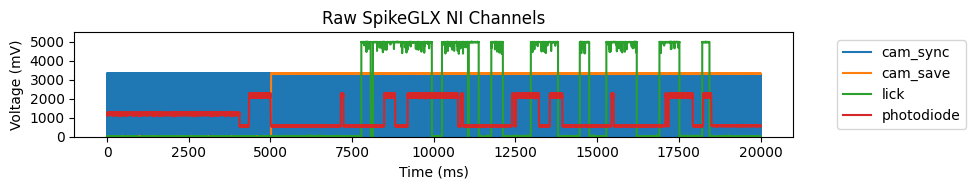

In [8]:
from spike_glx.read_SGLX import read_SGLX, plot_channels_raw

print('Reading SGLX meta and bin files...')
meta, chan_dict = read_SGLX()
print(' Complete.')
print('Plotting channels...')
plot_channels_raw(None, meta, chan_dict, signal_dict, tStart=0, tEnd=20)

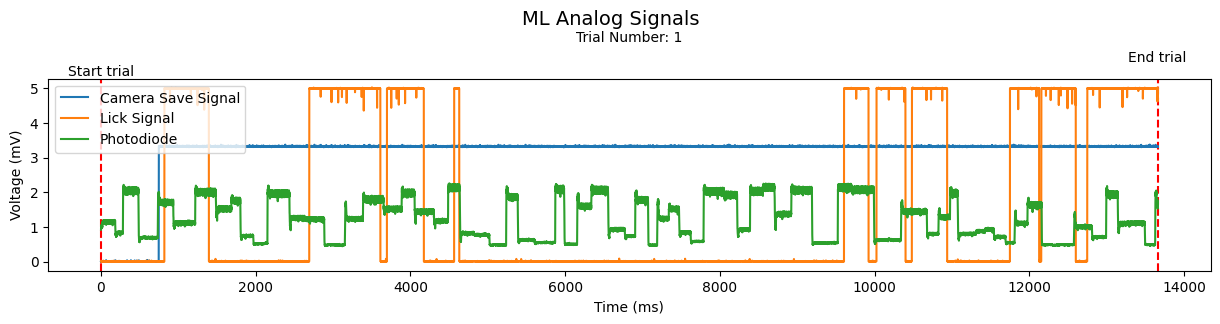

In [12]:
from spike_glx.read_SGLX import plot_analog_ML
# epochs = ['Start Trial', 'Fixation On', 'CS On',	
#           'Trace Start', 'Outcome Start', 'End Trial']
plot_analog_ML(session_obj.df, epochs, trial_num=1)

Pickled spikeglx_obj not found for: aragorn_231212
Generating new spikeglx_obj...
  Looking for SpikeGLX binary and meta file in:
  C:/Users/rober/SynologyDrive/Rahim/aragorn_20231212
Looking for binary file in C:/Users/rober/SynologyDrive/Rahim/aragorn_20231212
Found folder: aragorn_20231212_g1
  Found binary file: aragorn_20231212_g1_t0.nidq.bin
  Found metadata file: aragorn_20231212_g1_t0.nidq.meta
File Name: D://aragorn_2023112_g1/aragorn_2023112_g1_t0.nidq.bin
  Number of Channels: 9
  File Created: 2023-12-12T12:52:07
  File Length: 7168.9690151920695
nChan: 9, nFileSamp: 14337914
Number of Channels:  9
Sample Rate:  1999.996648
Number of frames in SpikeGLX Cam TTL: 858144


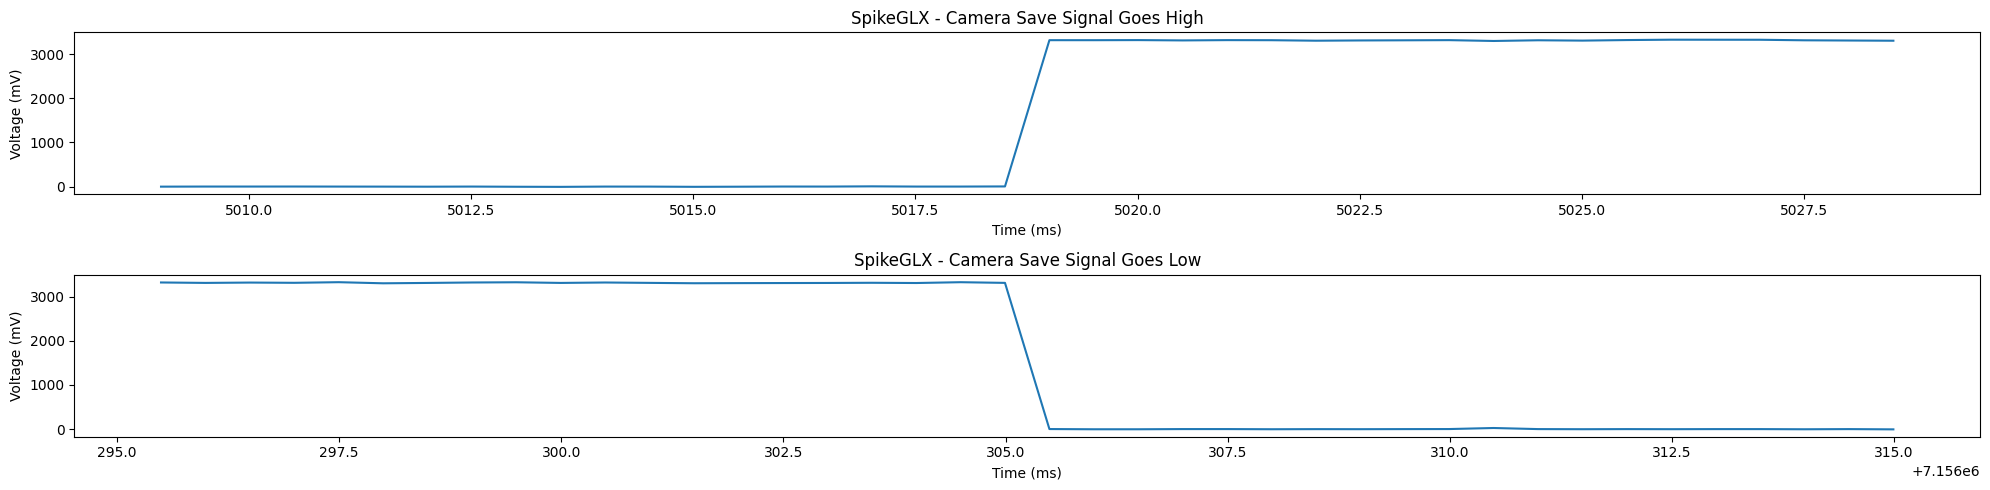

Video Folders:
['231212_Aragorn_125212', '231212_Aragorn_125407', '231212_Aragorn_131113']
Number of cameras: 5
  Camera: e3v831b | Number of videos: 6
  Camera: e3v8360 | Number of videos: 6
  Camera: e3v83ad | Number of videos: 6
  Camera: e3v83c5 | Number of videos: 6
  Camera: e3v83d6 | Number of videos: 6
Camera: e3v831b
  Video: e3v831b-20231212T125210-131211.avi | Frames: 72054  | FPS: 120.0 | Length (minutes): 10.01  
  Video: e3v831b-20231212T131211-133212.avi | Frames: 72057  | FPS: 120.0 | Length (minutes): 10.01  
  Video: e3v831b-20231212T133212-135213.avi | Frames: 72057  | FPS: 120.0 | Length (minutes): 10.01  
  Video: e3v831b-20231212T135213-141213.avi | Frames: 72000  | FPS: 120.0 | Length (minutes): 10.0   
  Video: e3v831b-20231212T141213-143214.avi | Frames: 72057  | FPS: 120.0 | Length (minutes): 10.01  
  Video: e3v831b-20231212T143214-145121.avi | Frames: 68815  | FPS: 120.0 | Length (minutes): 9.56   
  Total Frames: 429040
Camera: e3v8360
  Video: e3v8360-2023

Trial Number:   0%|          | 0/607 [00:00<?, ?it/s]

Trial 1 | Correlation: 0.997 | SGLX High Time: 10038 | ML High Time: 765
  Trial 1 | Epoch start 4254.008411858098 | Epoch end 10841.008411858098
Trial 2 | Correlation: 0.997 | SGLX High Time: 2702 | ML High Time: 1551
  Trial 2 | Epoch start 10840.520768188808 | Epoch end 15502.520768188808
Trial 3 | Correlation: 0.997 | SGLX High Time: 2771 | ML High Time: 1585
  Trial 3 | Epoch start 15502.528638697997 | Epoch end 19942.528638697997
Trial 4 | Correlation: 0.996 | SGLX High Time: 2749 | ML High Time: 1574
  Trial 4 | Epoch start 19942.53606171444 | Epoch end 24260.53606171444
Trial 5 | Correlation: 0.992 | SGLX High Time: 2751 | ML High Time: 1575
  Trial 5 | Epoch start 24260.54330037057 | Epoch end 40418.54330037057
  Trial 6 | Epoch start 40418.57034267589 | Epoch end 93381.5703426759


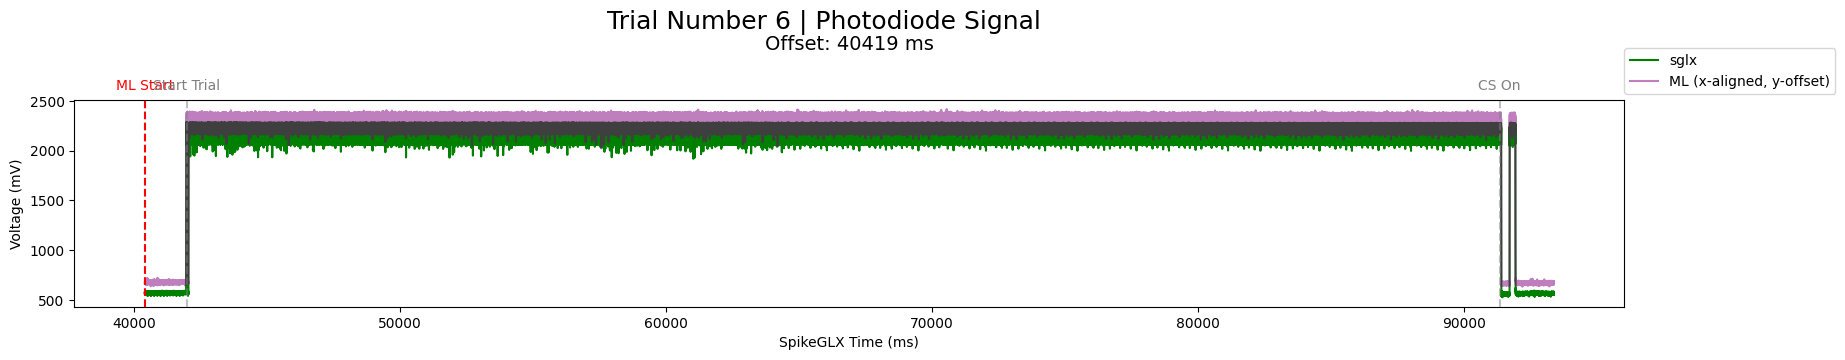

Trial 6:
  ML Cam Start           |  7      
  ML Cam End             |  52957  
  ML Cam Num Frames      |  6355   
  --------------------------------------
  SpikeGLX Trial Start   |  40418.57
  SpikeGLX Trial End     |  93381.57
  SpikeGLX Num Frames    |  6355   
  ML-SGLX Correlation: 0.973
Trial 7 | Correlation: 0.996 | SGLX High Time: 2711 | ML High Time: 1554
  Trial 7 | Epoch start 93382.65911384067 | Epoch end 103823.65911384067
Trial 8 | Correlation: 0.998 | SGLX High Time: 2710 | ML High Time: 1555
  Trial 8 | Epoch start 103823.176613824 | Epoch end 108529.176613824
Trial 9 | Correlation: 0.995 | SGLX High Time: 2751 | ML High Time: 1575
  Trial 9 | Epoch start 108529.18453461328 | Epoch end 113215.18453461328
Trial 10 | Correlation: 0.996 | SGLX High Time: 2711 | ML High Time: 1554
  Trial 10 | Epoch start 113216.19235484238 | Epoch end 117838.19235484238
Trial 11 | Correlation: 0.996 | SGLX High Time: 2709 | ML High Time: 1555
  Trial 11 | Epoch start 117837.20010132737 

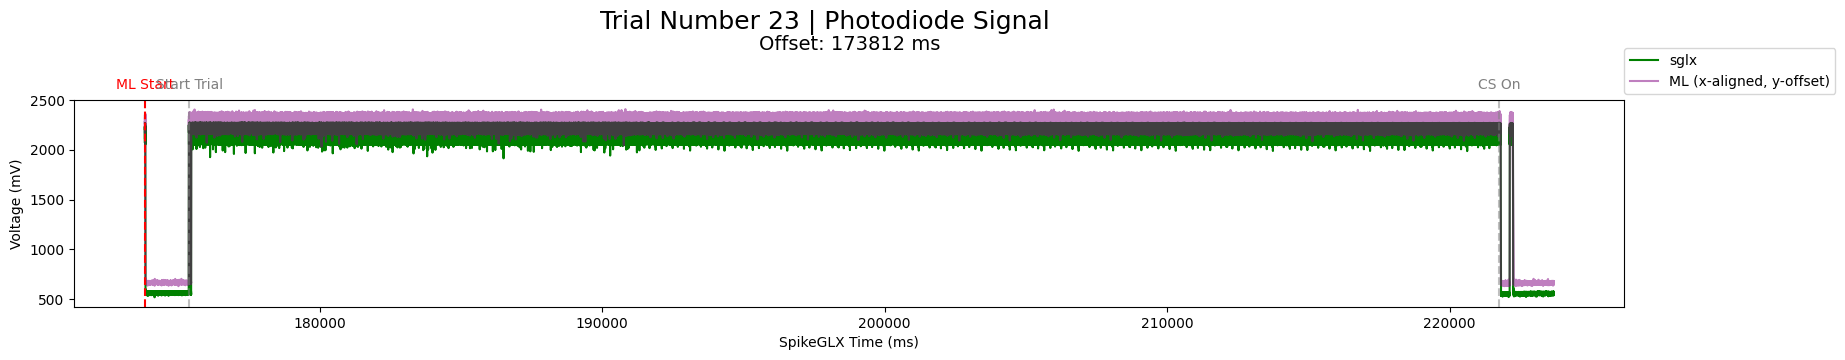

Trial 23:
  ML Cam Start           |  7      
  ML Cam End             |  49874  
  ML Cam Num Frames      |  5985   
  --------------------------------------
  SpikeGLX Trial Start   |  173811.79
  SpikeGLX Trial End     |  223691.79
  SpikeGLX Num Frames    |  5985   
  ML-SGLX Correlation: 0.974
Trial 24 | Correlation: 0.998 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 24 | Epoch start 223692.3775129287 | Epoch end 228309.3775129287
Trial 25 | Correlation: 0.996 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 25 | Epoch start 228309.38525103367 | Epoch end 232740.38525103367
Trial 26 | Correlation: 0.999 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 26 | Epoch start 232740.39267740212 | Epoch end 237362.39267740212
Trial 27 | Correlation: 0.993 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 27 | Epoch start 237361.9004230491 | Epoch end 247095.9004230491
Trial 28 | Correlation: 0.997 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 28 | Epoch start 247096.41

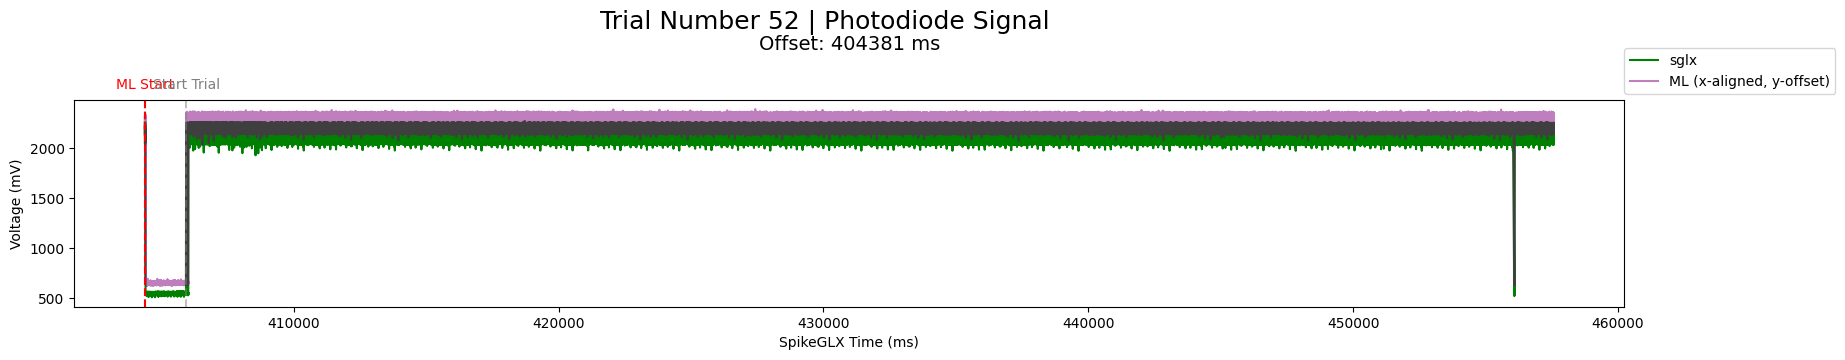

Trial 52:
  ML Cam Start           |  7      
  ML Cam End             |  53199  
  ML Cam Num Frames      |  6384   
  --------------------------------------
  SpikeGLX Trial Start   |  404380.68
  SpikeGLX Trial End     |  457584.68
  SpikeGLX Num Frames    |  6384   
  ML-SGLX Correlation: 0.947
Trial 53 | Correlation: 0.994 | SGLX High Time: 2675 | ML High Time: 1536
  Trial 53 | Epoch start 457585.76948808564 | Epoch end 465481.76948808564
Trial 54 | Correlation: 0.991 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 54 | Epoch start 465481.2827511339 | Epoch end 475059.2827511339
Trial 55 | Correlation: 0.997 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 55 | Epoch start 475059.7988047268 | Epoch end 482849.7988047268
Trial 56 | Correlation: 0.994 | SGLX High Time: 5508 | ML High Time: 2953
  Trial 56 | Epoch start 482850.3142063546 | Epoch end 491741.3142063546
Trial 57 | Correlation: 0.995 | SGLX High Time: 2673 | ML High Time: 1537
  Trial 57 | Epoch start 491740.3267

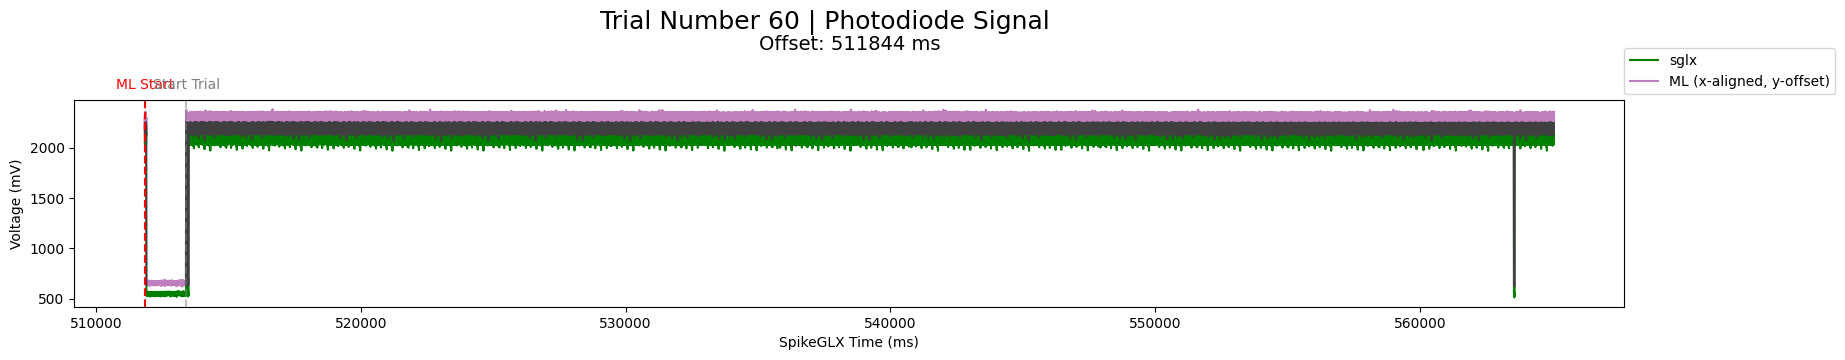

Trial 60:
  ML Cam Start           |  3      
  ML Cam End             |  53204  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  511844.36
  SpikeGLX Trial End     |  565054.36
  SpikeGLX Num Frames    |  6385   
  ML-SGLX Correlation: 0.944
  Trial 61 | Epoch start 565054.4496072695 | Epoch end 618221.4496072695


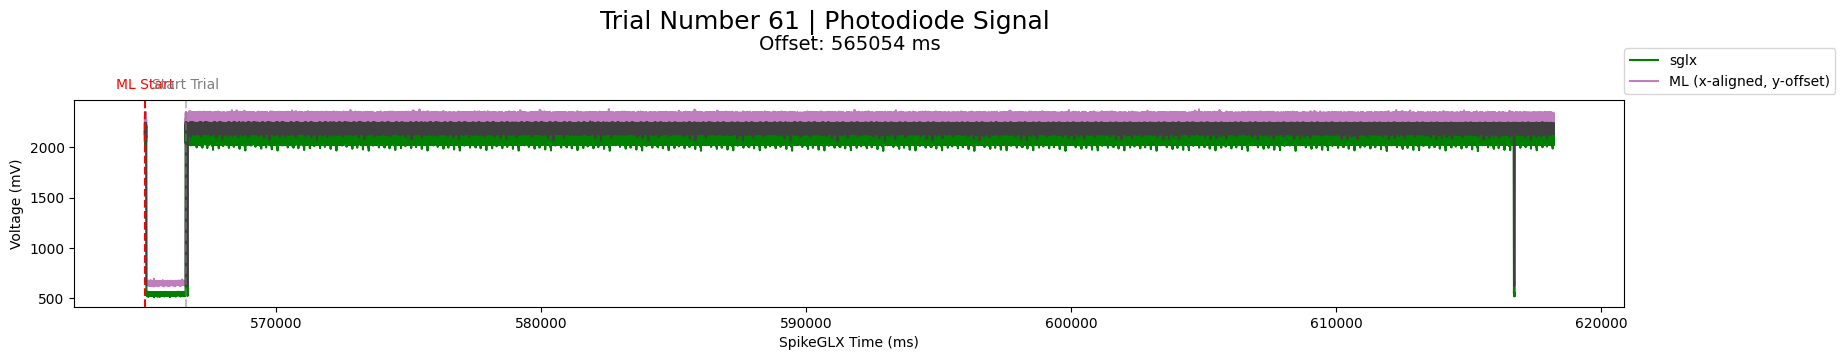

Trial 61:
  ML Cam Start           |  2      
  ML Cam End             |  53160  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  565054.45
  SpikeGLX Trial End     |  618221.45
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.942
Trial 62 | Correlation: 0.996 | SGLX High Time: 2676 | ML High Time: 1537
  Trial 62 | Epoch start 618222.0387161488 | Epoch end 622453.0387161488
Trial 63 | Correlation: 0.999 | SGLX High Time: 2712 | ML High Time: 1555
  Trial 63 | Epoch start 622453.5458383228 | Epoch end 626723.5458383228
Trial 64 | Correlation: 0.993 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 64 | Epoch start 626723.5529931788 | Epoch end 630286.5529931788
Trial 65 | Correlation: 0.998 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 65 | Epoch start 630286.0589639388 | Epoch end 633726.0589639388
Trial 66 | Correlation: 0.994 | SGLX High Time: 2674 | ML High Time: 1536
  Trial 66 | Epoch start 633726.564700

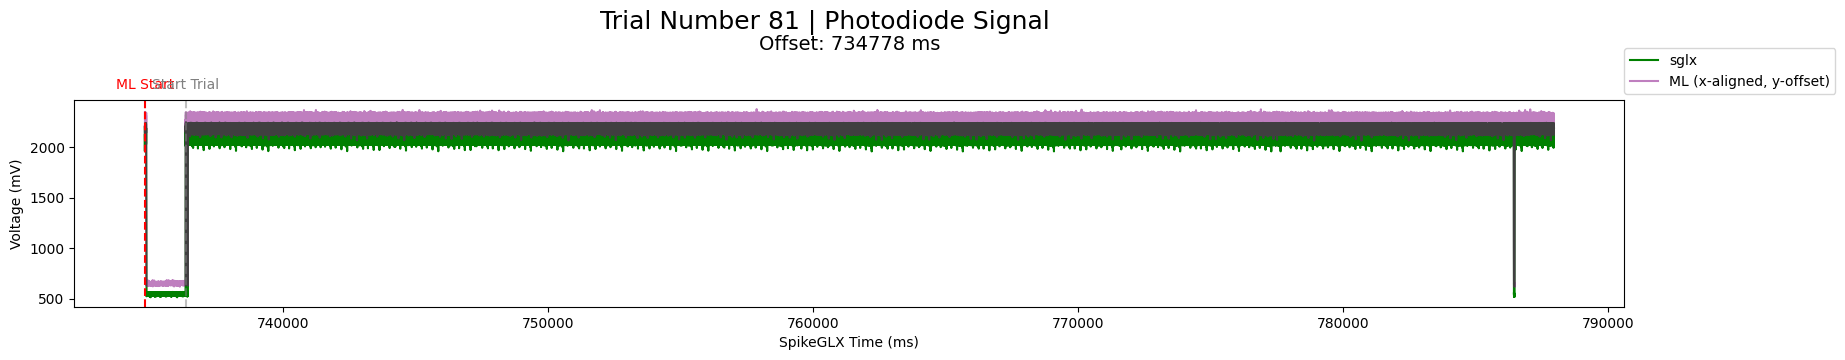

Trial 81:
  ML Cam Start           |  6      
  ML Cam End             |  53164  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  734777.73
  SpikeGLX Trial End     |  787943.73
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.945
Trial 82 | Correlation: 0.993 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 82 | Epoch start 787943.8231698596 | Epoch end 791482.8231698596
  Trial 83 | Epoch start 791483.8291297256 | Epoch end 844683.8291297256


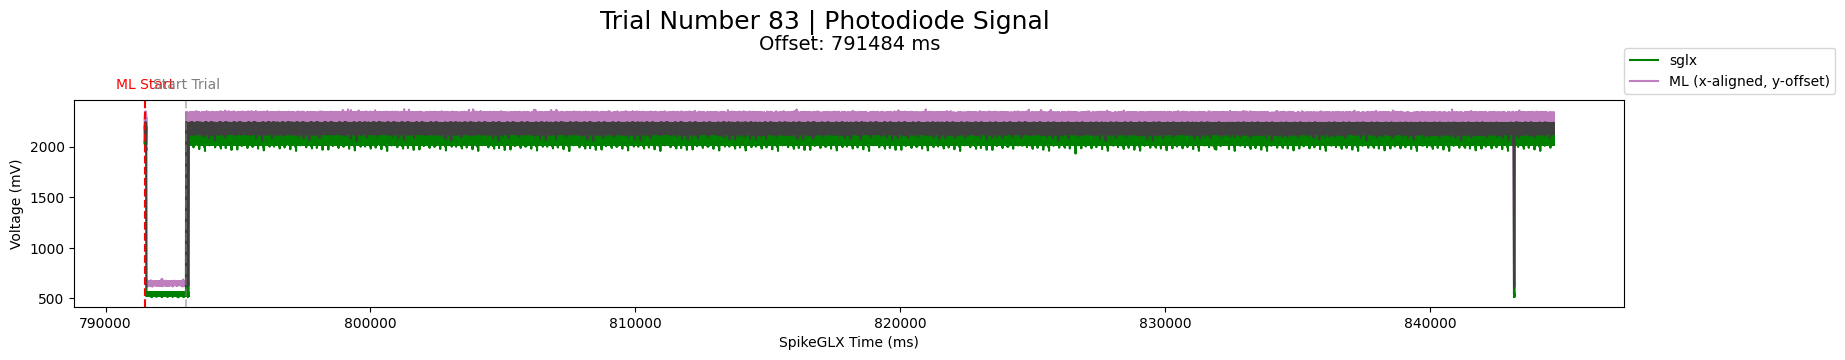

Trial 83:
  ML Cam Start           |  1      
  ML Cam End             |  53193  
  ML Cam Num Frames      |  6384   
  --------------------------------------
  SpikeGLX Trial Start   |  791483.83
  SpikeGLX Trial End     |  844683.83
  SpikeGLX Num Frames    |  6384   
  ML-SGLX Correlation: 0.945
Trial 84 | Correlation: 0.993 | SGLX High Time: 2707 | ML High Time: 1553
  Trial 84 | Epoch start 844683.918293075 | Epoch end 848672.918293075
Trial 85 | Correlation: 0.999 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 85 | Epoch start 848672.9249518343 | Epoch end 852261.9249518343
Trial 86 | Correlation: 0.993 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 86 | Epoch start 852261.9309670082 | Epoch end 855701.9309670082
Trial 87 | Correlation: 0.993 | SGLX High Time: 2674 | ML High Time: 1536
  Trial 87 | Epoch start 855702.43673162 | Epoch end 859107.43673162
Trial 88 | Correlation: 0.999 | SGLX High Time: 2674 | ML High Time: 1537
  Trial 88 | Epoch start 859106.9424392475 |

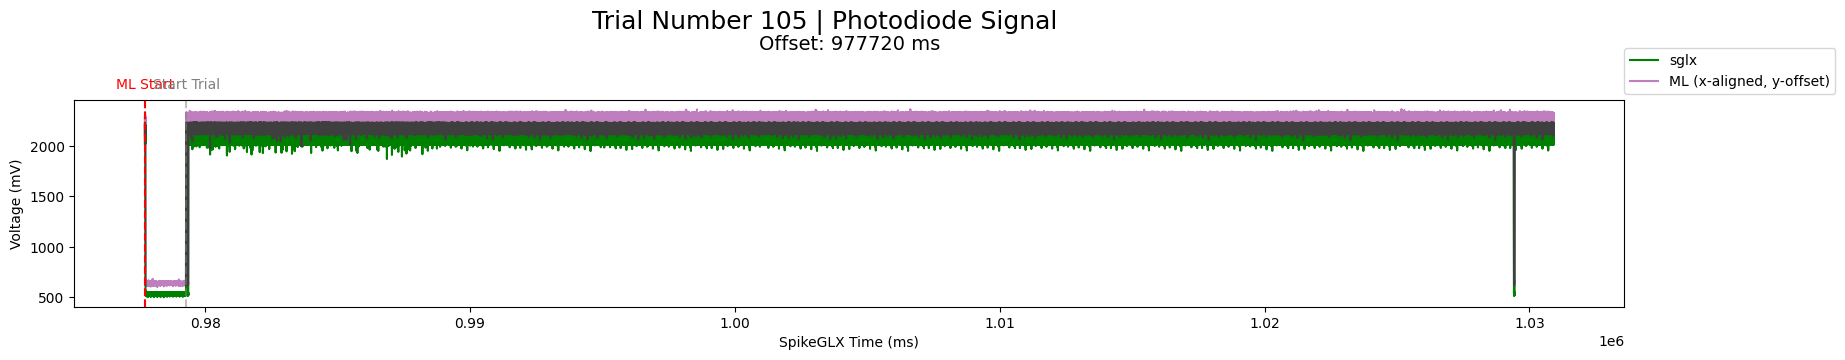

Trial 105:
  ML Cam Start           |  8      
  ML Cam End             |  53208  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  977720.14
  SpikeGLX Trial End     |  1030930.14
  SpikeGLX Num Frames    |  6385   
  ML-SGLX Correlation: 0.944
  Trial 106 | Epoch start 1030930.7304142402 | Epoch end 1084096.7304142402


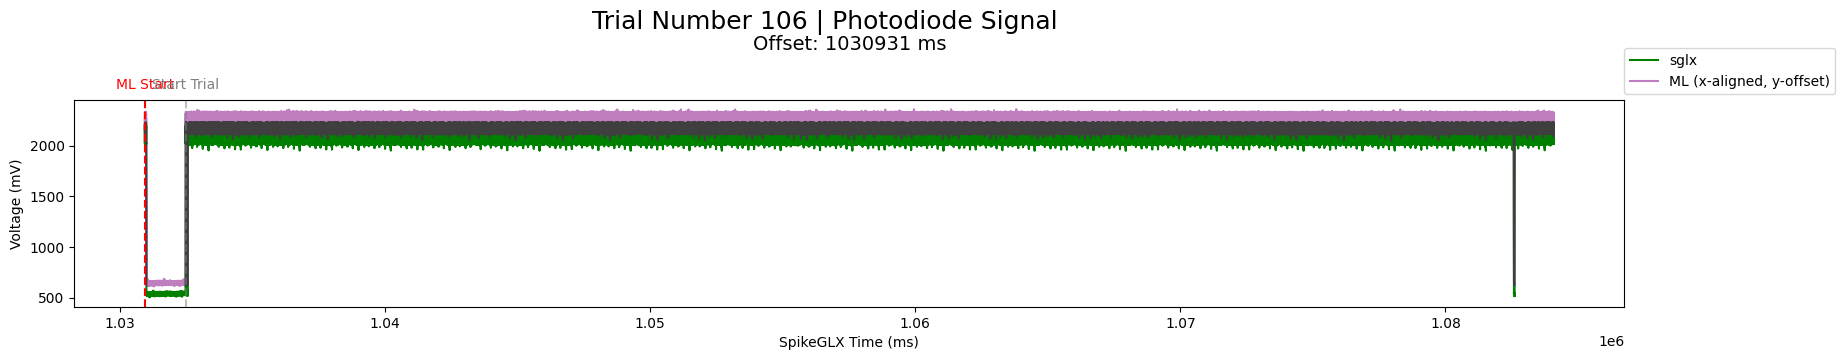

Trial 106:
  ML Cam Start           |  6      
  ML Cam End             |  53164  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  1030930.73
  SpikeGLX Trial End     |  1084096.73
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.943
  Trial 107 | Epoch start 1084098.3195231196 | Epoch end 1126165.3195231196


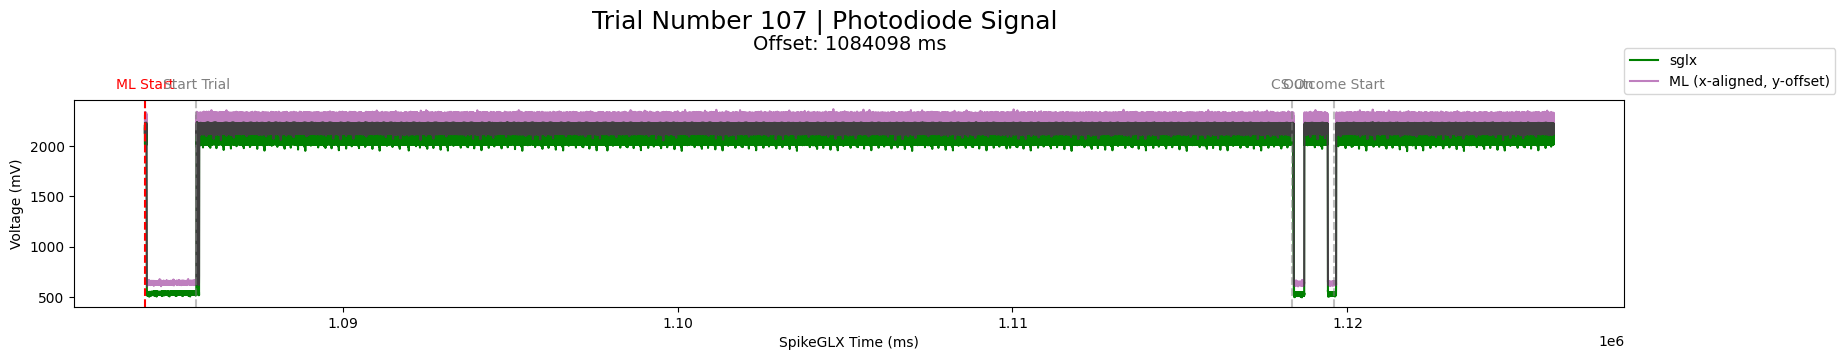

Trial 107:
  ML Cam Start           |  7      
  ML Cam End             |  42065  
  ML Cam Num Frames      |  5048   
  --------------------------------------
  SpikeGLX Trial Start   |  1084098.32
  SpikeGLX Trial End     |  1126165.32
  SpikeGLX Num Frames    |  5048   
  ML-SGLX Correlation: 0.966
Trial 108 | Correlation: 0.998 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 108 | Epoch start 1126165.3900576977 | Epoch end 1131540.3900576977
Trial 109 | Correlation: 0.996 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 109 | Epoch start 1131540.3990662128 | Epoch end 1137134.3990662128
Trial 110 | Correlation: 0.998 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 110 | Epoch start 1137134.4084417725 | Epoch end 1143802.4084417725
Trial 111 | Correlation: 0.996 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 111 | Epoch start 1143802.4196173593 | Epoch end 1149513.4196173593
  Trial 112 | Epoch start 1151041.9291479492 | Epoch end 1157566.9291479492


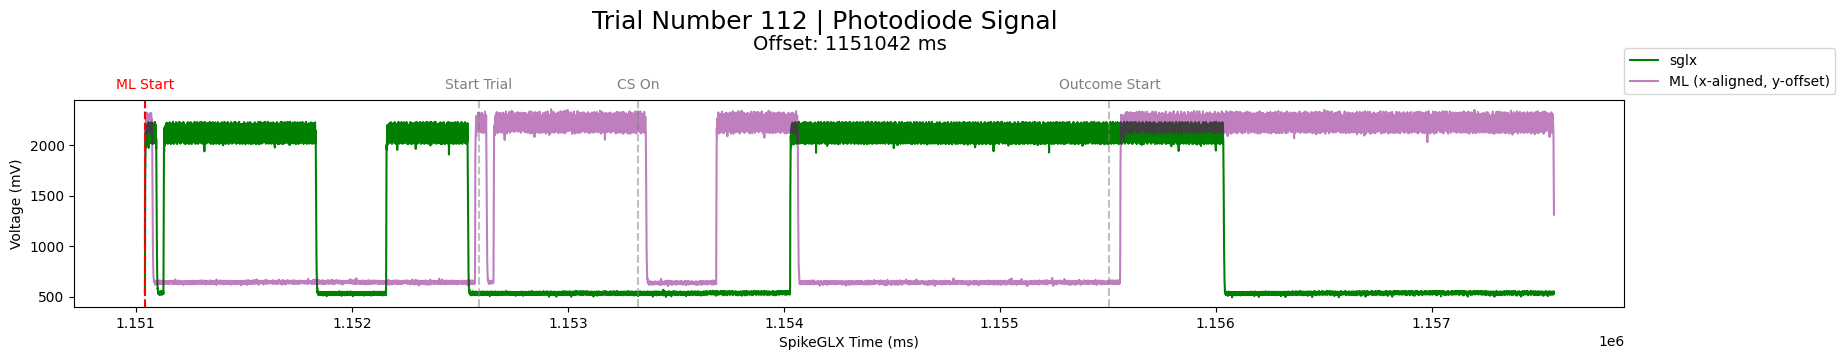

Trial 112:
  ML Cam Start           |  8      
  ML Cam End             |  6517   
  ML Cam Num Frames      |  782    
  --------------------------------------
  SpikeGLX Trial Start   |  1151041.93
  SpikeGLX Trial End     |  1157566.93
  SpikeGLX Num Frames    |  783    
  ML-SGLX Correlation: -0.604
  Trial 113 | Epoch start 1157161.442007081 | Epoch end 1166664.442007081


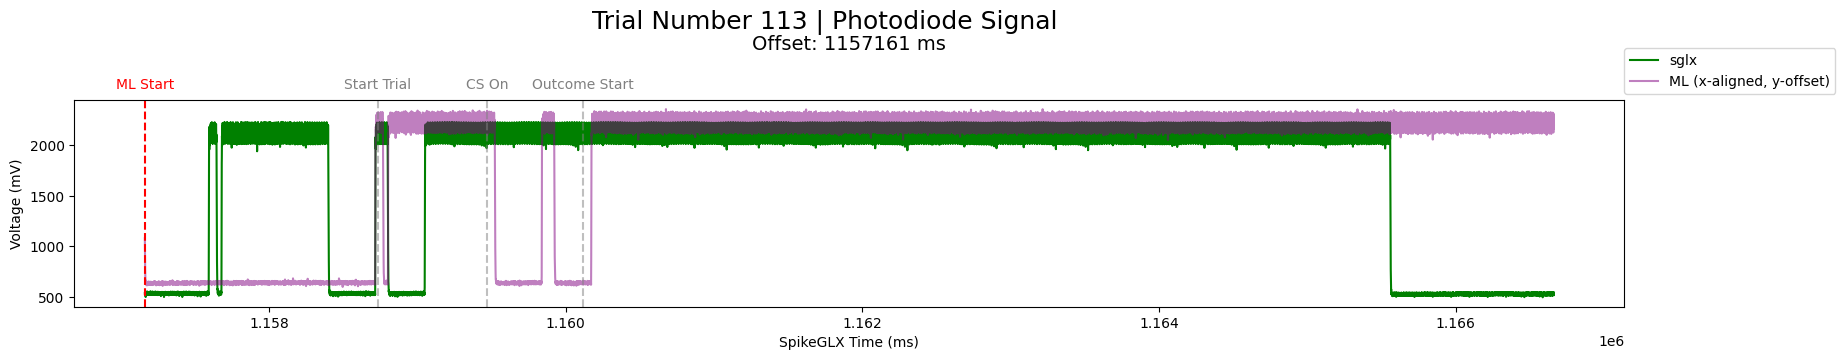

Trial 113:
  ML Cam Start           |  9      
  ML Cam End             |  9500   
  ML Cam Num Frames      |  1140   
  --------------------------------------
  SpikeGLX Trial Start   |  1157161.44
  SpikeGLX Trial End     |  1166664.44
  SpikeGLX Num Frames    |  1141   
  ML-SGLX Correlation: 0.176
Trial 114 | Correlation: 0.995 | SGLX High Time: 464 | ML High Time: 1554
  Trial 114 | Epoch start 1165541.9560528223 | Epoch end 1176762.9560528223
Trial 115 | Correlation: 0.997 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 115 | Epoch start 1176762.4748584118 | Epoch end 1183319.4748584118
Trial 116 | Correlation: 0.991 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 116 | Epoch start 1183319.9858488003 | Epoch end 1192866.9858488003
Trial 117 | Correlation: 0.992 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 117 | Epoch start 1192866.501848761 | Epoch end 1199082.501848761
Trial 118 | Correlation: 0.995 | SGLX High Time: 5385 | ML High Time: 2892
  Trial 118 | Epoch s

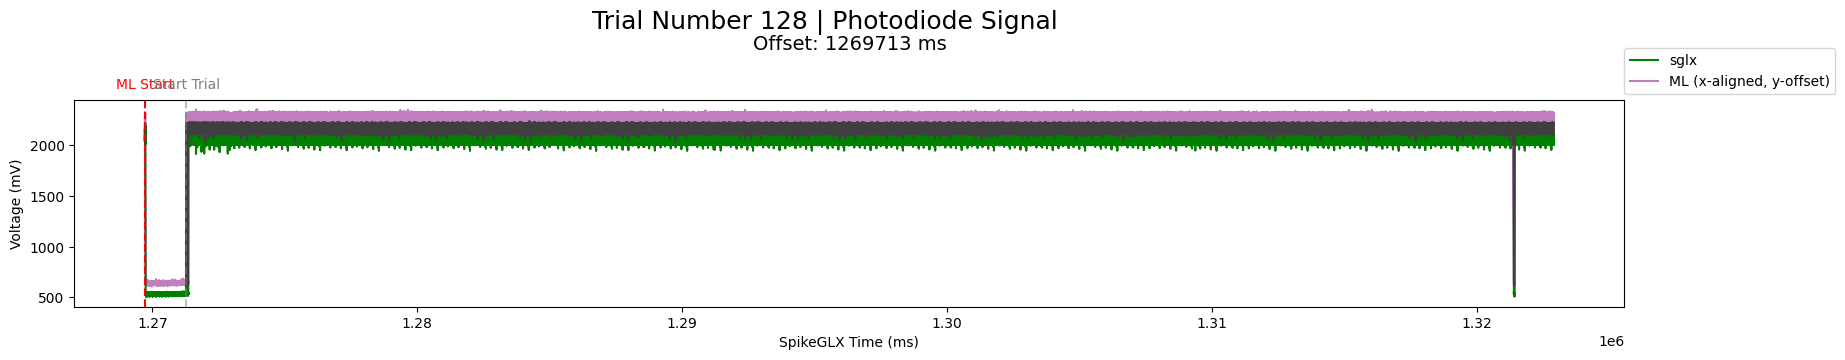

Trial 128:
  ML Cam Start           |  1      
  ML Cam End             |  53201  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  1269713.13
  SpikeGLX Trial End     |  1322916.13
  SpikeGLX Num Frames    |  6385   
  ML-SGLX Correlation: 0.946
Trial 129 | Correlation: 0.988 | SGLX High Time: 2676 | ML High Time: 1536
  Trial 129 | Epoch start 1322917.7197844344 | Epoch end 1348133.7197844344
Trial 130 | Correlation: 0.996 | SGLX High Time: 5261 | ML High Time: 2830
  Trial 130 | Epoch start 1348133.764215269 | Epoch end 1353927.764215269
Trial 131 | Correlation: 0.998 | SGLX High Time: 2751 | ML High Time: 1575
  Trial 131 | Epoch start 1353927.7718226456 | Epoch end 1359811.7718226456
Trial 132 | Correlation: 0.995 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 132 | Epoch start 1359811.78164905 | Epoch end 1371137.78164905
Trial 133 | Correlation: 0.995 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 133 | Epoch star

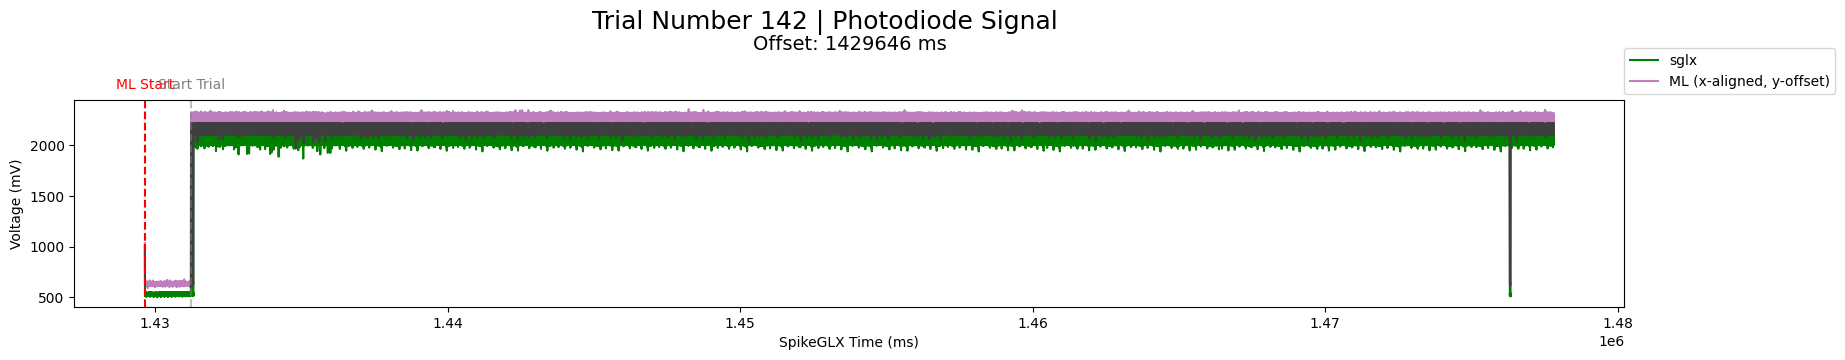

Trial 142:
  ML Cam Start           |  4      
  ML Cam End             |  48179  
  ML Cam Num Frames      |  5782   
  --------------------------------------
  SpikeGLX Trial Start   |  1429646.4
  SpikeGLX Trial End     |  1477826.4
  SpikeGLX Num Frames    |  5782   
  ML-SGLX Correlation: 0.949
  Trial 143 | Epoch start 1477827.4794131916 | Epoch end 1531001.4794131916


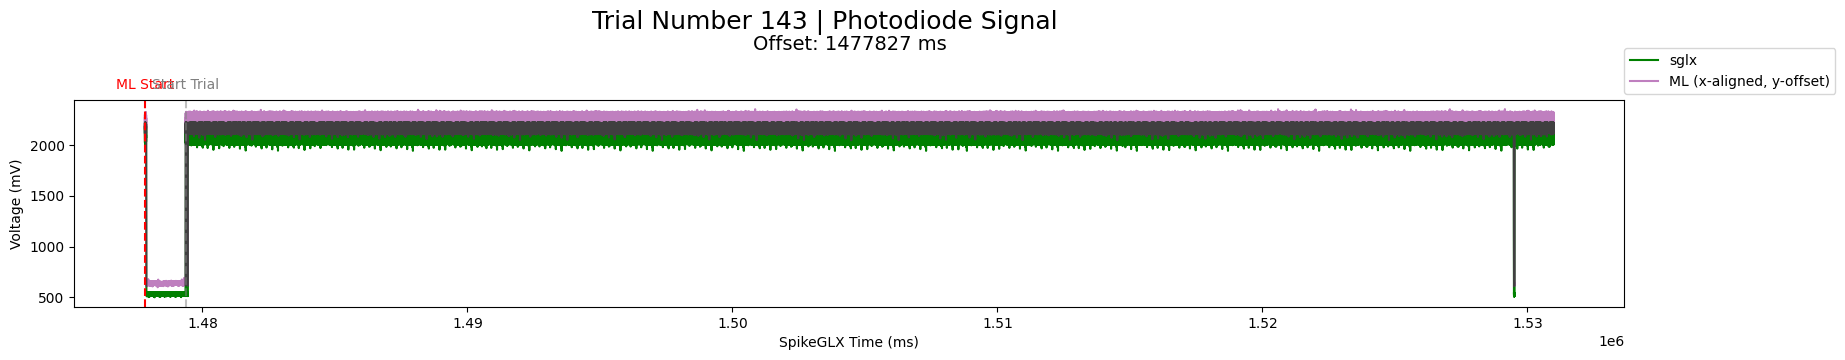

Trial 143:
  ML Cam Start           |  7      
  ML Cam End             |  53165  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  1477827.48
  SpikeGLX Trial End     |  1531001.48
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.944
  Trial 144 | Epoch start 1531001.5685346408 | Epoch end 1584164.5685346408


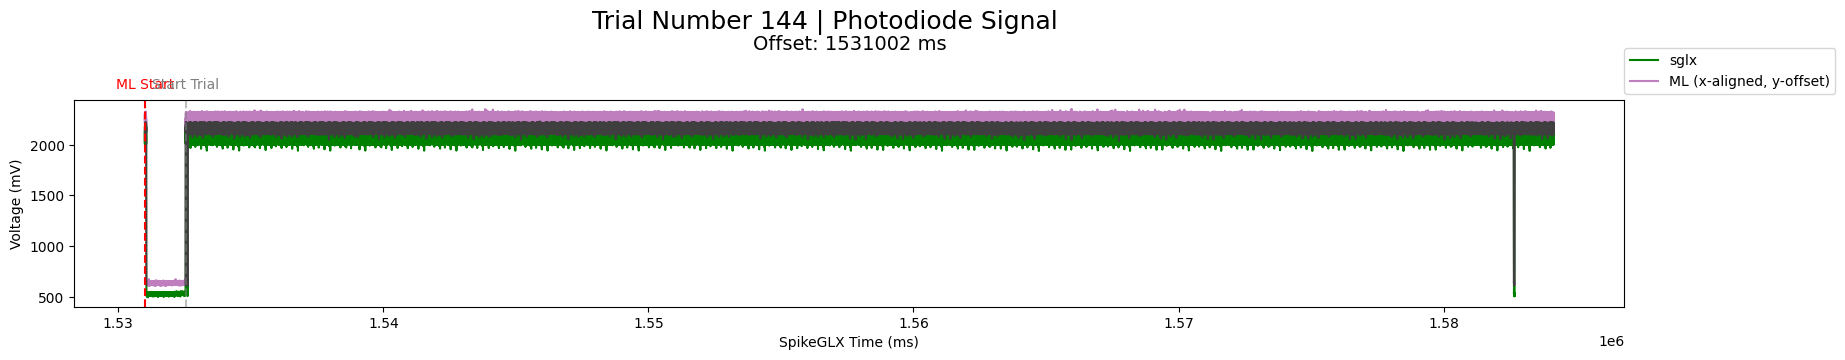

Trial 144:
  ML Cam Start           |  8      
  ML Cam End             |  53158  
  ML Cam Num Frames      |  6379   
  --------------------------------------
  SpikeGLX Trial Start   |  1531001.57
  SpikeGLX Trial End     |  1584164.57
  SpikeGLX Num Frames    |  6379   
  ML-SGLX Correlation: 0.944
Trial 145 | Correlation: 0.994 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 145 | Epoch start 1584164.6576359782 | Epoch end 1588541.6576359782
Trial 146 | Correlation: 0.992 | SGLX High Time: 2711 | ML High Time: 1554
  Trial 146 | Epoch start 1588542.6650020105 | Epoch end 1593100.6650020105
Trial 147 | Correlation: 0.996 | SGLX High Time: 2672 | ML High Time: 1536
  Trial 147 | Epoch start 1593100.1726102252 | Epoch end 1596805.1726102252
Trial 148 | Correlation: 0.994 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 148 | Epoch start 1596805.1788214918 | Epoch end 1604617.1788214918
Trial 149 | Correlation: 0.994 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 149 | Epoc

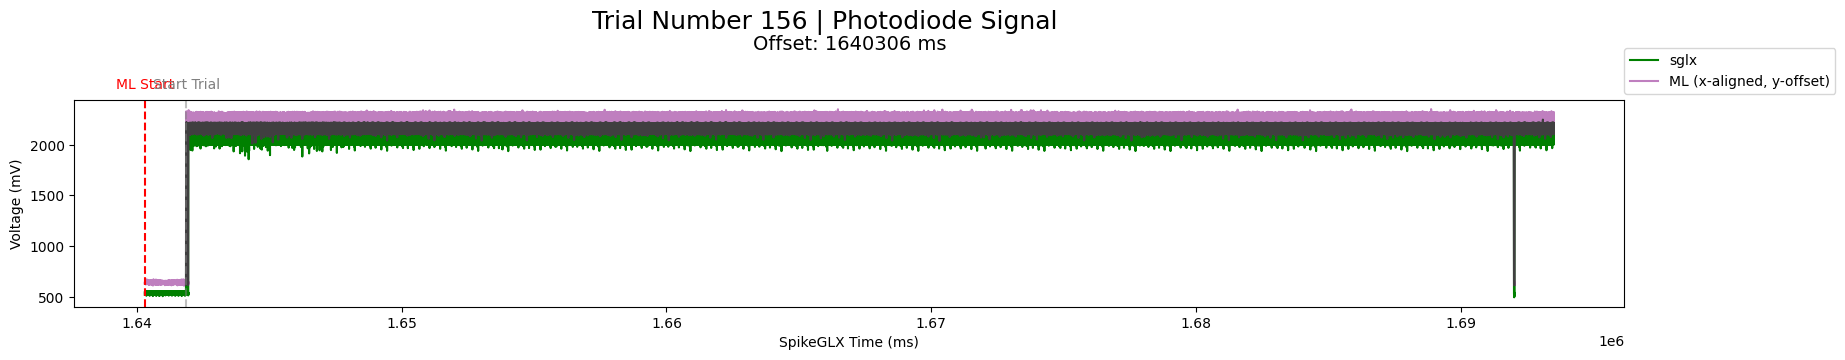

Trial 156:
  ML Cam Start           |  5      
  ML Cam End             |  53197  
  ML Cam Num Frames      |  6384   
  --------------------------------------
  SpikeGLX Trial Start   |  1640306.25
  SpikeGLX Trial End     |  1693505.25
  SpikeGLX Num Frames    |  6384   
  ML-SGLX Correlation: 0.944
  Trial 157 | Epoch start 1693505.3408909633 | Epoch end 1746678.3408909633


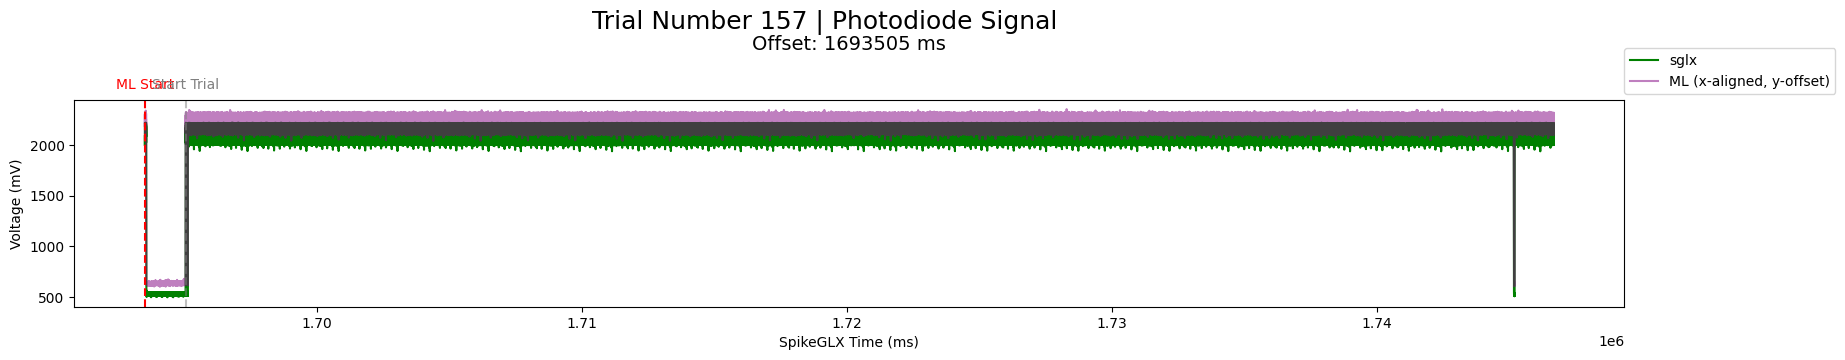

Trial 157:
  ML Cam Start           |  6      
  ML Cam End             |  53164  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  1693505.34
  SpikeGLX Trial End     |  1746678.34
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.945
  Trial 158 | Epoch start 1746678.9300098987 | Epoch end 1799850.9300098987


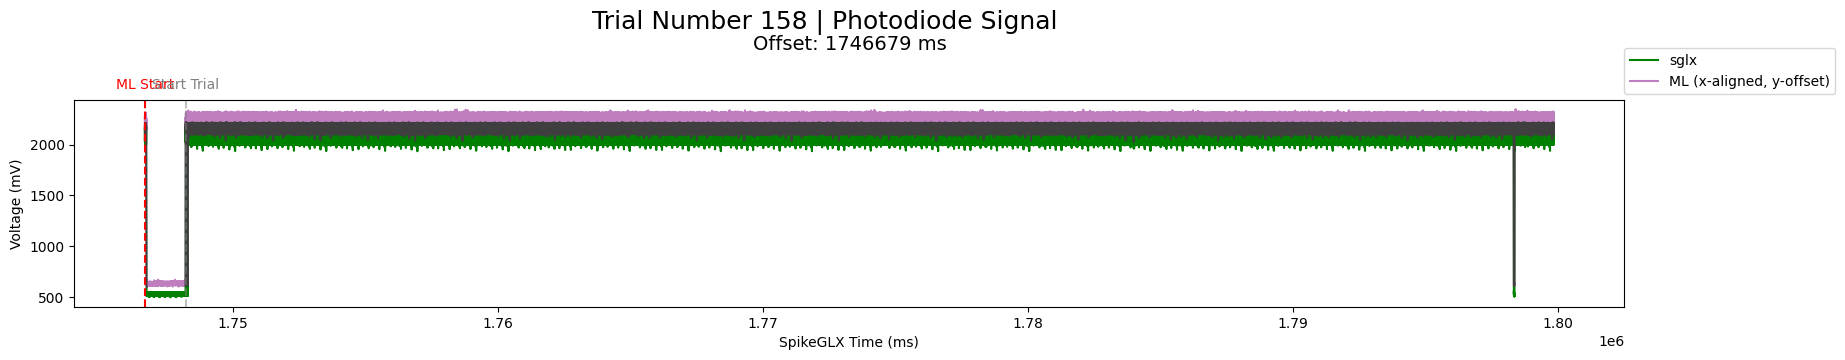

Trial 158:
  ML Cam Start           |  8      
  ML Cam End             |  53166  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  1746678.93
  SpikeGLX Trial End     |  1799850.93
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.945
  Trial 159 | Epoch start 1799851.519127158 | Epoch end 1847567.519127158


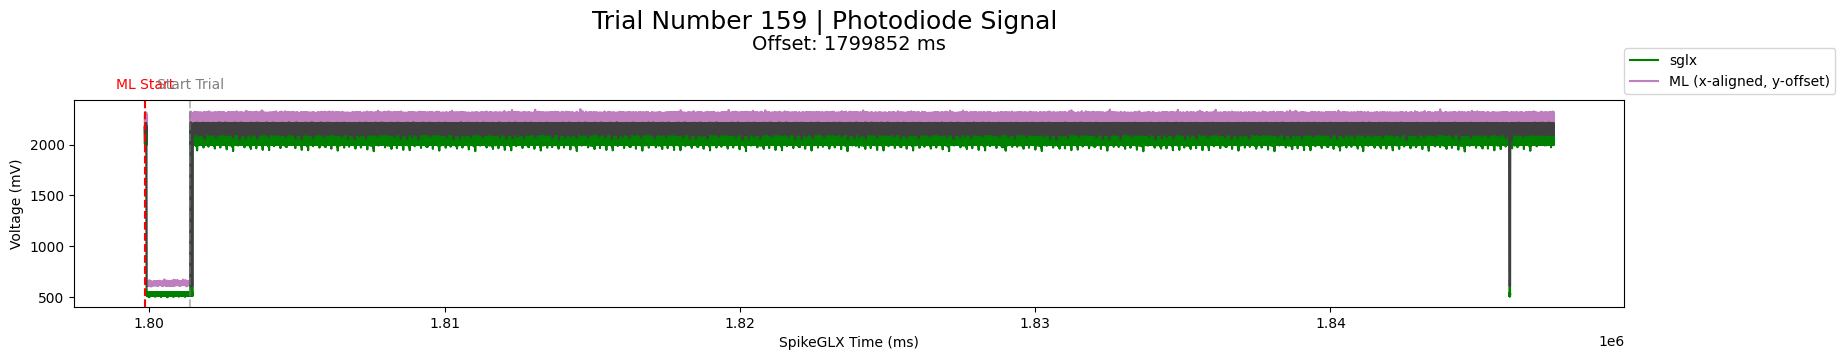

Trial 159:
  ML Cam Start           |  3      
  ML Cam End             |  47711  
  ML Cam Num Frames      |  5726   
  --------------------------------------
  SpikeGLX Trial Start   |  1799851.52
  SpikeGLX Trial End     |  1847567.52
  SpikeGLX Num Frames    |  5726   
  ML-SGLX Correlation: 0.946
Trial 160 | Correlation: 0.998 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 160 | Epoch start 1847567.599099308 | Epoch end 1851106.599099308
Trial 161 | Correlation: 0.996 | SGLX High Time: 2676 | ML High Time: 1537
  Trial 161 | Epoch start 1851107.10503152 | Epoch end 1854771.10503152
Trial 162 | Correlation: 0.994 | SGLX High Time: 2674 | ML High Time: 1536
  Trial 162 | Epoch start 1854771.6111715562 | Epoch end 1858510.6111715562
Trial 163 | Correlation: 0.995 | SGLX High Time: 2707 | ML High Time: 1553
  Trial 163 | Epoch start 1858510.6174666227 | Epoch end 1862633.6174666227
Trial 164 | Correlation: 0.991 | SGLX High Time: 2674 | ML High Time: 1537
  Trial 164 | Epoch star

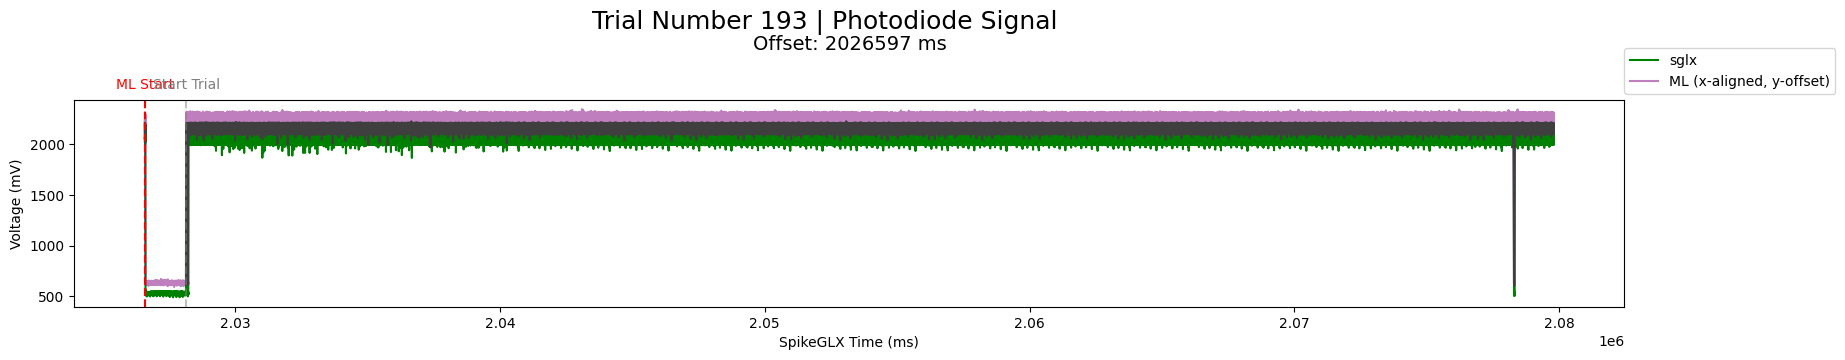

Trial 193:
  ML Cam Start           |  2      
  ML Cam End             |  53193  
  ML Cam Num Frames      |  6384   
  --------------------------------------
  SpikeGLX Trial Start   |  2026596.9
  SpikeGLX Trial End     |  2079797.9
  SpikeGLX Num Frames    |  6384   
  ML-SGLX Correlation: 0.944
  Trial 194 | Epoch start 2079798.9883191164 | Epoch end 2132961.9883191166


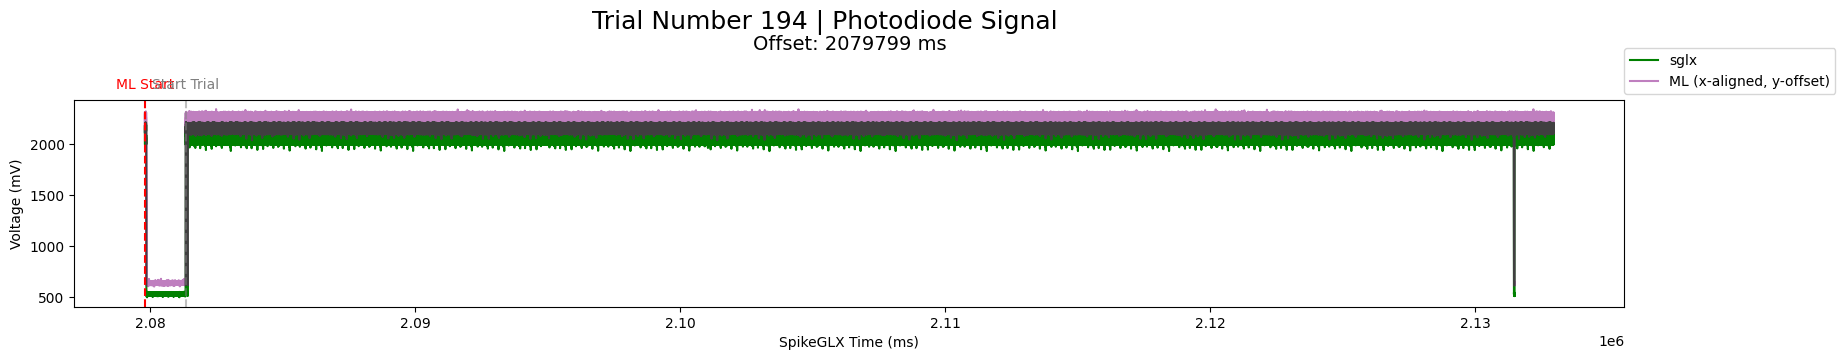

Trial 194:
  ML Cam Start           |  1      
  ML Cam End             |  53159  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  2079798.99
  SpikeGLX Trial End     |  2132961.99
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.944
  Trial 195 | Epoch start 2132962.0774204535 | Epoch end 2180434.0774204535


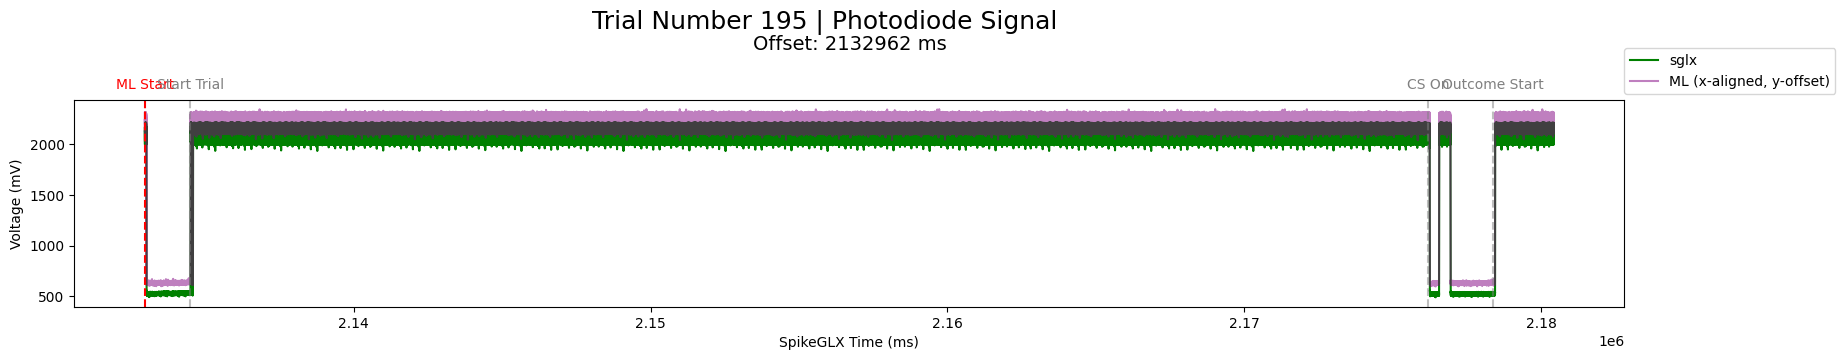

Trial 195:
  ML Cam Start           |  4      
  ML Cam End             |  47471  
  ML Cam Num Frames      |  5697   
  --------------------------------------
  SpikeGLX Trial Start   |  2132962.08
  SpikeGLX Trial End     |  2180434.08
  SpikeGLX Num Frames    |  5696   
  ML-SGLX Correlation: 0.975
Trial 196 | Correlation: 0.999 | SGLX High Time: 2753 | ML High Time: 1575
  Trial 196 | Epoch start 2180435.157049023 | Epoch end 2185185.157049023
Trial 197 | Correlation: 0.995 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 197 | Epoch start 2185185.6649756785 | Epoch end 2196904.6649756785
Trial 198 | Correlation: 0.995 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 198 | Epoch start 2196904.684616755 | Epoch end 2203484.684616755
Trial 199 | Correlation: 0.99 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 199 | Epoch start 2203484.195644016 | Epoch end 2213082.195644016
Trial 200 | Correlation: 0.997 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 200 | Epoch start

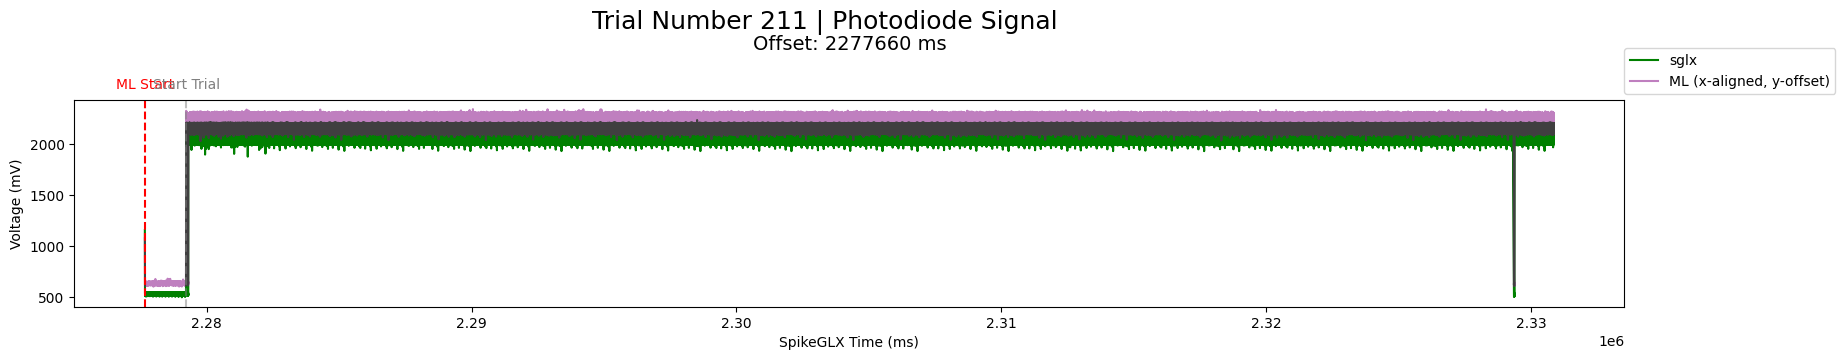

Trial 211:
  ML Cam Start           |  8      
  ML Cam End             |  53208  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  2277659.82
  SpikeGLX Trial End     |  2330872.82
  SpikeGLX Num Frames    |  6386   
  ML-SGLX Correlation: 0.943
  Trial 212 | Epoch start 2330873.9091190076 | Epoch end 2384034.9091190076


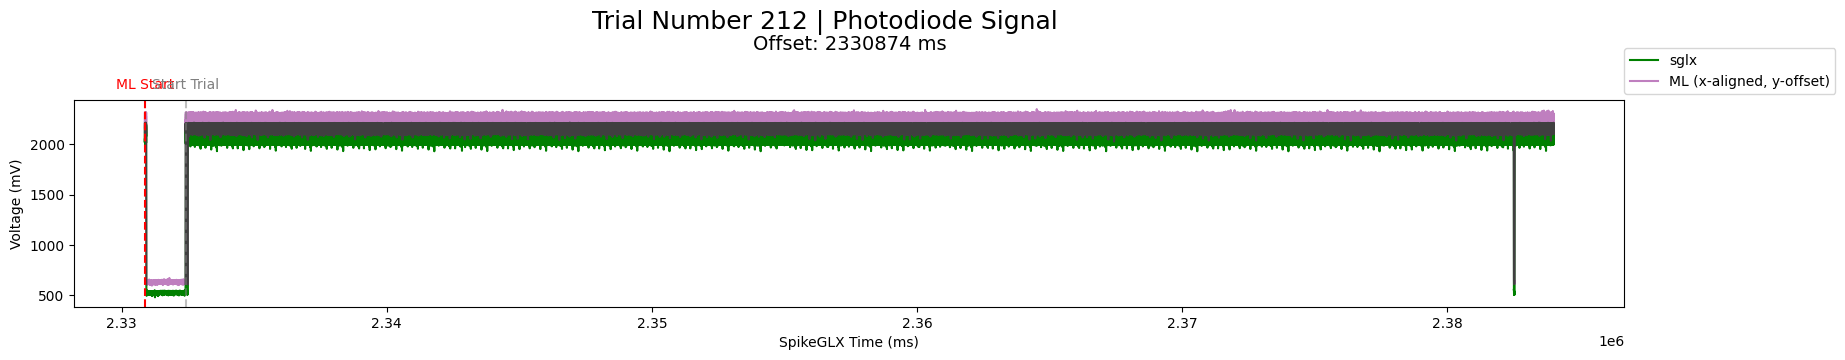

Trial 212:
  ML Cam Start           |  4      
  ML Cam End             |  53154  
  ML Cam Num Frames      |  6379   
  --------------------------------------
  SpikeGLX Trial Start   |  2330873.91
  SpikeGLX Trial End     |  2384034.91
  SpikeGLX Num Frames    |  6379   
  ML-SGLX Correlation: 0.941
  Trial 213 | Epoch start 2384034.998218669 | Epoch end 2437199.998218669


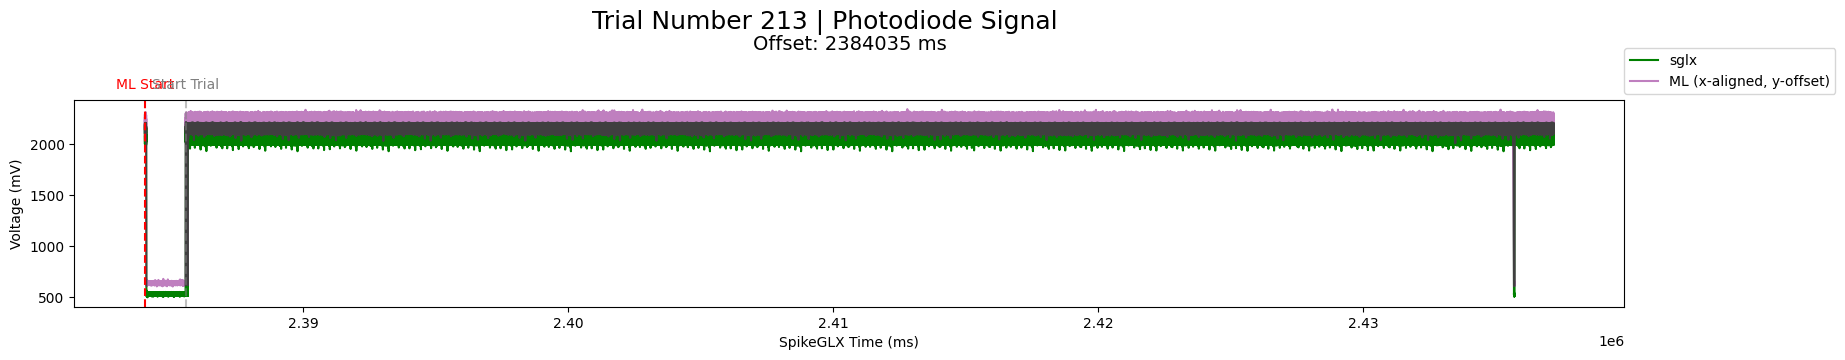

Trial 213:
  ML Cam Start           |  1      
  ML Cam End             |  53159  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  2384035.0
  SpikeGLX Trial End     |  2437200.0
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.943
Trial 214 | Correlation: 0.986 | SGLX High Time: 2675 | ML High Time: 1536
  Trial 214 | Epoch start 2437201.0873233583 | Epoch end 2449319.0873233583
  Trial 215 | Epoch start 2449318.607633998 | Epoch end 2502483.607633998


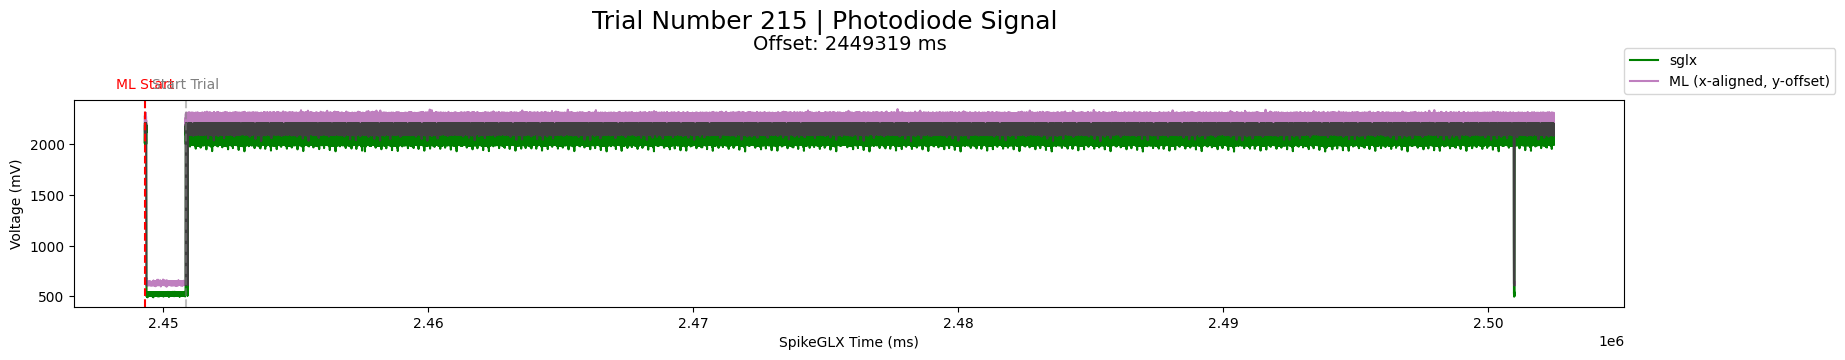

Trial 215:
  ML Cam Start           |  1      
  ML Cam End             |  53160  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  2449318.61
  SpikeGLX Trial End     |  2502483.61
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.943
  Trial 216 | Epoch start 2502484.6967671798 | Epoch end 2555661.6967671798


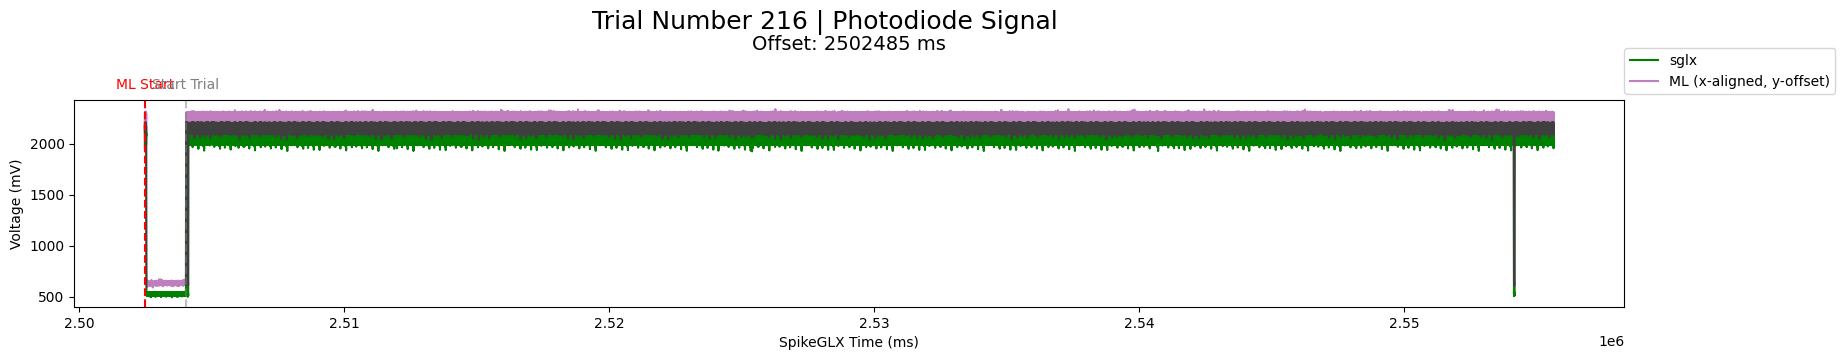

Trial 216:
  ML Cam Start           |  3      
  ML Cam End             |  53170  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  2502484.7
  SpikeGLX Trial End     |  2555661.7
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.944
Trial 217 | Correlation: 0.99 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 217 | Epoch start 2555661.785865165 | Epoch end 2560419.785865165
Trial 218 | Correlation: 0.995 | SGLX High Time: 2675 | ML High Time: 1536
  Trial 218 | Epoch start 2560420.7938395864 | Epoch end 2571521.7938395864
Trial 219 | Correlation: 0.997 | SGLX High Time: 2707 | ML High Time: 1554
  Trial 219 | Epoch start 2571520.8124733856 | Epoch end 2575836.8124733856
Trial 220 | Correlation: 0.994 | SGLX High Time: 2712 | ML High Time: 1555
  Trial 220 | Epoch start 2575837.319709528 | Epoch end 2583402.319709528
Trial 221 | Correlation: 0.999 | SGLX High Time: 5386 | ML High Time: 2892
  Trial 221 | Epoch start

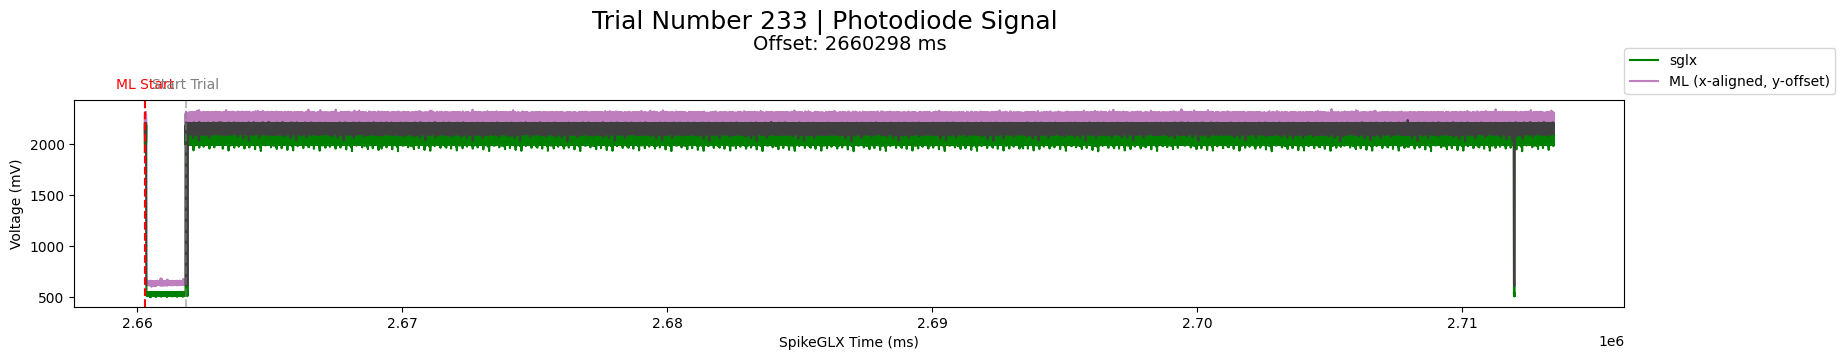

Trial 233:
  ML Cam Start           |  8      
  ML Cam End             |  53166  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  2660298.46
  SpikeGLX Trial End     |  2713472.46
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.941
  Trial 234 | Epoch start 2713473.0503568444 | Epoch end 2766636.0503568444


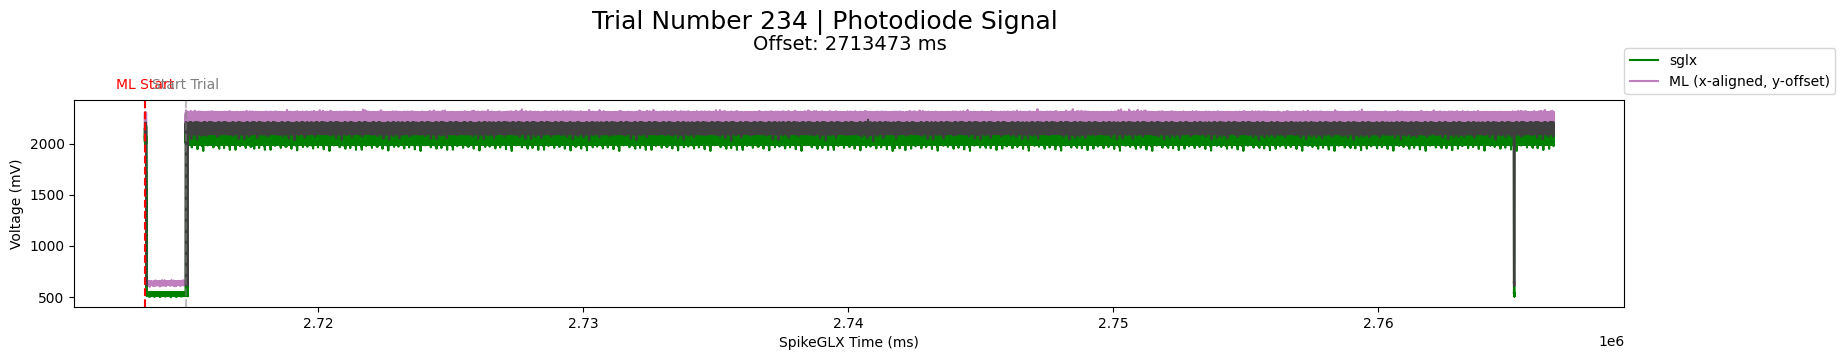

Trial 234:
  ML Cam Start           |  1      
  ML Cam End             |  53159  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  2713473.05
  SpikeGLX Trial End     |  2766636.05
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.941
  Trial 235 | Epoch start 2766636.6394858356 | Epoch end 2819819.6394858356


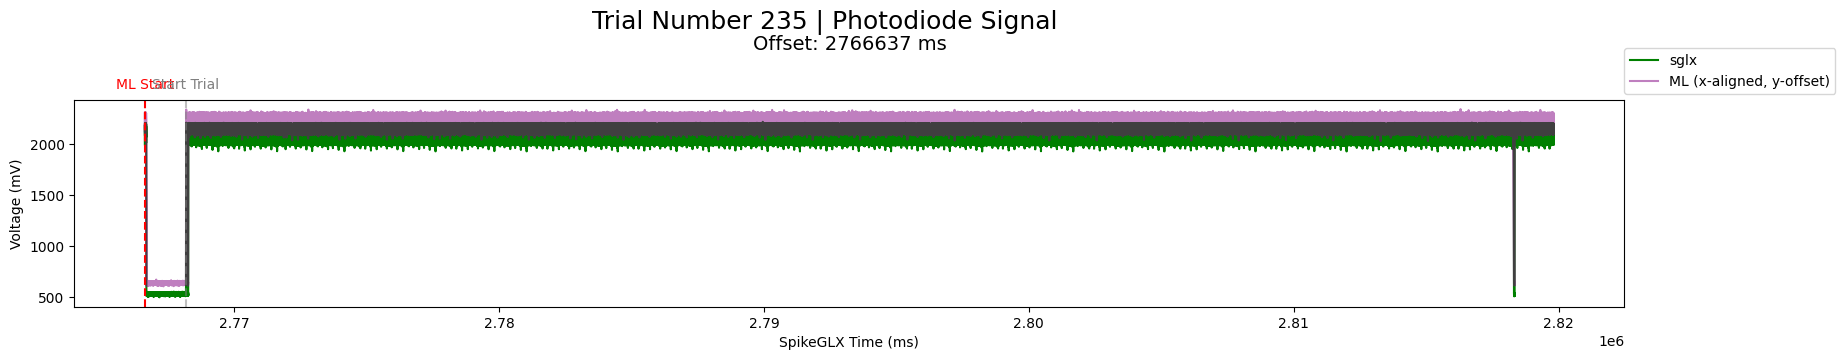

Trial 235:
  ML Cam Start           |  4      
  ML Cam End             |  53179  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  2766636.64
  SpikeGLX Trial End     |  2819819.64
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.943
  Trial 236 | Epoch start 2819820.2285947152 | Epoch end 2872991.2285947152


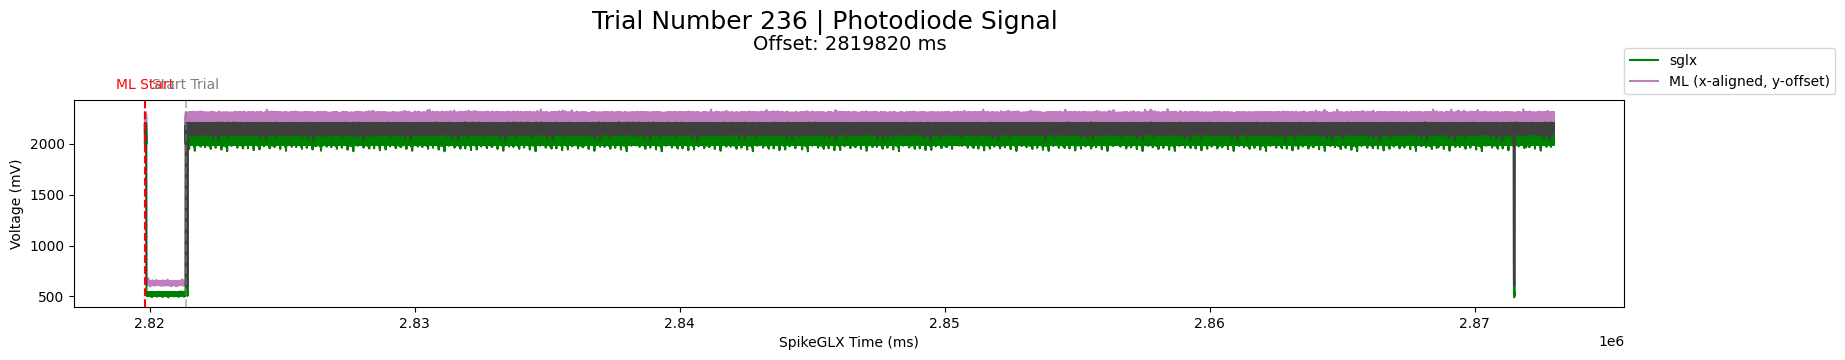

Trial 236:
  ML Cam Start           |  5      
  ML Cam End             |  53163  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  2819820.23
  SpikeGLX Trial End     |  2872991.23
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.944
  Trial 237 | Epoch start 2872991.8177102986 | Epoch end 2926169.8177102986


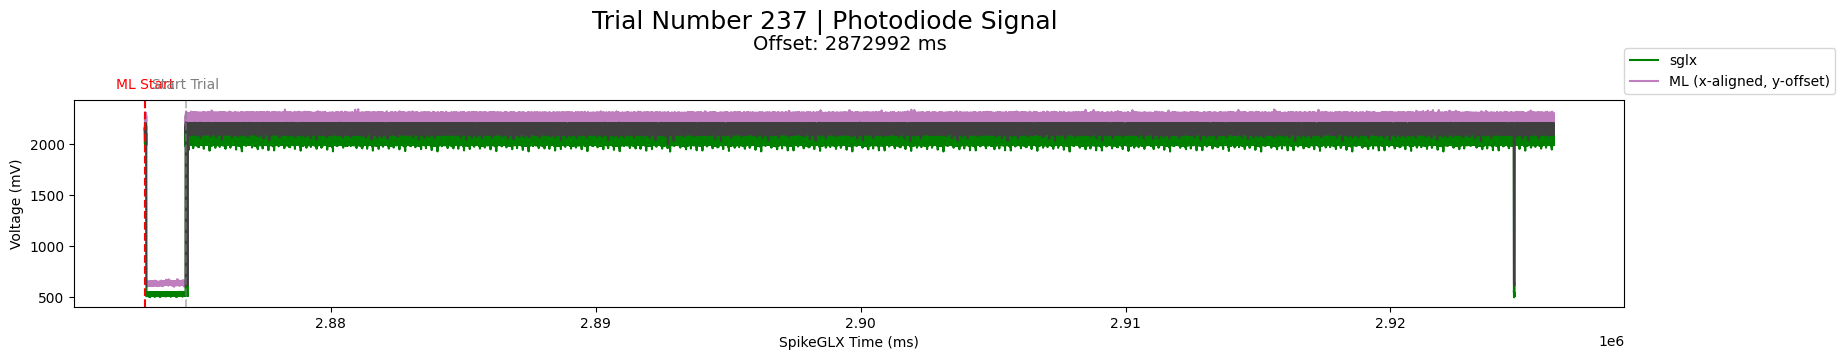

Trial 237:
  ML Cam Start           |  9      
  ML Cam End             |  53175  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  2872991.82
  SpikeGLX Trial End     |  2926169.82
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.944
  Trial 238 | Epoch start 2926170.406835938 | Epoch end 2979348.406835938


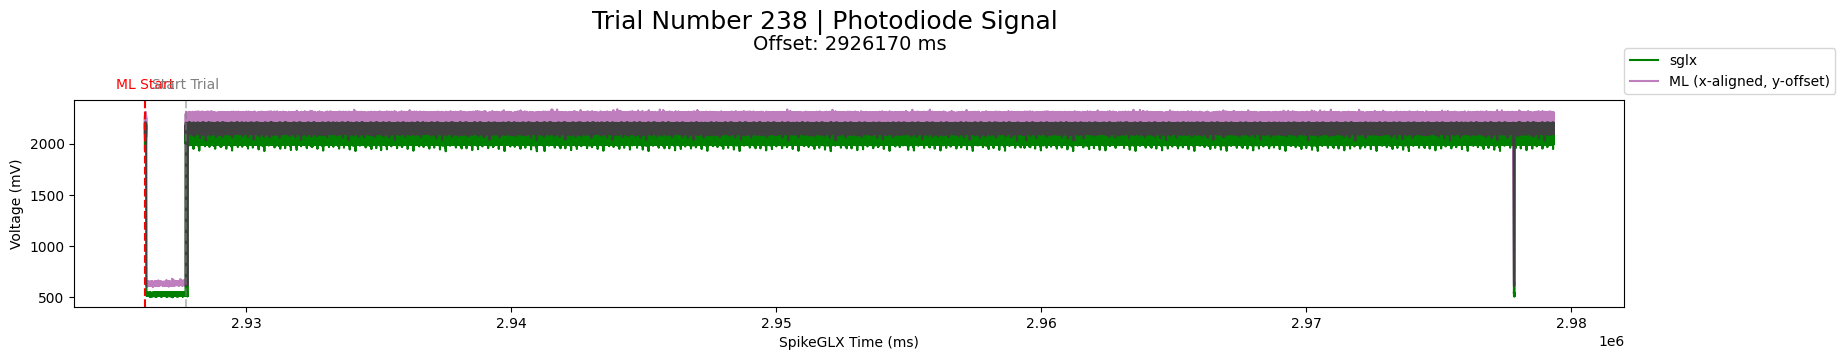

Trial 238:
  ML Cam Start           |  6      
  ML Cam End             |  53172  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  2926170.41
  SpikeGLX Trial End     |  2979348.41
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.944
  Trial 239 | Epoch start 2979349.4959624154 | Epoch end 3032517.4959624154


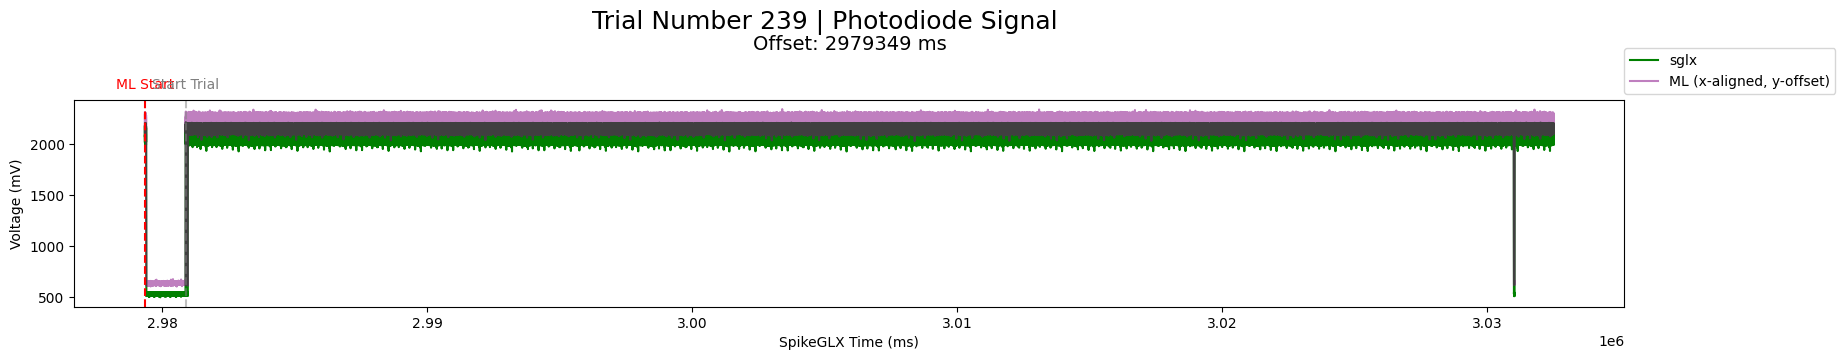

Trial 239:
  ML Cam Start           |  3      
  ML Cam End             |  53161  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  2979349.5
  SpikeGLX Trial End     |  3032517.5
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.945
  Trial 240 | Epoch start 3032518.0850746464 | Epoch end 3075126.0850746464


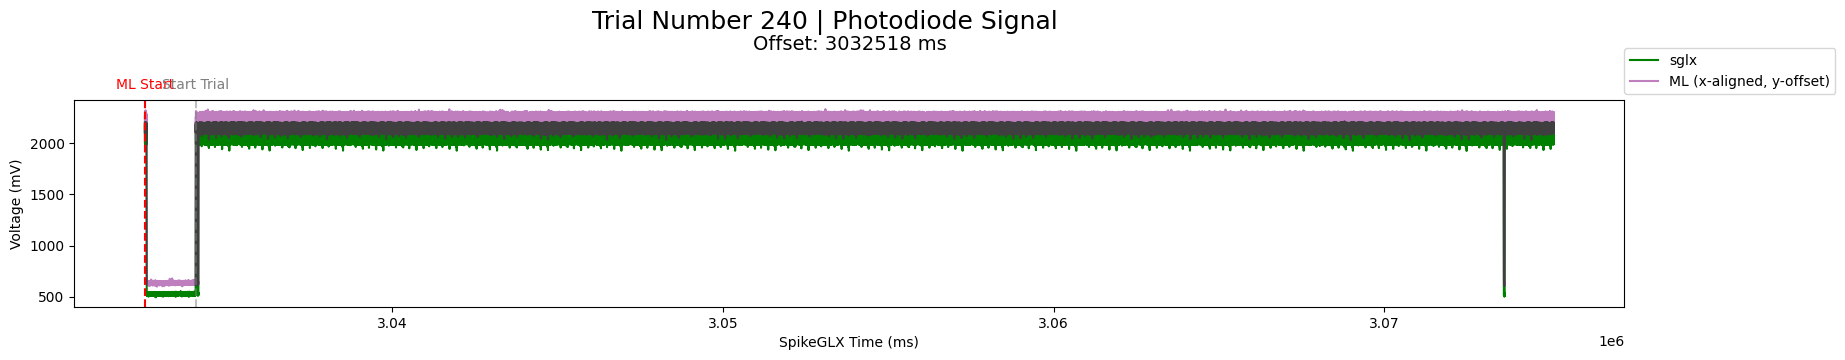

Trial 240:
  ML Cam Start           |  1      
  ML Cam End             |  42601  
  ML Cam Num Frames      |  5113   
  --------------------------------------
  SpikeGLX Trial Start   |  3032518.09
  SpikeGLX Trial End     |  3075126.09
  SpikeGLX Num Frames    |  5113   
  ML-SGLX Correlation: 0.954
Trial 241 | Correlation: 0.995 | SGLX High Time: 2674 | ML High Time: 1536
  Trial 241 | Epoch start 3075126.6564866123 | Epoch end 3086226.6564866123
Trial 242 | Correlation: 0.997 | SGLX High Time: 2710 | ML High Time: 1555
  Trial 242 | Epoch start 3086226.1751212496 | Epoch end 3092976.1751212496
Trial 243 | Correlation: 0.992 | SGLX High Time: 2711 | ML High Time: 1555
  Trial 243 | Epoch start 3092976.1864342685 | Epoch end 3099213.1864342685
Trial 244 | Correlation: 0.999 | SGLX High Time: 5468 | ML High Time: 2933
  Trial 244 | Epoch start 3099213.699197868 | Epoch end 3105872.699197868
Trial 245 | Correlation: 0.995 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 245 | Epoch 

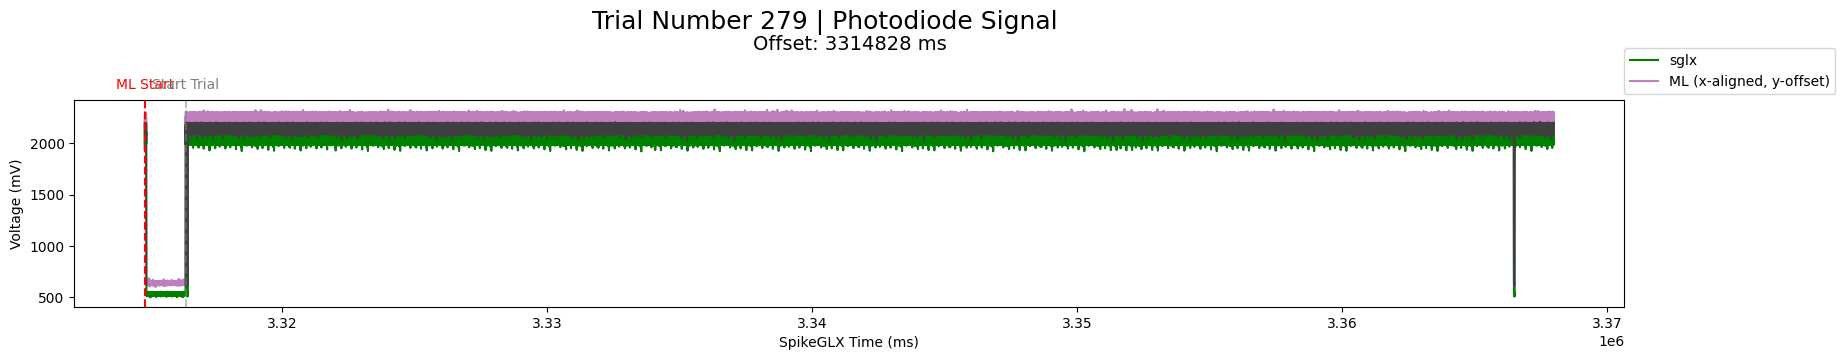

Trial 279:
  ML Cam Start           |  3      
  ML Cam End             |  53170  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  3314828.06
  SpikeGLX Trial End     |  3368000.06
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.941
  Trial 280 | Epoch start 3368000.647345097 | Epoch end 3421168.647345097


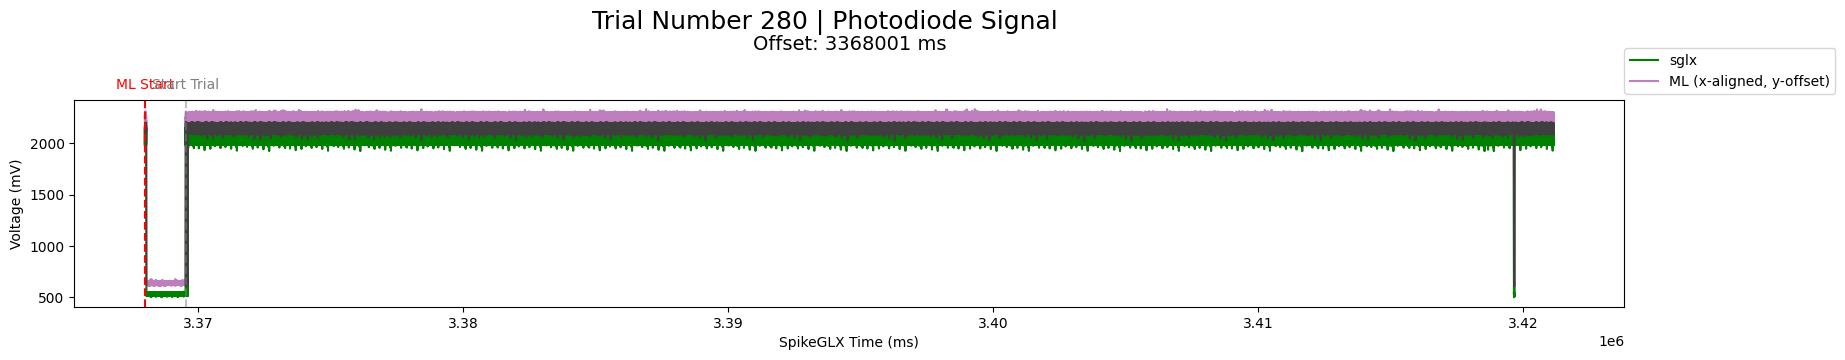

Trial 280:
  ML Cam Start           |  6      
  ML Cam End             |  53164  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  3368000.65
  SpikeGLX Trial End     |  3421168.65
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.943
  Trial 281 | Epoch start 3421169.2364556524 | Epoch end 3474341.2364556524


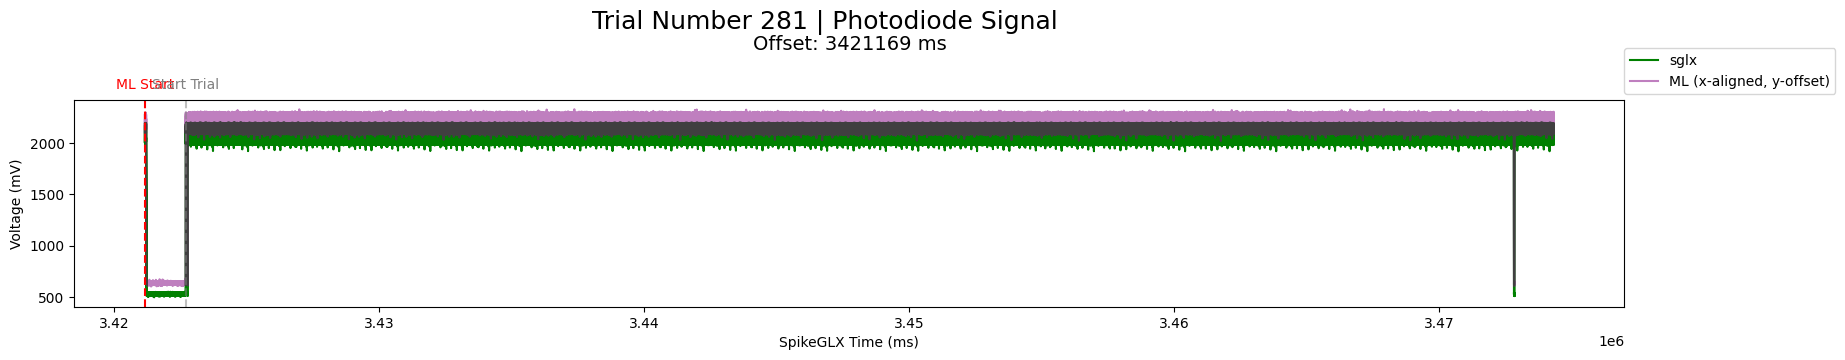

Trial 281:
  ML Cam Start           |  5      
  ML Cam End             |  53171  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  3421169.24
  SpikeGLX Trial End     |  3474341.24
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.944
  Trial 282 | Epoch start 3474341.3255720735 | Epoch end 3527514.3255720735


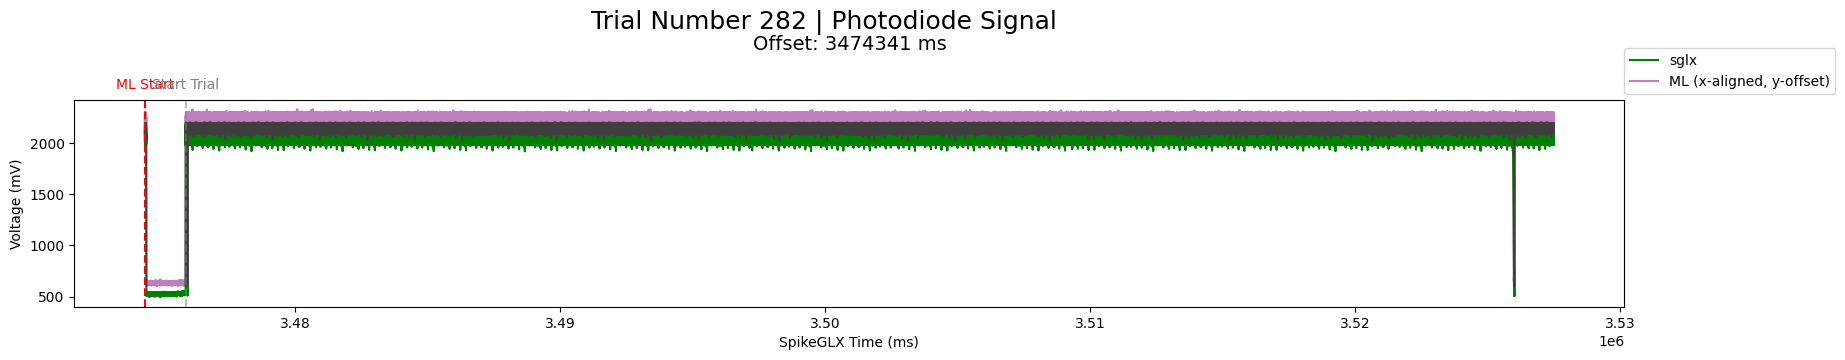

Trial 282:
  ML Cam Start           |  8      
  ML Cam End             |  53166  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  3474341.33
  SpikeGLX Trial End     |  3527514.33
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.942
  Trial 283 | Epoch start 3527514.914691009 | Epoch end 3580680.914691009


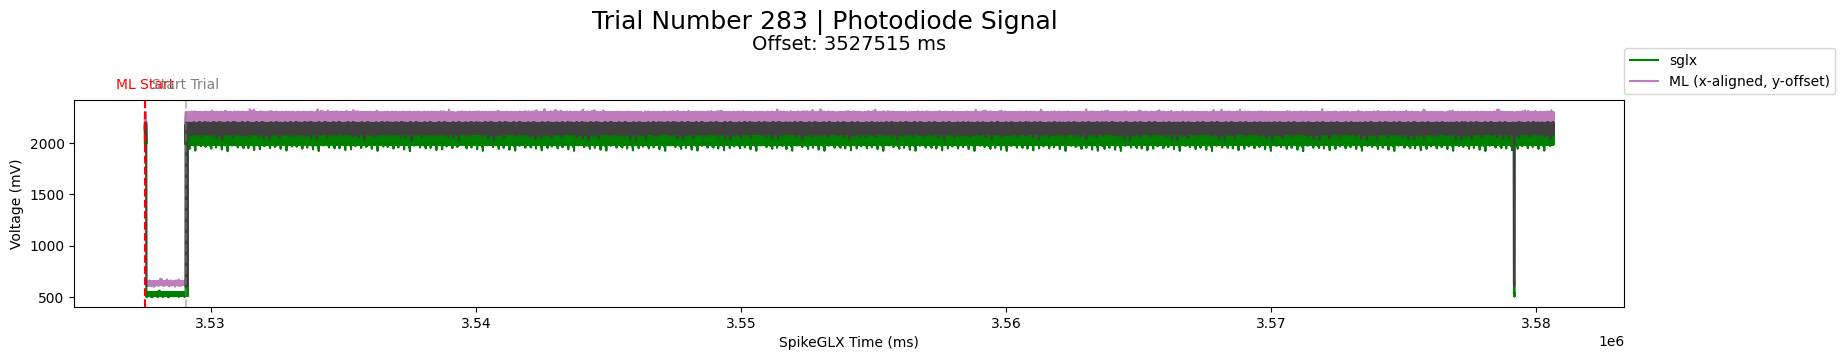

Trial 283:
  ML Cam Start           |  1      
  ML Cam End             |  53160  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  3527514.91
  SpikeGLX Trial End     |  3580680.91
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.941
  Trial 284 | Epoch start 3580682.5037982124 | Epoch end 3633850.5037982124


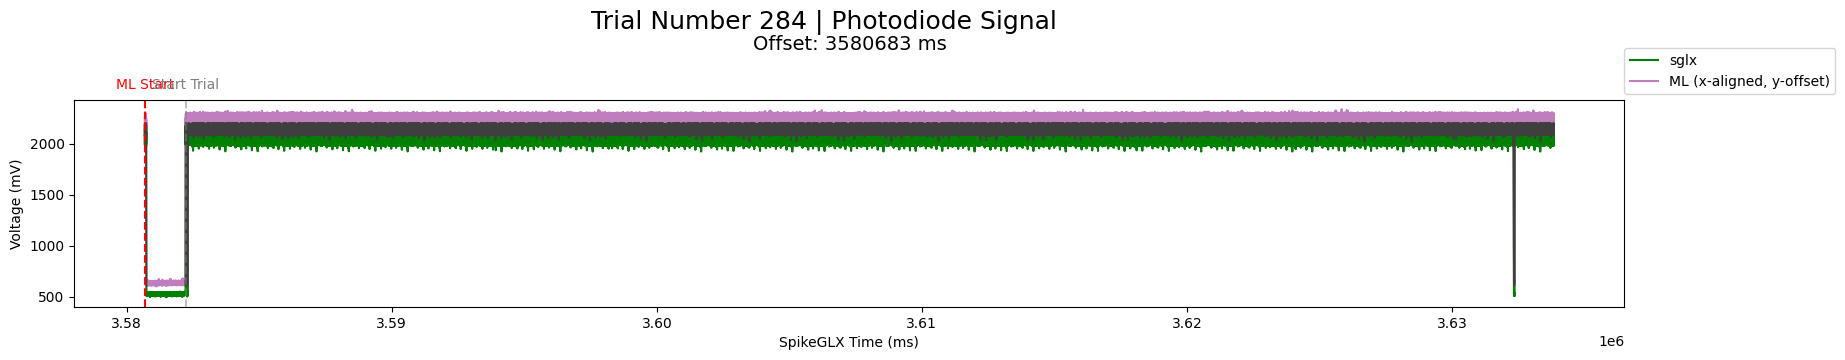

Trial 284:
  ML Cam Start           |  2      
  ML Cam End             |  53160  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  3580682.5
  SpikeGLX Trial End     |  3633850.5
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.944
  Trial 285 | Epoch start 3633850.0929087675 | Epoch end 3687019.0929087675


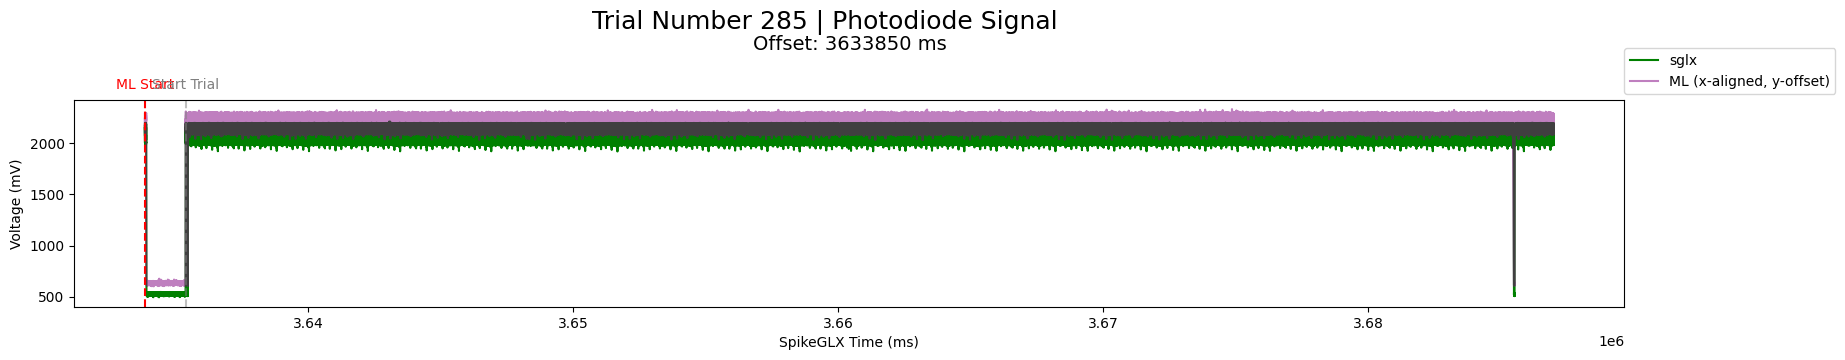

Trial 285:
  ML Cam Start           |  1      
  ML Cam End             |  53167  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  3633850.09
  SpikeGLX Trial End     |  3687019.09
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.942
  Trial 286 | Epoch start 3687020.182020161 | Epoch end 3740184.182020161


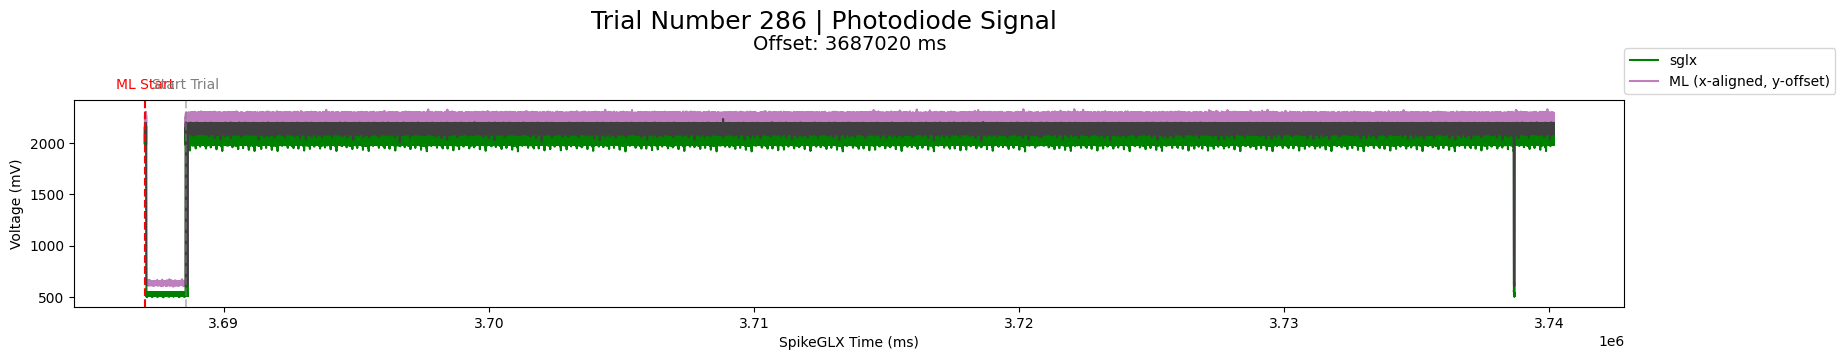

Trial 286:
  ML Cam Start           |  7      
  ML Cam End             |  53157  
  ML Cam Num Frames      |  6379   
  --------------------------------------
  SpikeGLX Trial Start   |  3687020.18
  SpikeGLX Trial End     |  3740184.18
  SpikeGLX Num Frames    |  6379   
  ML-SGLX Correlation: 0.942
  Trial 287 | Epoch start 3740184.7711525043 | Epoch end 3793373.7711525043


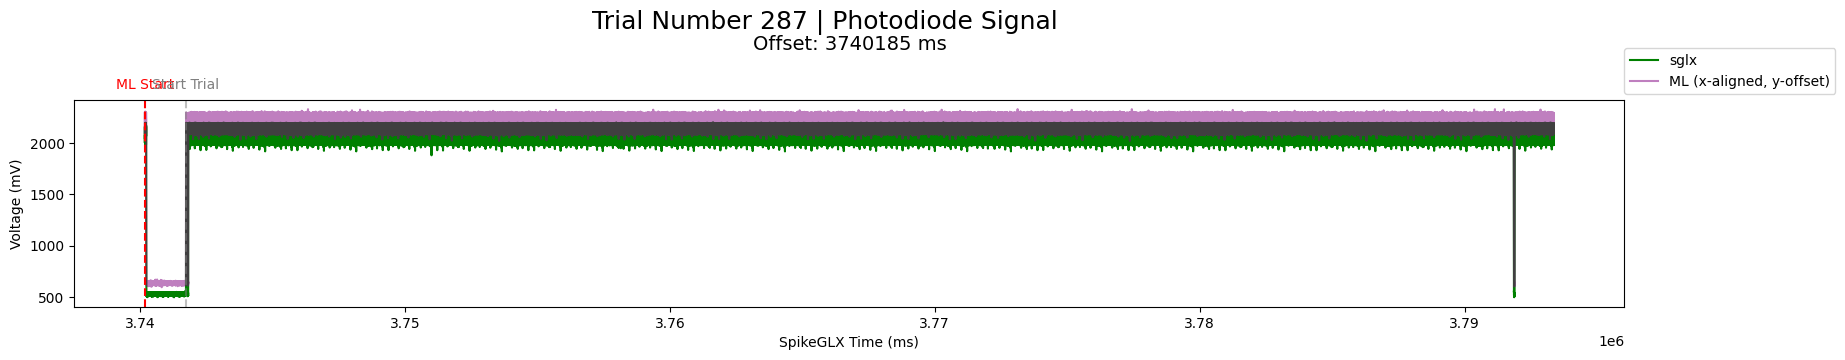

Trial 287:
  ML Cam Start           |  1      
  ML Cam End             |  53184  
  ML Cam Num Frames      |  6383   
  --------------------------------------
  SpikeGLX Trial Start   |  3740184.77
  SpikeGLX Trial End     |  3793373.77
  SpikeGLX Num Frames    |  6383   
  ML-SGLX Correlation: 0.943
  Trial 288 | Epoch start 3793374.3602697635 | Epoch end 3846547.3602697635


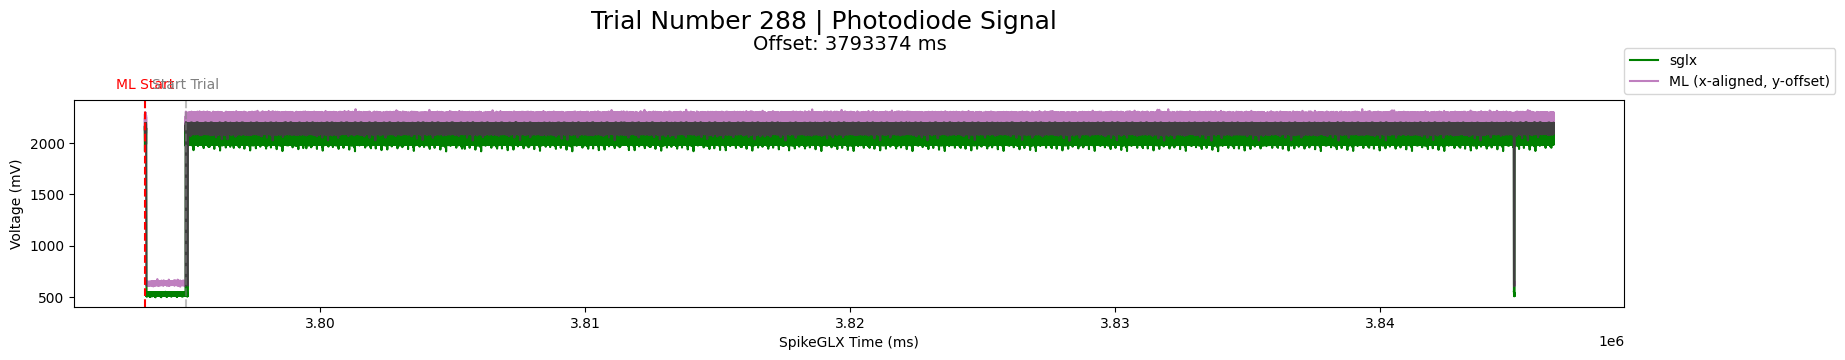

Trial 288:
  ML Cam Start           |  4      
  ML Cam End             |  53171  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  3793374.36
  SpikeGLX Trial End     |  3846547.36
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.944
  Trial 289 | Epoch start 3846547.449389537 | Epoch end 3899723.449389537


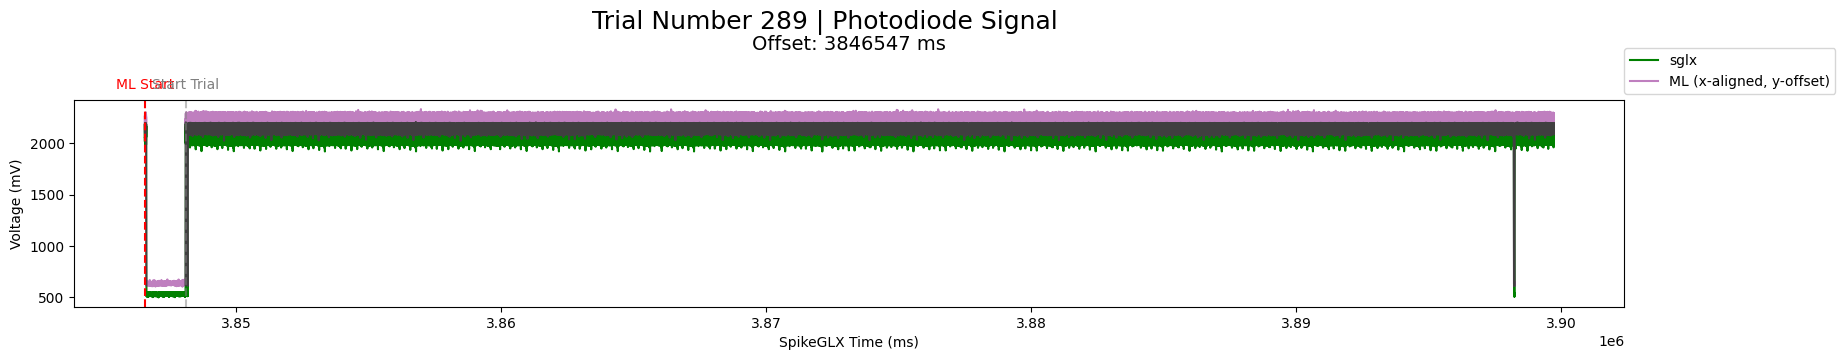

Trial 289:
  ML Cam Start           |  6      
  ML Cam End             |  53173  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  3846547.45
  SpikeGLX Trial End     |  3899723.45
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.942
  Trial 290 | Epoch start 3899724.0385135002 | Epoch end 3952887.0385135002


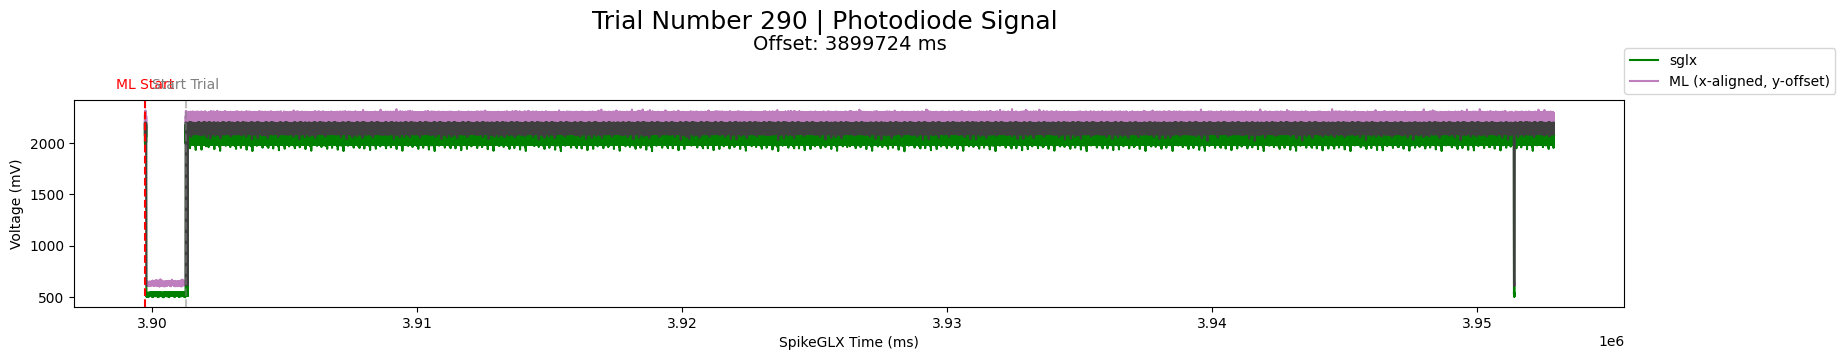

Trial 290:
  ML Cam Start           |  5      
  ML Cam End             |  53155  
  ML Cam Num Frames      |  6379   
  --------------------------------------
  SpikeGLX Trial Start   |  3899724.04
  SpikeGLX Trial End     |  3952887.04
  SpikeGLX Num Frames    |  6379   
  ML-SGLX Correlation: 0.941
Trial 291 | Correlation: 0.991 | SGLX High Time: 2677 | ML High Time: 1537
  Trial 291 | Epoch start 3952888.127616514 | Epoch end 3967227.127616514
Trial 292 | Correlation: 0.997 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 292 | Epoch start 3967227.15167721 | Epoch end 3973327.15167721
Trial 293 | Correlation: 0.995 | SGLX High Time: 5428 | ML High Time: 2913
  Trial 293 | Epoch start 3973327.664179353 | Epoch end 3979825.664179353
Trial 294 | Correlation: 0.995 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 294 | Epoch start 3979825.1727914936 | Epoch end 3987470.1727914936
Trial 295 | Correlation: 0.997 | SGLX High Time: 5385 | ML High Time: 2892
  Trial 295 | Epoch start 

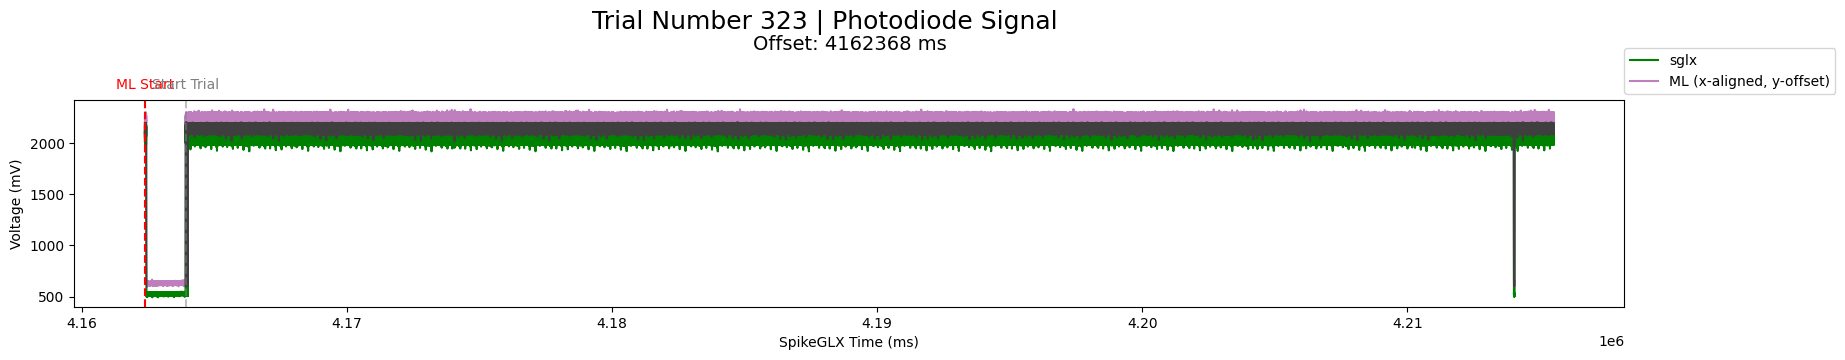

Trial 323:
  ML Cam Start           |  6      
  ML Cam End             |  53164  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  4162368.48
  SpikeGLX Trial End     |  4215537.48
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.941
  Trial 324 | Epoch start 4215538.067844629 | Epoch end 4268718.067844629


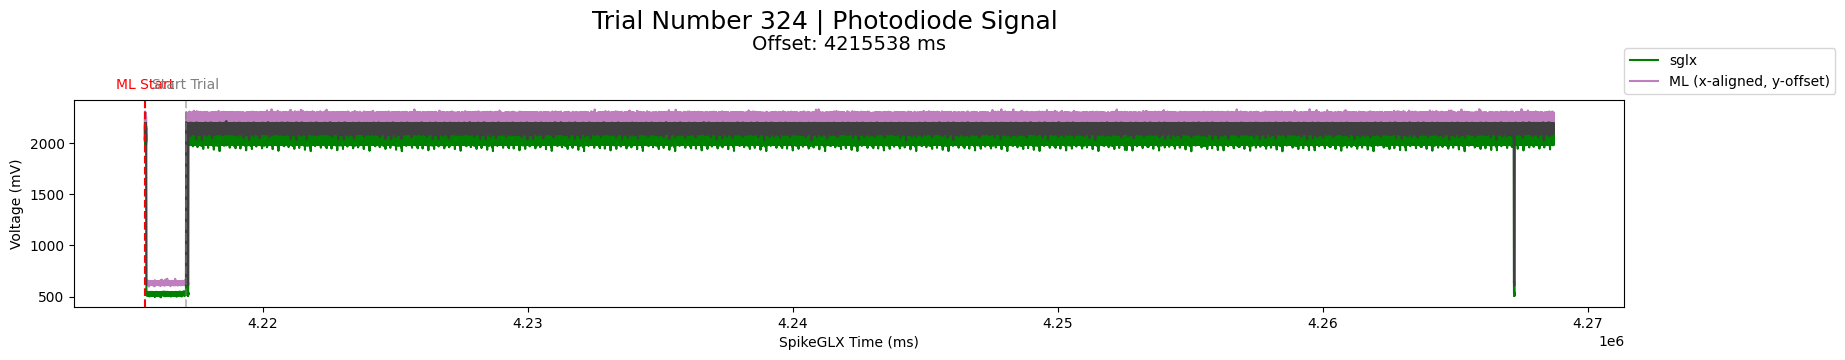

Trial 324:
  ML Cam Start           |  3      
  ML Cam End             |  53178  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  4215538.07
  SpikeGLX Trial End     |  4268718.07
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.942
Trial 325 | Correlation: 0.994 | SGLX High Time: 2676 | ML High Time: 1537
  Trial 325 | Epoch start 4268718.656948481 | Epoch end 4277582.656948481
Trial 326 | Correlation: 0.993 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 326 | Epoch start 4277583.1718339 | Epoch end 4282055.1718339
Trial 327 | Correlation: 0.993 | SGLX High Time: 2674 | ML High Time: 1537
  Trial 327 | Epoch start 4282054.679299654 | Epoch end 4288113.679299654
Trial 328 | Correlation: 0.997 | SGLX High Time: 5469 | ML High Time: 2934
  Trial 328 | Epoch start 4288113.691795931 | Epoch end 4295781.691795931
Trial 329 | Correlation: 0.996 | SGLX High Time: 5389 | ML High Time: 2893
  Trial 329 | Epoch start 4295

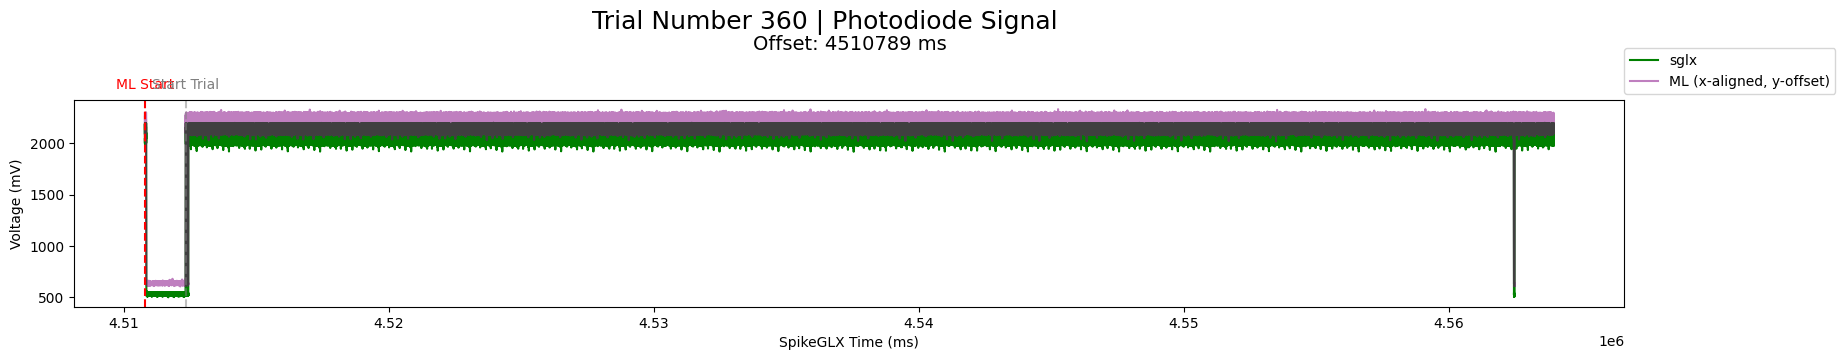

Trial 360:
  ML Cam Start           |  6      
  ML Cam End             |  53182  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  4510788.56
  SpikeGLX Trial End     |  4563973.56
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.944
  Trial 361 | Epoch start 4563973.651795852 | Epoch end 4617146.651795852


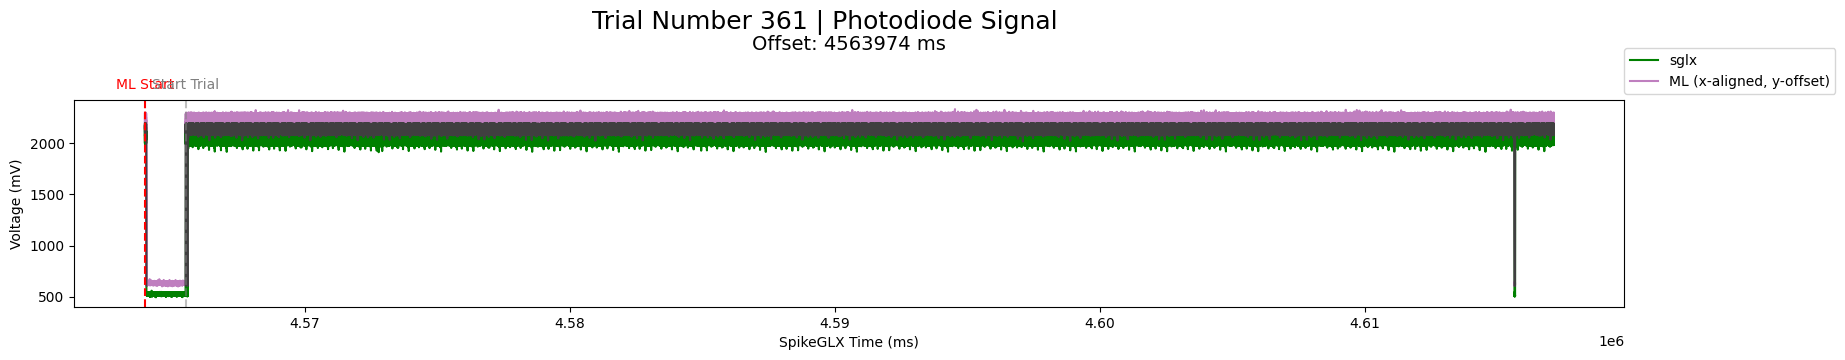

Trial 361:
  ML Cam Start           |  5      
  ML Cam End             |  53172  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  4563973.65
  SpikeGLX Trial End     |  4617146.65
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.941
  Trial 362 | Epoch start 4617148.240904732 | Epoch end 4670334.240904732


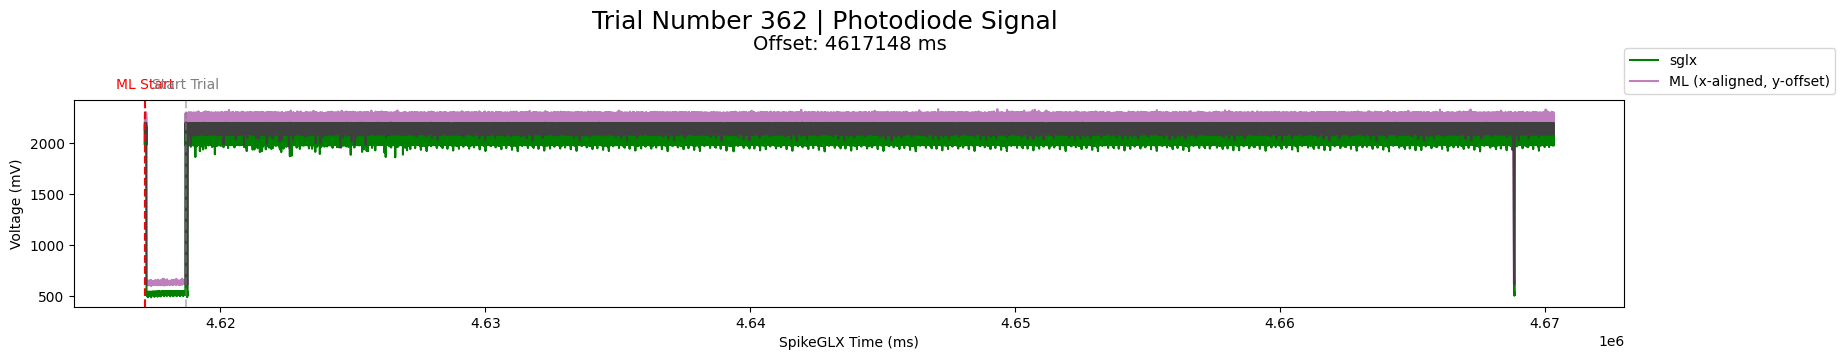

Trial 362:
  ML Cam Start           |  7      
  ML Cam End             |  53182  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  4617148.24
  SpikeGLX Trial End     |  4670334.24
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.944
Trial 363 | Correlation: 0.99 | SGLX High Time: 2674 | ML High Time: 1536
  Trial 363 | Epoch start 4670334.830055511 | Epoch end 4681033.830055511
Trial 364 | Correlation: 0.995 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 364 | Epoch start 4681033.848017233 | Epoch end 4687715.848017233
Trial 365 | Correlation: 0.994 | SGLX High Time: 2709 | ML High Time: 1555
  Trial 365 | Epoch start 4687714.859216284 | Epoch end 4699569.859216284
Trial 366 | Correlation: 0.993 | SGLX High Time: 2711 | ML High Time: 1554
  Trial 366 | Epoch start 4699570.879085297 | Epoch end 4705739.879085297
Trial 367 | Correlation: 0.996 | SGLX High Time: 5378 | ML High Time: 2889
  Trial 367 | Epoch start 4

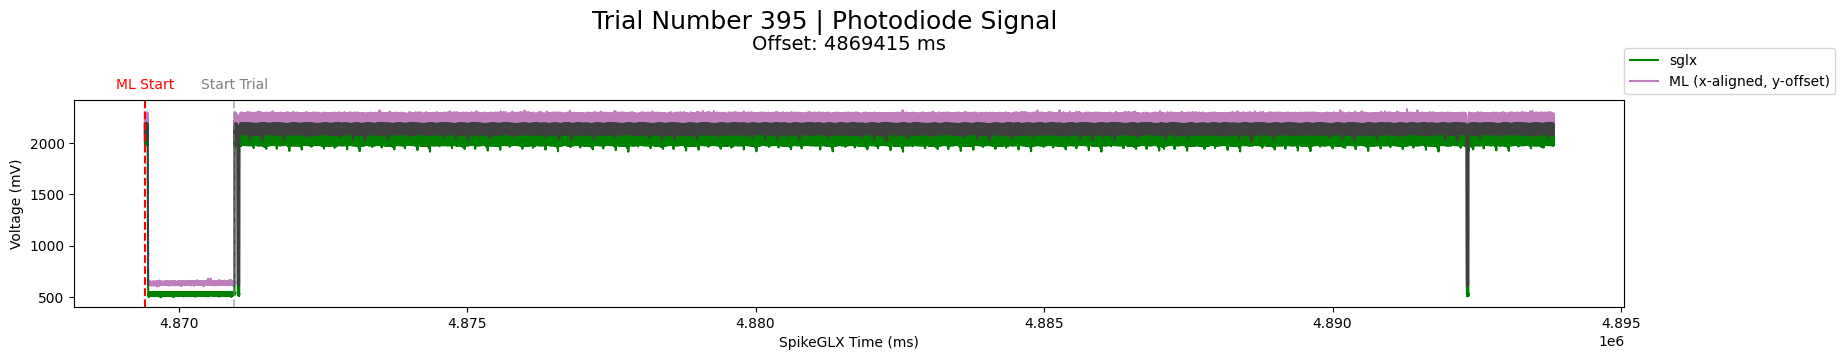

Trial 395:
  ML Cam Start           |  9      
  ML Cam End             |  24417  
  ML Cam Num Frames      |  2930   
  --------------------------------------
  SpikeGLX Trial Start   |  4869415.16
  SpikeGLX Trial End     |  4893839.16
  SpikeGLX Num Frames    |  2931   
  ML-SGLX Correlation: 0.975
Trial 396 | Correlation: 0.998 | SGLX High Time: 2676 | ML High Time: 1537
  Trial 396 | Epoch start 4893839.704651357 | Epoch end 4897929.704651357
Trial 397 | Correlation: 0.991 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 397 | Epoch start 4897930.211535539 | Epoch end 4903087.211535539
  Trial 398 | Epoch start 4903086.720149355 | Epoch end 4956259.720149355


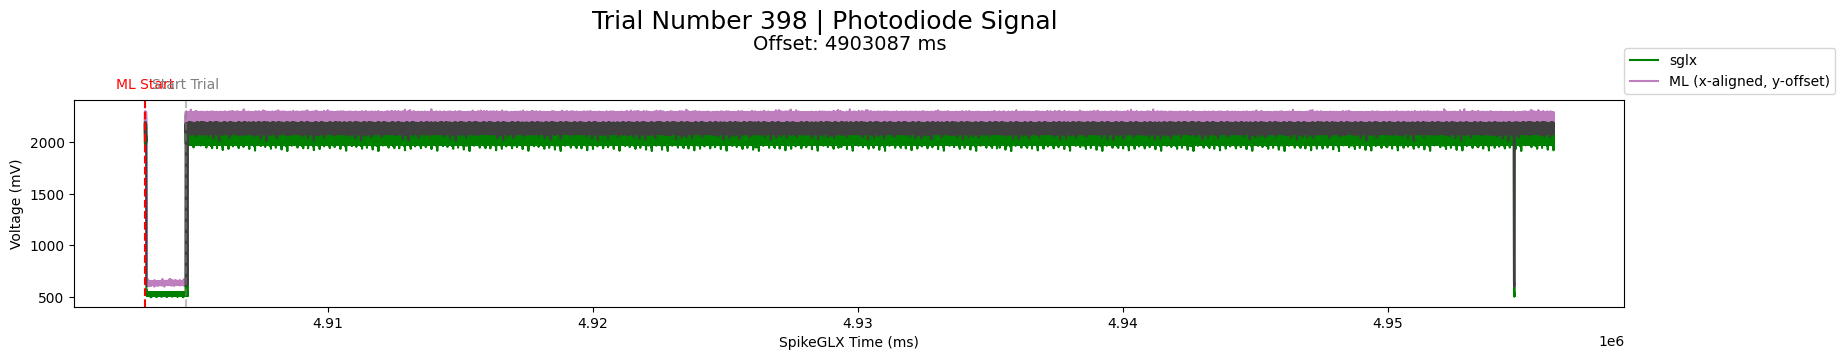

Trial 398:
  ML Cam Start           |  4      
  ML Cam End             |  53171  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  4903086.72
  SpikeGLX Trial End     |  4956259.72
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.944
  Trial 399 | Epoch start 4956260.809267452 | Epoch end 5009419.809267452


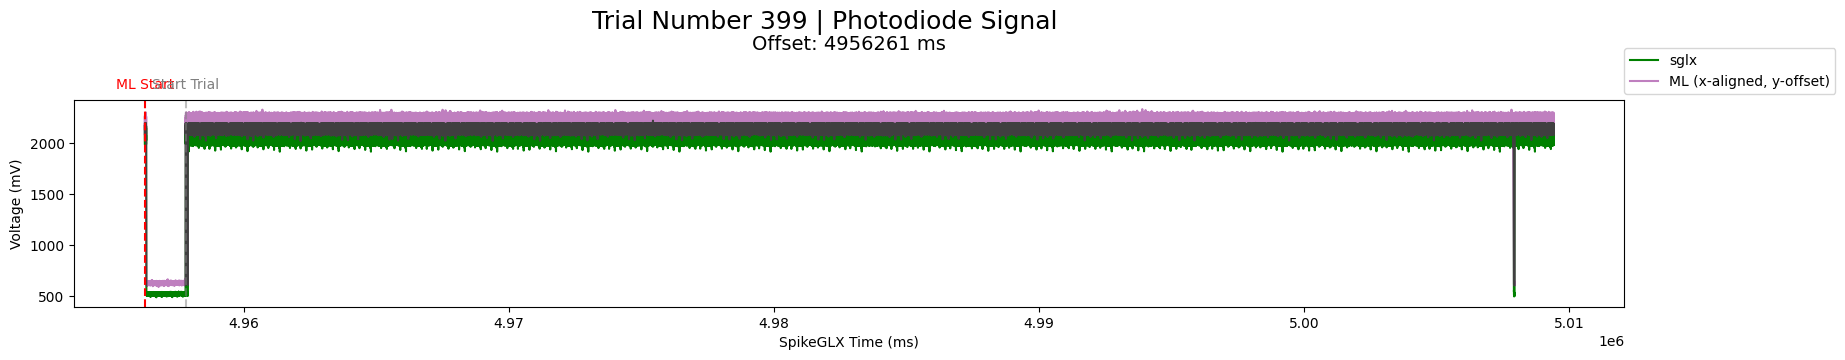

Trial 399:
  ML Cam Start           |  6      
  ML Cam End             |  53156  
  ML Cam Num Frames      |  6379   
  --------------------------------------
  SpikeGLX Trial Start   |  4956260.81
  SpikeGLX Trial End     |  5009419.81
  SpikeGLX Num Frames    |  6379   
  ML-SGLX Correlation: 0.945
  Trial 400 | Epoch start 5009420.398362923 | Epoch end 5062591.398362923


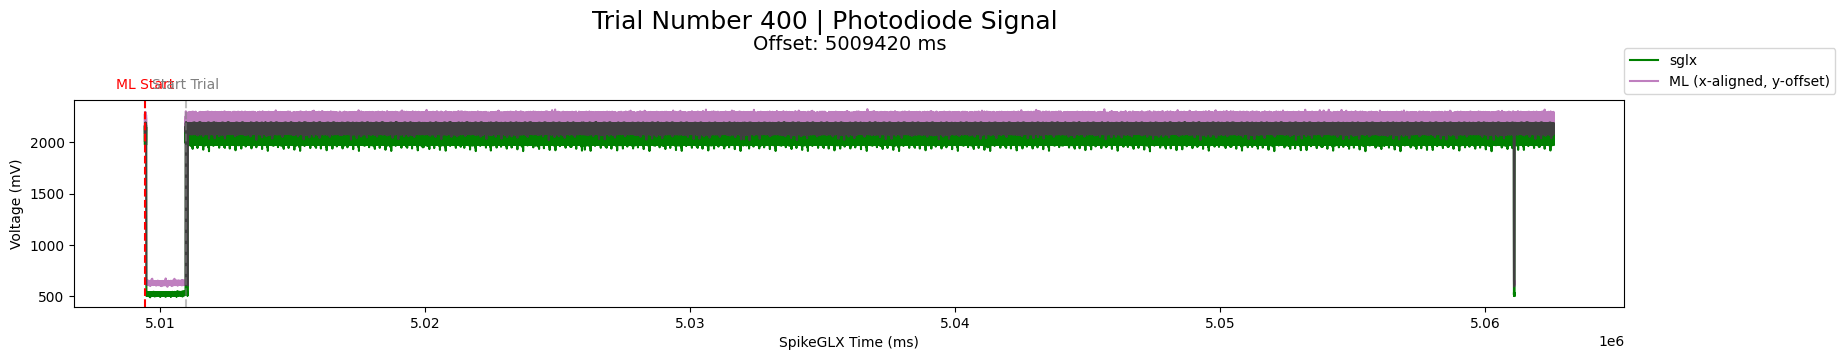

Trial 400:
  ML Cam Start           |  6      
  ML Cam End             |  53164  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  5009420.4
  SpikeGLX Trial End     |  5062591.4
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.944
  Trial 401 | Epoch start 5062591.487477669 | Epoch end 5108503.487477669


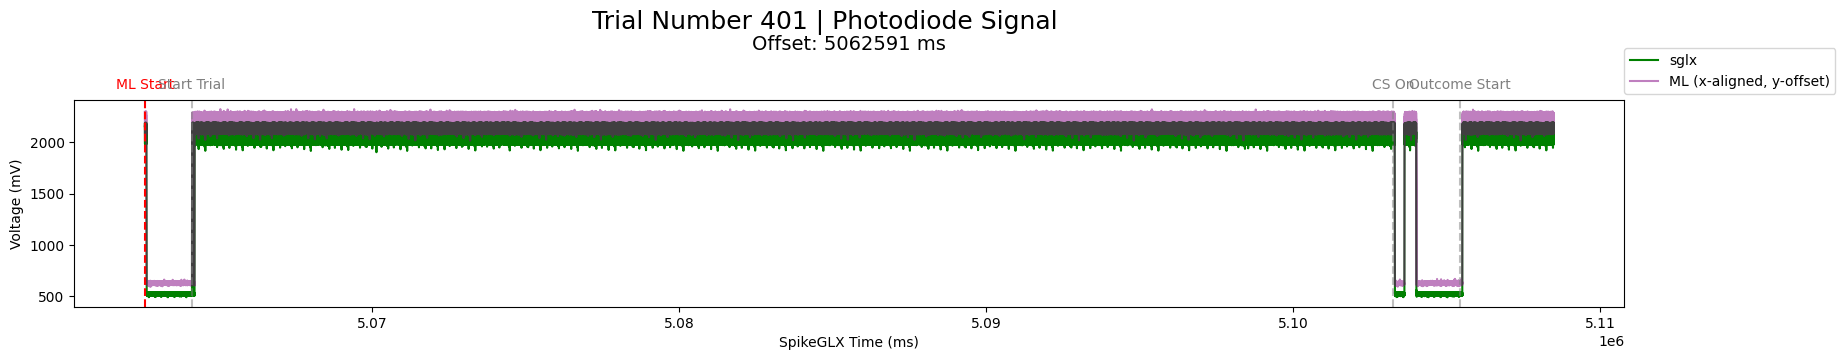

Trial 401:
  ML Cam Start           |  1      
  ML Cam End             |  45910  
  ML Cam Num Frames      |  5510   
  --------------------------------------
  SpikeGLX Trial Start   |  5062591.49
  SpikeGLX Trial End     |  5108503.49
  SpikeGLX Num Frames    |  5510   
  ML-SGLX Correlation: 0.976
Trial 402 | Correlation: 0.998 | SGLX High Time: 5469 | ML High Time: 2933
  Trial 402 | Epoch start 5108504.5667693615 | Epoch end 5113394.5667693615
Trial 403 | Correlation: 0.993 | SGLX High Time: 2673 | ML High Time: 1536
  Trial 403 | Epoch start 5113394.572623639 | Epoch end 5119837.572623639
Trial 404 | Correlation: 0.999 | SGLX High Time: 5303 | ML High Time: 2851
  Trial 404 | Epoch start 5119837.585626069 | Epoch end 5124286.585626069
Trial 405 | Correlation: 0.996 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 405 | Epoch start 5124286.59090883 | Epoch end 5129992.59090883
Trial 406 | Correlation: 0.997 | SGLX High Time: 2751 | ML High Time: 1575
  Trial 406 | Epoch start 

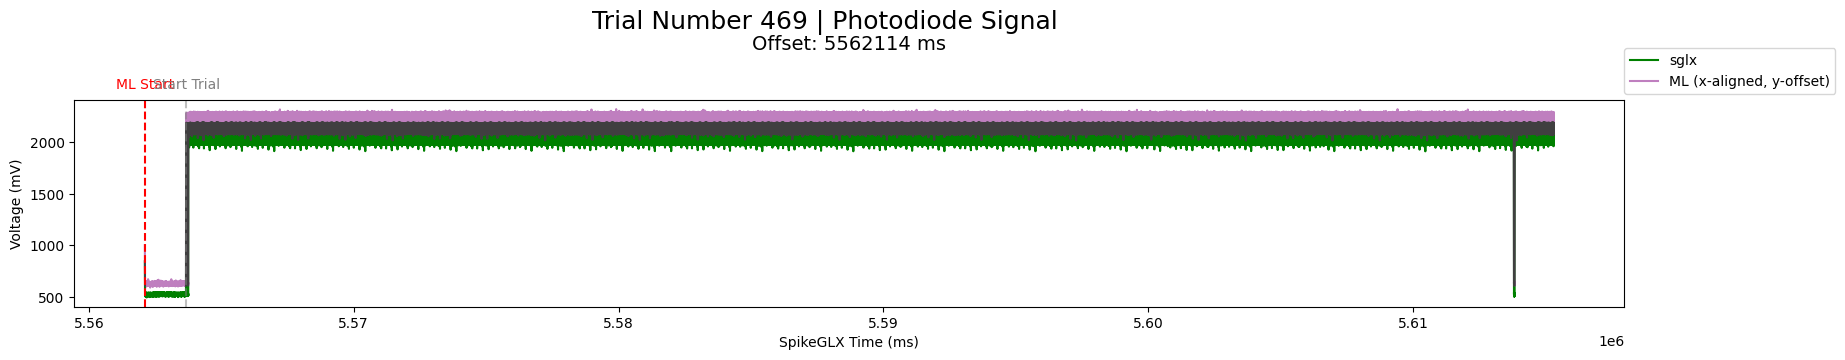

Trial 469:
  ML Cam Start           |  2      
  ML Cam End             |  53202  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  5562113.82
  SpikeGLX Trial End     |  5615323.82
  SpikeGLX Num Frames    |  6385   
  ML-SGLX Correlation: 0.944
Trial 470 | Correlation: 0.988 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 470 | Epoch start 5615323.913858891 | Epoch end 5628352.913858891
Trial 471 | Correlation: 0.997 | SGLX High Time: 5385 | ML High Time: 2892
  Trial 471 | Epoch start 5628352.937966516 | Epoch end 5633218.937966516
Trial 472 | Correlation: 0.994 | SGLX High Time: 2674 | ML High Time: 1536
  Trial 472 | Epoch start 5633219.443850123 | Epoch end 5637325.443850123
Trial 473 | Correlation: 0.992 | SGLX High Time: 2674 | ML High Time: 1537
  Trial 473 | Epoch start 5637324.95073263 | Epoch end 5648358.95073263
Trial 474 | Correlation: 0.993 | SGLX High Time: 2711 | ML High Time: 1554
  Trial 474 | Epoch start 56

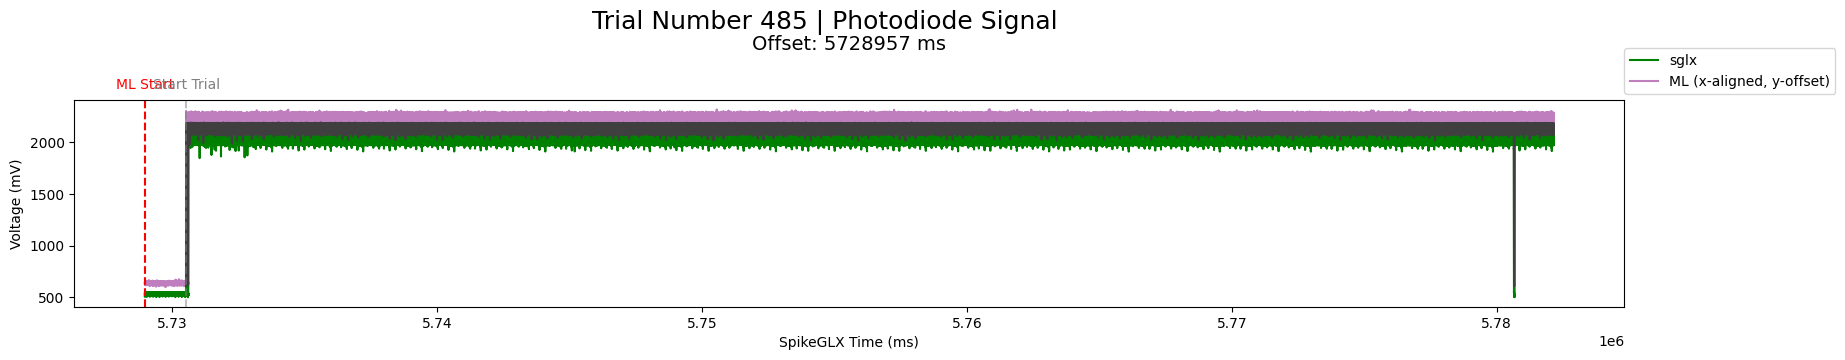

Trial 485:
  ML Cam Start           |  2      
  ML Cam End             |  53202  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  5728957.1
  SpikeGLX Trial End     |  5782162.1
  SpikeGLX Num Frames    |  6385   
  ML-SGLX Correlation: 0.944
  Trial 486 | Epoch start 5782162.693480686 | Epoch end 5835326.693480686


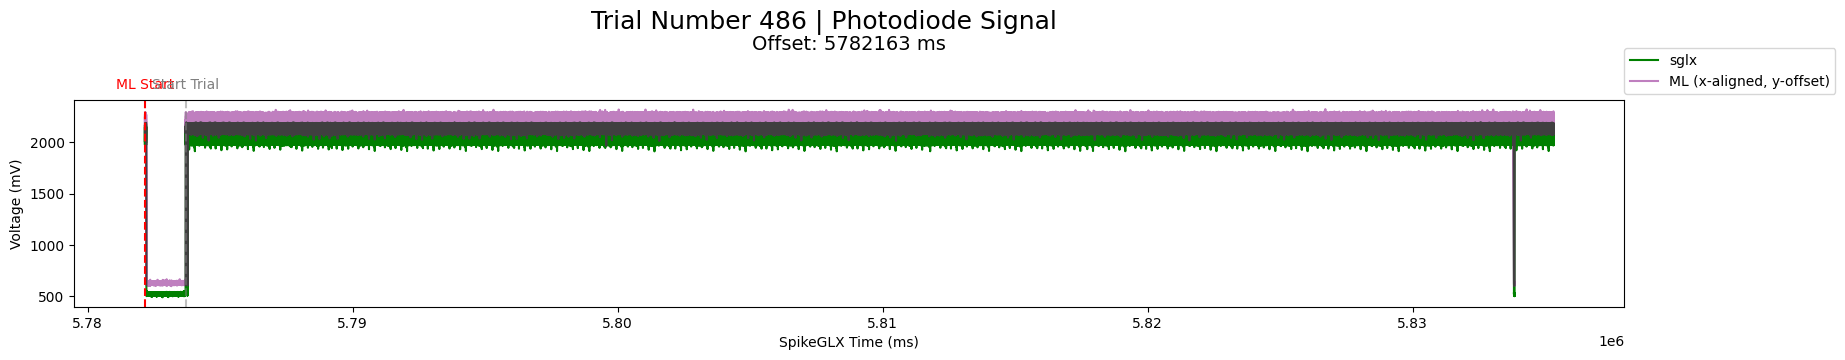

Trial 486:
  ML Cam Start           |  5      
  ML Cam End             |  53155  
  ML Cam Num Frames      |  6379   
  --------------------------------------
  SpikeGLX Trial Start   |  5782162.69
  SpikeGLX Trial End     |  5835326.69
  SpikeGLX Num Frames    |  6379   
  ML-SGLX Correlation: 0.943
Trial 487 | Correlation: 0.998 | SGLX High Time: 2676 | ML High Time: 1537
  Trial 487 | Epoch start 5835327.282584538 | Epoch end 5839567.282584538
  Trial 488 | Epoch start 5839567.28969079 | Epoch end 5892756.28969079


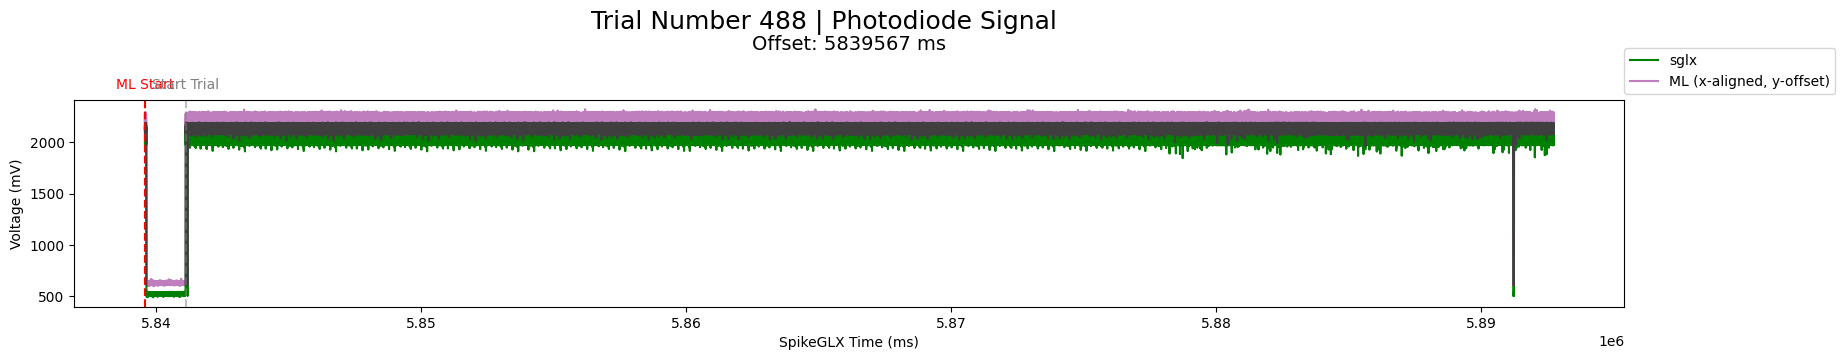

Trial 488:
  ML Cam Start           |  1      
  ML Cam End             |  53185  
  ML Cam Num Frames      |  6383   
  --------------------------------------
  SpikeGLX Trial Start   |  5839567.29
  SpikeGLX Trial End     |  5892756.29
  SpikeGLX Num Frames    |  6383   
  ML-SGLX Correlation: 0.941
  Trial 489 | Epoch start 5892756.8788365405 | Epoch end 5941305.8788365405


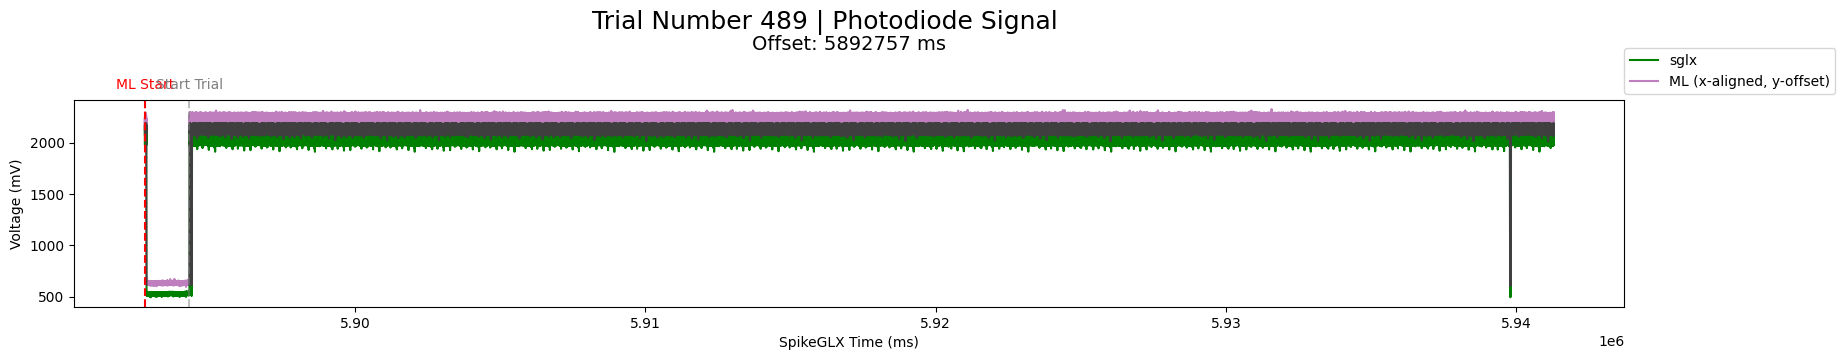

Trial 489:
  ML Cam Start           |  4      
  ML Cam End             |  48546  
  ML Cam Num Frames      |  5826   
  --------------------------------------
  SpikeGLX Trial Start   |  5892756.88
  SpikeGLX Trial End     |  5941305.88
  SpikeGLX Num Frames    |  5826   
  ML-SGLX Correlation: 0.947
Trial 490 | Correlation: 0.997 | SGLX High Time: 2675 | ML High Time: 1536
  Trial 490 | Epoch start 5941306.9602048015 | Epoch end 5947870.9602048015
Trial 491 | Correlation: 0.997 | SGLX High Time: 2750 | ML High Time: 1575
  Trial 491 | Epoch start 5947870.47127061 | Epoch end 5952056.47127061
Trial 492 | Correlation: 0.994 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 492 | Epoch start 5952056.478251161 | Epoch end 5958751.478251161
Trial 493 | Correlation: 0.998 | SGLX High Time: 2751 | ML High Time: 1575
  Trial 493 | Epoch start 5958751.4895071965 | Epoch end 5962931.4895071965
Trial 494 | Correlation: 0.998 | SGLX High Time: 2674 | ML High Time: 1536
  Trial 494 | Epoch star

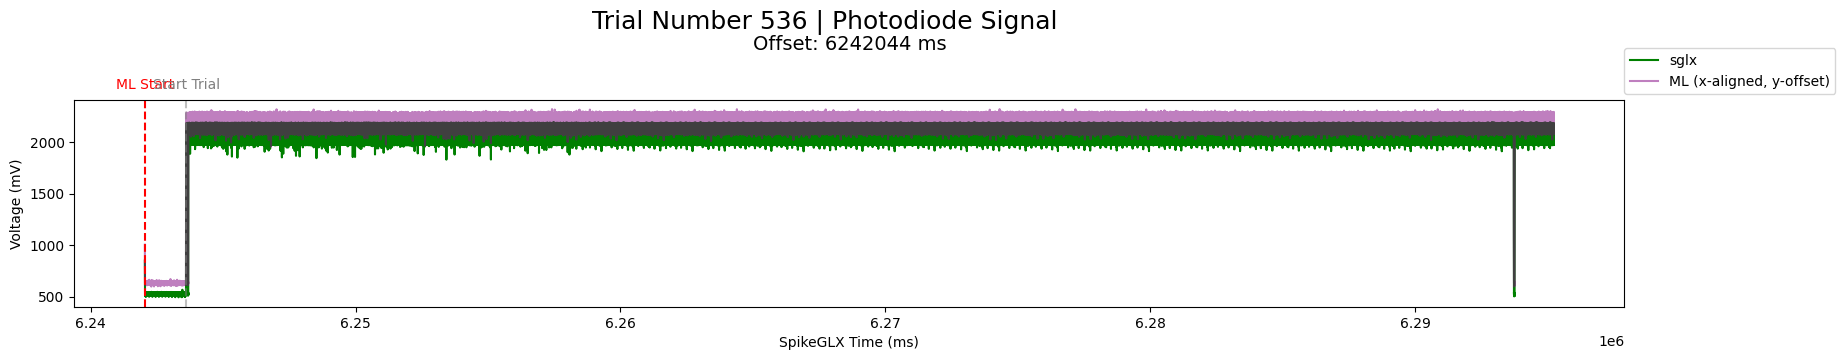

Trial 536:
  ML Cam Start           |  5      
  ML Cam End             |  53196  
  ML Cam Num Frames      |  6384   
  --------------------------------------
  SpikeGLX Trial Start   |  6242044.46
  SpikeGLX Trial End     |  6295247.46
  SpikeGLX Num Frames    |  6384   
  ML-SGLX Correlation: 0.946
  Trial 537 | Epoch start 6295248.053438566 | Epoch end 6348430.053438566


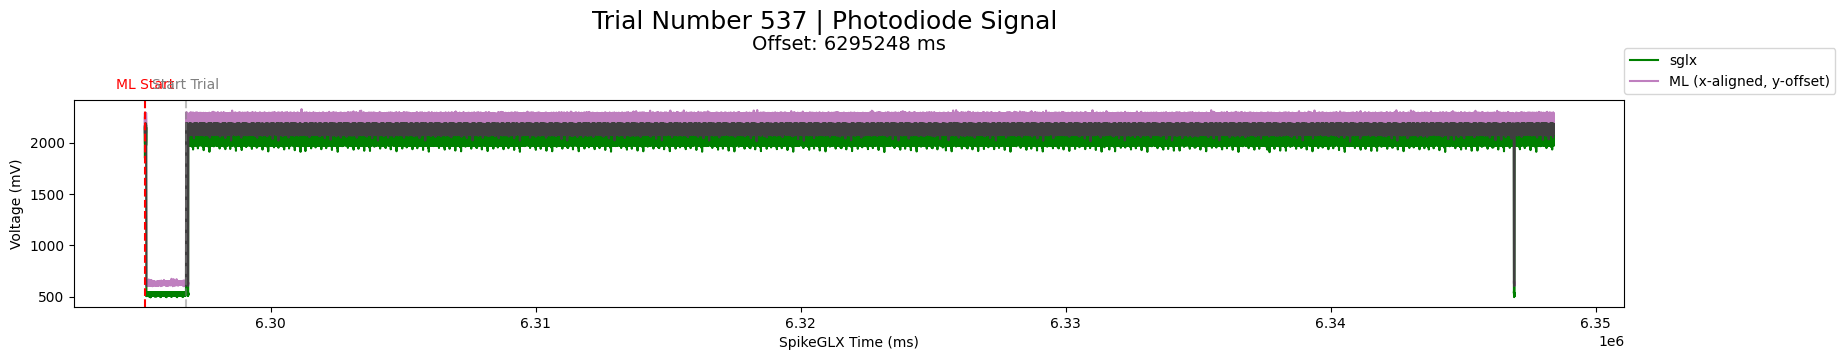

Trial 537:
  ML Cam Start           |  2      
  ML Cam End             |  53177  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  6295248.05
  SpikeGLX Trial End     |  6348430.05
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.945
  Trial 538 | Epoch start 6348430.642544093 | Epoch end 6365940.642544093


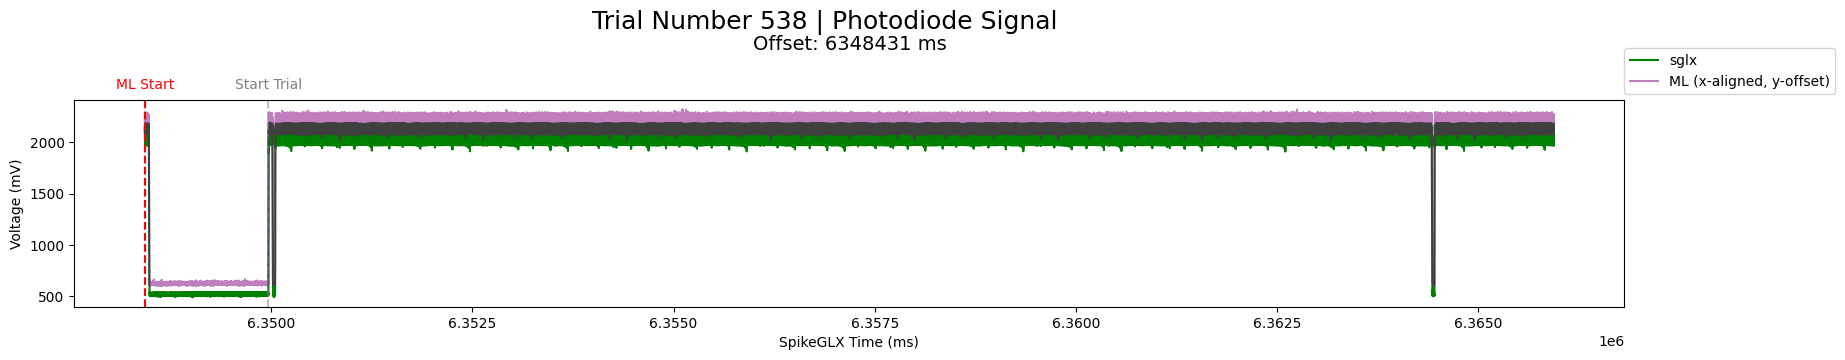

Trial 538:
  ML Cam Start           |  3      
  ML Cam End             |  17503  
  ML Cam Num Frames      |  2101   
  --------------------------------------
  SpikeGLX Trial Start   |  6348430.64
  SpikeGLX Trial End     |  6365940.64
  SpikeGLX Num Frames    |  2101   
  ML-SGLX Correlation: 0.979
Trial 539 | Correlation: 0.995 | SGLX High Time: 2674 | ML High Time: 1537
  Trial 539 | Epoch start 6365940.17189174 | Epoch end 6372467.17189174
Trial 540 | Correlation: 0.996 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 540 | Epoch start 6372467.68286034 | Epoch end 6377848.68286034
Trial 541 | Correlation: 0.995 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 541 | Epoch start 6377848.691878911 | Epoch end 6385422.691878911
Trial 542 | Correlation: 0.997 | SGLX High Time: 5385 | ML High Time: 2892
  Trial 542 | Epoch start 6385422.706815449 | Epoch end 6392919.706815449
Trial 543 | Correlation: 0.997 | SGLX High Time: 5386 | ML High Time: 2892
  Trial 543 | Epoch start 6392

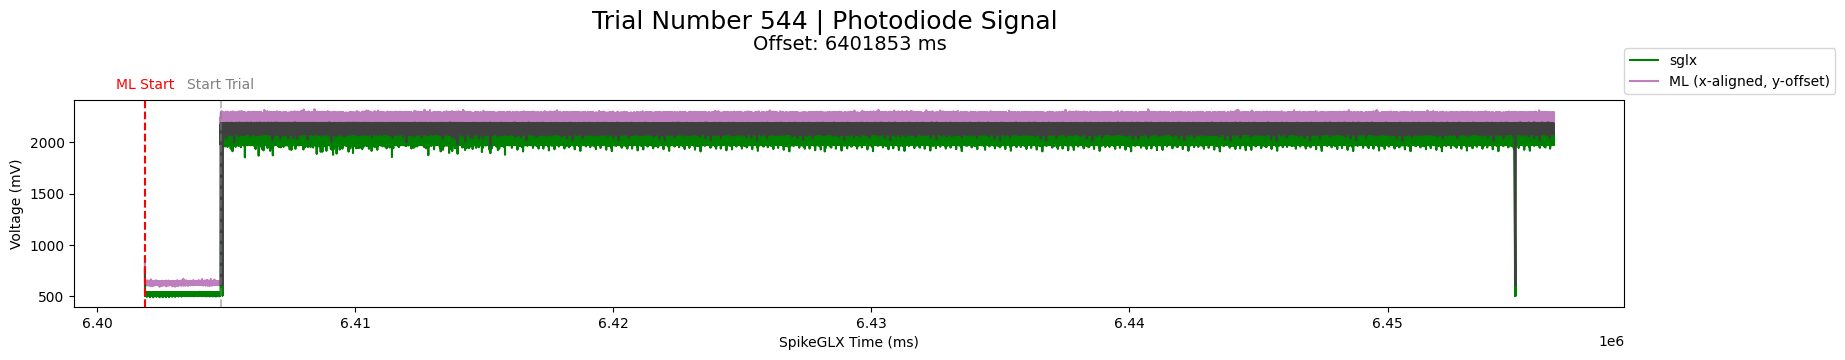

Trial 544:
  ML Cam Start           |  6      
  ML Cam End             |  54589  
  ML Cam Num Frames      |  6551   
  --------------------------------------
  SpikeGLX Trial Start   |  6401853.23
  SpikeGLX Trial End     |  6456445.23
  SpikeGLX Num Frames    |  6551   
  ML-SGLX Correlation: 0.968
Trial 545 | Correlation: 0.996 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 545 | Epoch start 6456445.323578374 | Epoch end 6460735.323578374
Trial 546 | Correlation: 0.992 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 546 | Epoch start 6460735.830797756 | Epoch end 6468411.830797756
Trial 547 | Correlation: 0.994 | SGLX High Time: 2674 | ML High Time: 1537
  Trial 547 | Epoch start 6468411.343633424 | Epoch end 6480567.343633424
Trial 548 | Correlation: 0.993 | SGLX High Time: 2711 | ML High Time: 1554
  Trial 548 | Epoch start 6480568.364037082 | Epoch end 6491711.364037082
Trial 549 | Correlation: 0.993 | SGLX High Time: 2709 | ML High Time: 1555
  Trial 549 | Epoch start 

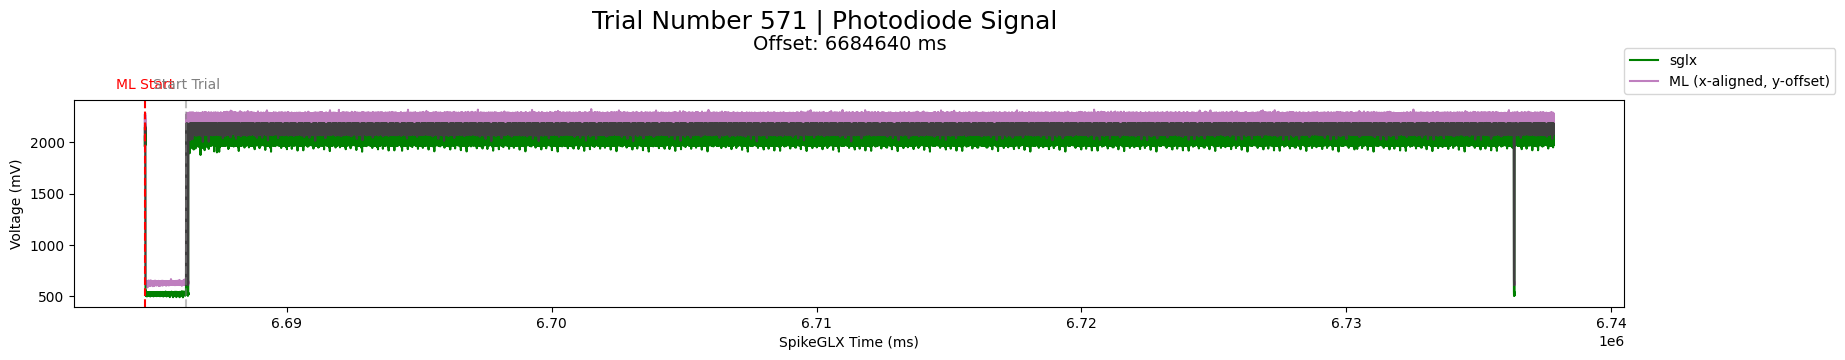

Trial 571:
  ML Cam Start           |  6      
  ML Cam End             |  53197  
  ML Cam Num Frames      |  6384   
  --------------------------------------
  SpikeGLX Trial Start   |  6684640.21
  SpikeGLX Trial End     |  6737845.21
  SpikeGLX Num Frames    |  6384   
  ML-SGLX Correlation: 0.943
Trial 572 | Correlation: 0.996 | SGLX High Time: 2709 | ML High Time: 1553
  Trial 572 | Epoch start 6737846.295233219 | Epoch end 6742036.295233219
  Trial 573 | Epoch start 6742035.802256509 | Epoch end 6793545.802256509


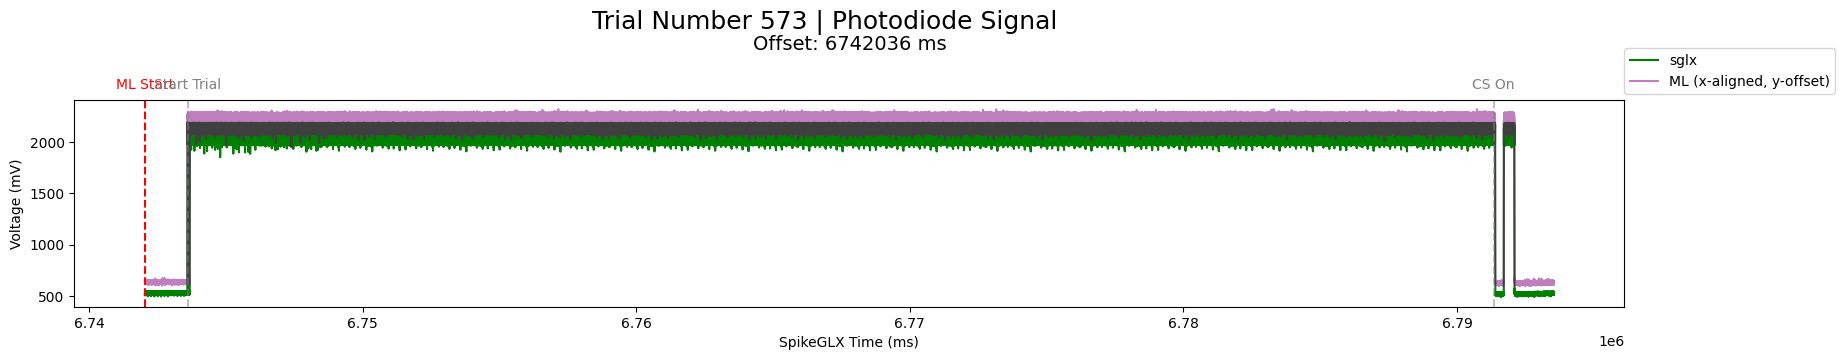

Trial 573:
  ML Cam Start           |  2      
  ML Cam End             |  51502  
  ML Cam Num Frames      |  6181   
  --------------------------------------
  SpikeGLX Trial Start   |  6742035.8
  SpikeGLX Trial End     |  6793545.8
  SpikeGLX Num Frames    |  6181   
  ML-SGLX Correlation: 0.973
Trial 574 | Correlation: 0.999 | SGLX High Time: 2712 | ML High Time: 1555
  Trial 574 | Epoch start 6793546.388589927 | Epoch end 6797671.388589927
Trial 575 | Correlation: 0.994 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 575 | Epoch start 6797671.895502601 | Epoch end 6810244.895502601
Trial 576 | Correlation: 0.997 | SGLX High Time: 2742 | ML High Time: 1571
  Trial 576 | Epoch start 6810244.416602638 | Epoch end 6816564.416602638
Trial 577 | Correlation: 0.994 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 577 | Epoch start 6816564.427166483 | Epoch end 6819648.427166483
Trial 578 | Correlation: 0.996 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 578 | Epoch start 68

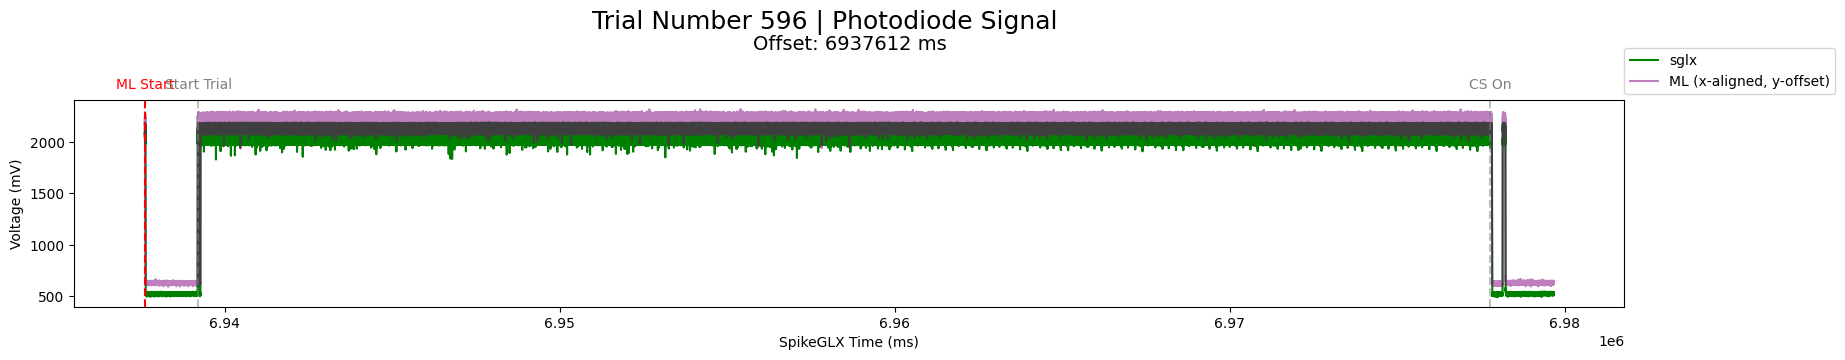

Trial 596:
  ML Cam Start           |  3      
  ML Cam End             |  42070  
  ML Cam Num Frames      |  5049   
  --------------------------------------
  SpikeGLX Trial Start   |  6937612.13
  SpikeGLX Trial End     |  6979685.13
  SpikeGLX Num Frames    |  5049   
  ML-SGLX Correlation: 0.978
  Trial 597 | Epoch start 6979685.200558576 | Epoch end 6999137.200558576


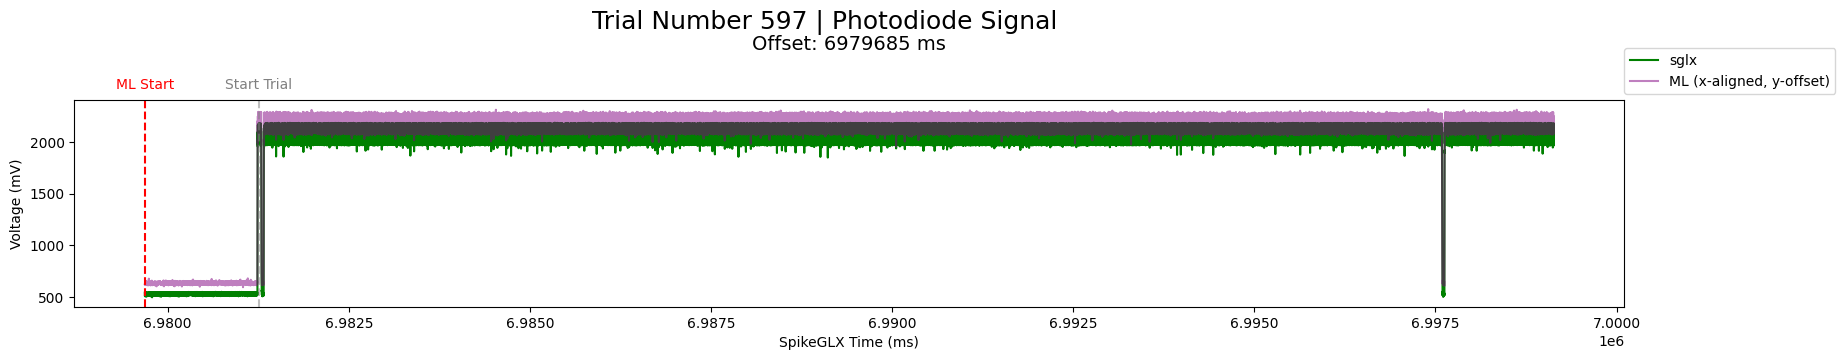

Trial 597:
  ML Cam Start           |  5      
  ML Cam End             |  19447  
  ML Cam Num Frames      |  2334   
  --------------------------------------
  SpikeGLX Trial Start   |  6979685.2
  SpikeGLX Trial End     |  6999137.2
  SpikeGLX Num Frames    |  2334   
  ML-SGLX Correlation: 0.977
Trial 598 | Correlation: 0.998 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 598 | Epoch start 6999137.2331300145 | Epoch end 7003619.2331300145
  Trial 599 | Epoch start 7003619.240672027 | Epoch end 7056822.240672027


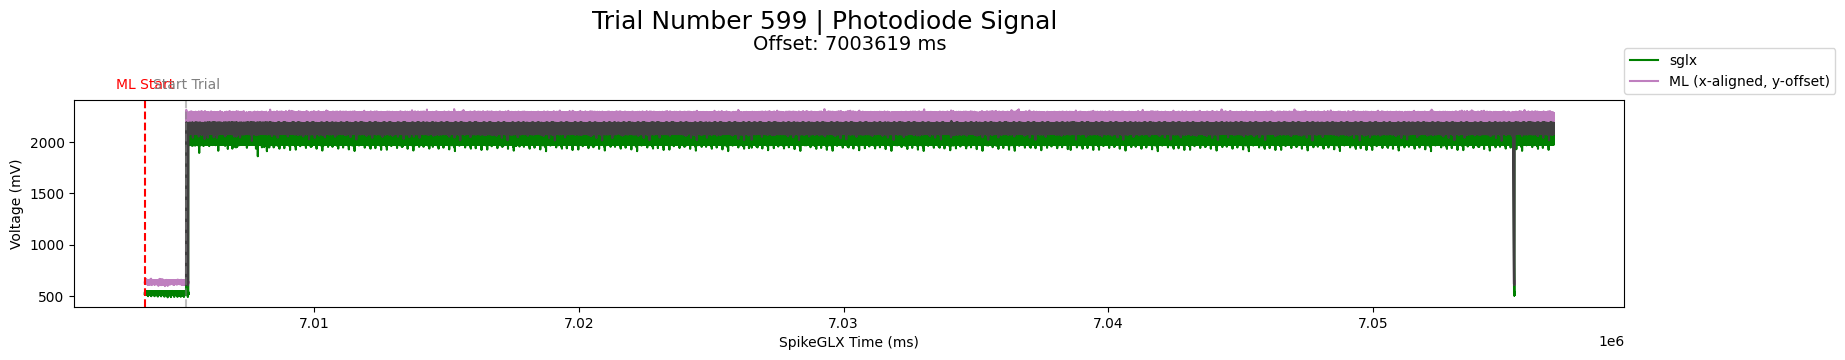

Trial 599:
  ML Cam Start           |  5      
  ML Cam End             |  53196  
  ML Cam Num Frames      |  6384   
  --------------------------------------
  SpikeGLX Trial Start   |  7003619.24
  SpikeGLX Trial End     |  7056822.24
  SpikeGLX Num Frames    |  6384   
  ML-SGLX Correlation: 0.943
  Trial 600 | Epoch start 7056823.829811075 | Epoch end 7101821.829811075


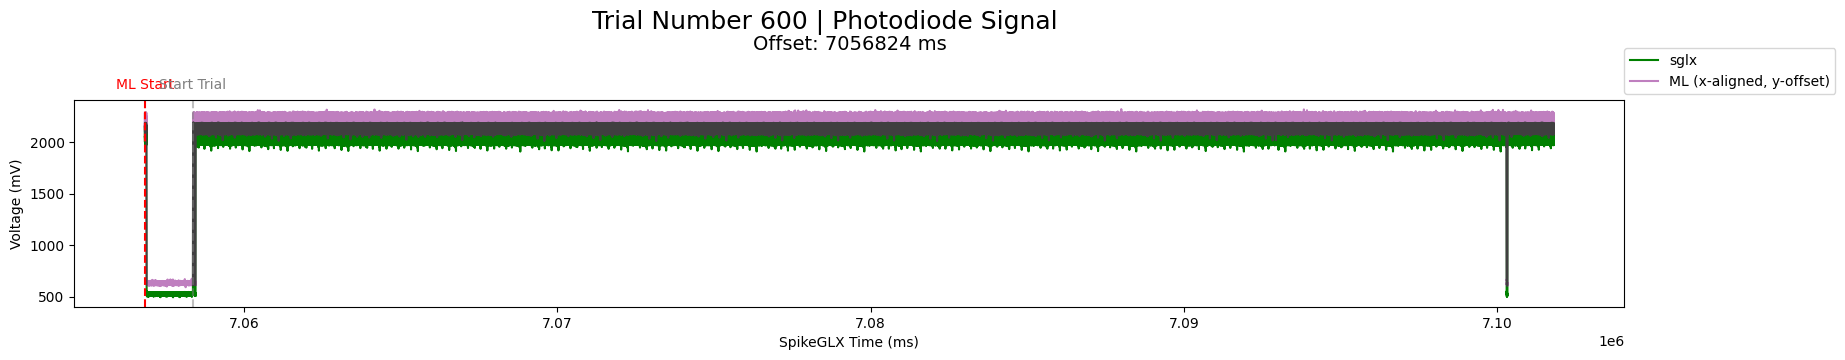

Trial 600:
  ML Cam Start           |  2      
  ML Cam End             |  44993  
  ML Cam Num Frames      |  5400   
  --------------------------------------
  SpikeGLX Trial Start   |  7056823.83
  SpikeGLX Trial End     |  7101821.83
  SpikeGLX Num Frames    |  5400   
  ML-SGLX Correlation: 0.949
Trial 601 | Correlation: 0.998 | SGLX High Time: 2674 | ML High Time: 1537
  Trial 601 | Epoch start 7101821.405228687 | Epoch end 7107764.405228687
Trial 602 | Correlation: 0.994 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 602 | Epoch start 7107764.915218501 | Epoch end 7115134.915218501
Trial 603 | Correlation: 0.999 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 603 | Epoch start 7115135.42757148 | Epoch end 7119834.42757148
Trial 604 | Correlation: 0.997 | SGLX High Time: 2707 | ML High Time: 1554
  Trial 604 | Epoch start 7119833.435445341 | Epoch end 7125951.435445341
Trial 605 | Correlation: 0.996 | SGLX High Time: 5346 | ML High Time: 2872
  Trial 605 | Epoch start 71

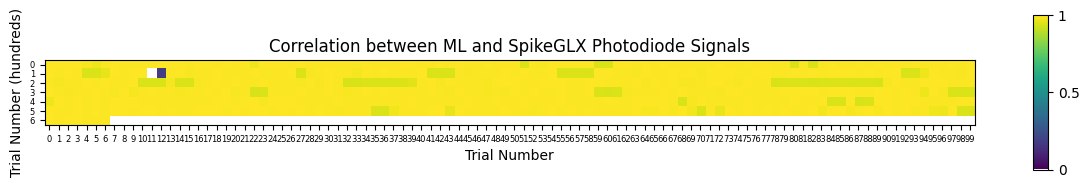

  Done.
Comparing ML and SpikeGLX photodiode signals...
Number of frames in ML Cam TTL: 858088
Number of frames in SpikeGLX Cam TTL: 858144
  Done.
Plotting ML and SpikeGLX photodiode signals...


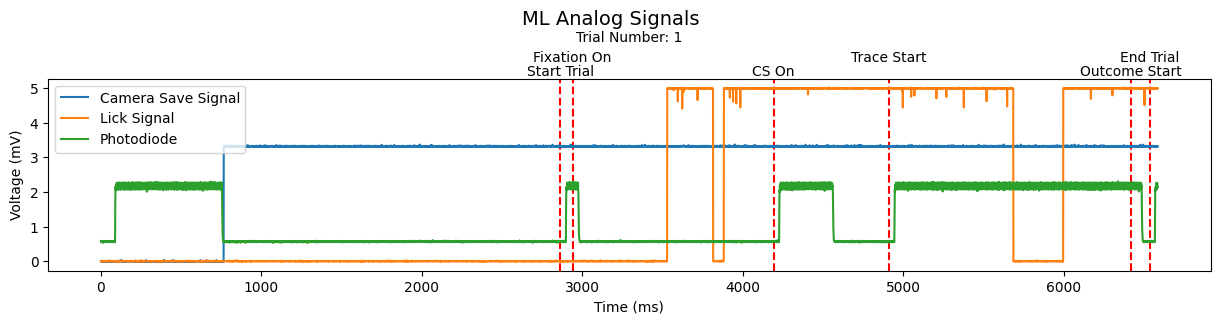

  Done.
Plotting first trial...


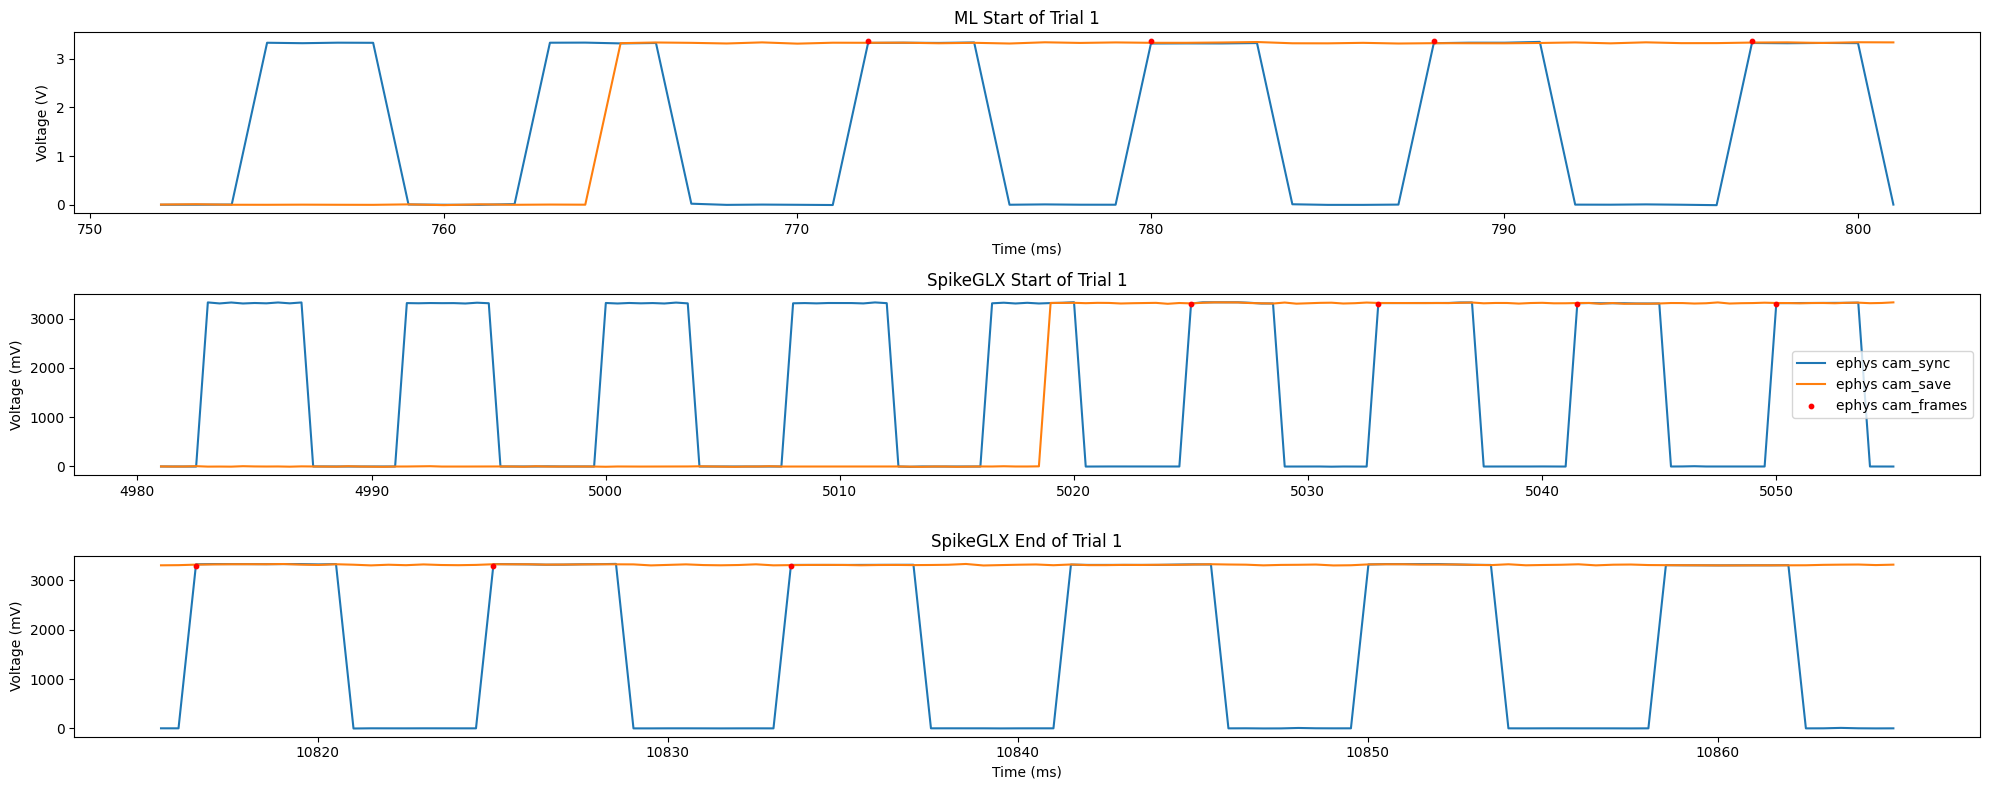

  Done.
Saving spikeglx_obj...
  Pickle file size: 580.5411 MB
  Pickle file path: _data\aragorn_231212\spikeglx_obj_aragorn_231212.pkl
Done. Saved spikeglx_obj.


In [9]:
from spike_glx.load_SGLX import load_sglx

# Load the spikeglx object
spikeglx_obj = load_sglx(session_obj.df, 
                         session_obj, 
                         file_container_obj, 
                         signal_dict, 
                         epochs)

### ML-SpikeGLX Session Correlation
To see just the correlation matrix for each trial in a session, run `plot_spikeglx_ml_corr` with the newly-generated `spikeglx_obj`.

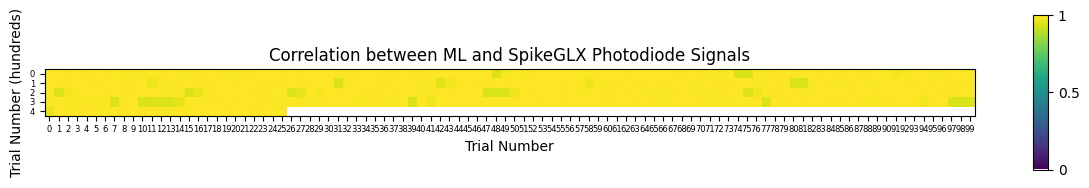

In [10]:
from spike_glx.read_SGLX import plot_spikeglx_ml_corr
plot_spikeglx_ml_corr(spikeglx_obj.ml_sglx_corr_matrix, 100)

***
## Process White Matter Videos

After generating a `SpikeGLX` object, you can segment all the White Matter videos by trial.

In [10]:
from video.wm_videos import parse_wm_videos

if session_obj.monkey == 'gandalf':
  epoch_start = 'start'
  epoch_end = 'end'
else:
  epoch_start = 'Trace Start'
  epoch_end = 'Outcome Start'

kwargs = {'spikeglx_obj': spikeglx_obj,       # 'spikeglx_obj': spikeglx_obj
          'session_obj': session_obj,         # 'session_obj': session_obj
          'trial_start': 0,                   # 'trial_start': 0 
          'trial_end': len(session_obj.df),   # 'trial_end': len(session_obj.df)
          'epoch_start': epoch_start,         # 'epoch_start': 'start'
          'epoch_end': epoch_end,             # 'epoch_end': 'end'   
          'thread_flag': False}               # 'thread_flag': False

parse_wm_videos(**kwargs)

Parsing Trials for Videos: 0 - 608
  Epoch Start: Trace Start
  Epoch End: Outcome Start
Video not found for trial 290 although frame epochs found
  Cam: e3v831b
  Frame Start: 475034
  Frame End: 475213
Video not found for trial 291 although frame epochs found
  Cam: e3v831b
  Frame Start: 475796
  Frame End: 475825
Video not found for trial 292 although frame epochs found
  Cam: e3v831b
  Frame Start: 476695
  Frame End: 476724
Video not found for trial 293 although frame epochs found
  Cam: e3v831b
  Frame Start: 477342
  Frame End: 477522
Video not found for trial 294 although frame epochs found
  Cam: e3v831b
  Frame Start: 478566
  Frame End: 478746
Video not found for trial 296 although frame epochs found
  Cam: e3v831b
  Frame Start: 479656
  Frame End: 479835
Video not found for trial 297 although frame epochs found
  Cam: e3v831b
  Frame Start: 480420
  Frame End: 480449
Video not found for trial 298 although frame epochs found
  Cam: e3v831b
  Frame Start: 481336
  Frame End

***
## DeepLabCut

In [15]:
import deeplabcut

camera_dict = {
  'e3v8360':'face_1', 
  'e3v83d6':'face_2',
  'e3v83ad':'body_1',
  'e3v831b':'body_2'
}

Loading DLC 2.3.7...


In [16]:
from dlc_primate.dlc_utils import dlc_config, dlc_downsample
video_dir = os.path.join(os.getcwd(), 'video', session_obj.monkey + '_' + session_obj.date)
dlc_video_path_dict = dlc_config.get_trial_video_list(video_dir, camera_dict)
# dlc_video_path_dict = spikeglx_obj.video_file_paths

Checking for video files...
  Video directory: c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205


  0%|          | 0/1124 [00:00<?, ?it/s]

  Camera: e3v831b | Number of videos: 281
  Camera: e3v8360 | Number of videos: 281
  Camera: e3v83ad | Number of videos: 281
  Camera: e3v83d6 | Number of videos: 281


In [17]:
# Custom modules
from dlc_primate.dlc_utils import dlc_config, dlc_downsample

# Initialize Project
config_path_dict, train_config_path_dict = \
  dlc_config.dlc_initialize_project(dlc_video_path_dict, session_obj, camera_dict)

Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: body_2
  Model: full_macaque
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Monkey-Emotions\\video\\gandalf_231205\\gandalf_231205_0_e3v831b.mp4']
Created "231205_gandalf\body_2-rh-2023-12-06\videos"
Created "231205_gandalf\body_2-rh-2023-12-06\labeled-data"
Created "231205_gandalf\body_2-rh-2023-12-06\training-datasets"
Created "231205_gandalf\body_2-rh-2023-12-06\dlc-models"
Copying the videos
231205_gandalf\body_2-rh-2023-12-06\videos\gandalf_231205_0_e3v831b.mp4
Generated "231205_gandalf\body_2-rh-2023-12-06\config.yaml"

A new project with name body_2-rh-2023-12-06 is created at 231205_gandalf and a configurable file (config.yaml) is stored there. Change the parameters in this file to adapt to your project's needs.
 Once you have changed the configuration file, use the function 'extract_frames' to select frames for labeling.
. [OPTIONAL] Use the functi

DLC_macaque_full_resnet50.tar.gz:   0%|          | 0.00/182M [00:00<?, ?B/s]

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_2-rh-2023-12-06\dlc-models\iteration-0\body_2Dec6-trainset95shuffle1\train. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


231205_gandalf\body_2-rh-2023-12-06\dlc-models\iteration-0\body_2Dec6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model 231205_gandalf\body_2-rh-2023-12-06\dlc-models\iteration-0\body_2Dec6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  231205_gandalf\body_2-rh-2023-12-06\videos\gandalf_231205_0_e3v831b.mp4
Loading  231205_gandalf\body_2-rh-2023-12-06\videos\gandalf_231205_0_e3v831b.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [05:41<00:00,  4.54it/s]


Saving results in 231205_gandalf\body_2-rh-2023-12-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: face_1
  Model: primate_face
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Monkey-Emotions\\video\\gandalf_231205\\gandalf_231205_0_e3v8360.mp4']
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\videos"
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\labeled-data"
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\training-datasets"
Created "C:\Users\rober\Desktop\Monkey-

(…)e_resnet_50_iteration-1_shuffle-1.tar.gz:   0%|          | 0.00/198M [00:00<?, ?B/s]

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\dlc-models\iteration-0\face_1Dec6-trainset95shuffle1\train. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\dlc-models\iteration-0\face_1Dec6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\dlc-models\iteration-0\face_1Dec6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\videos\gandalf_231205_0_e3v8360.mp4
Loading  C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\videos\gandalf_231205_0_e3v8360.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [05:54<00:00,  4.37it/s]


Saving results in C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: body_1
  Model: full_macaque
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Monkey-Emotions\\video\\gandalf_231205\\gandalf_231205_0_e3v83ad.mp4']
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\videos"
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\labeled-data"
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12

DLC_macaque_full_resnet50.tar.gz:   0%|          | 0.00/182M [00:00<?, ?B/s]

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\dlc-models\iteration-0\body_1Dec6-trainset95shuffle1\train. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\dlc-models\iteration-0\body_1Dec6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\dlc-models\iteration-0\body_1Dec6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\videos\gandalf_231205_0_e3v83ad.mp4
Loading  C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\videos\gandalf_231205_0_e3v83ad.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [05:39<00:00,  4.55it/s]


Saving results in C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: face_2
  Model: primate_face
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Monkey-Emotions\\video\\gandalf_231205\\gandalf_231205_0_e3v83d6.mp4']
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\videos"
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\labeled-data"
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\training-datasets"


(…)e_resnet_50_iteration-1_shuffle-1.tar.gz:   0%|          | 0.00/198M [00:00<?, ?B/s]

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\dlc-models\iteration-0\face_2Dec6-trainset95shuffle1\train. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\dlc-models\iteration-0\face_2Dec6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\dlc-models\iteration-0\face_2Dec6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\videos\gandalf_231205_0_e3v83d6.mp4
Loading  C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\videos\gandalf_231205_0_e3v83d6.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [06:01<00:00,  4.29it/s]


Saving results in C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.


In [18]:
# Run DLC
dlc_config.dlc_run(config_path_dict, dlc_video_path_dict, 
                   start_video=0, end_video=None, videotype='mp4')

Attempting to create a symbolic link of the video ...
Video 231205_gandalf\body_2-rh-2023-12-06\videos\gandalf_231205_0_e3v831b.mp4 already exists. Skipping...
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_1_e3v831b.mp4 copied to 231205_gandalf\body_2-rh-2023-12-06\videos\gandalf_231205_1_e3v831b.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_2_e3v831b.mp4 copied to 231205_gandalf\body_2-rh-2023-12-06\videos\gandalf_231205_2_e3v831b.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_3_e3v831b.mp4 copied to 231205_gandalf\body_2-rh-2023-12-06\videos\gandalf_231205_3_e3v831b.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_0_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_0_e3v831b.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [05:32<00:00,  4.65it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_1_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_1_e3v831b.mp4
Duration of video [s]:  17.58 , recorded with  120.0 fps!
Overall # of frames:  2110  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2110/2110 [07:31<00:00,  4.68it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_2_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_2_e3v831b.mp4
Duration of video [s]:  10.42 , recorded with  120.0 fps!
Overall # of frames:  1250  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1250/1250 [04:38<00:00,  4.49it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_3_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_3_e3v831b.mp4
Duration of video [s]:  14.14 , recorded with  120.0 fps!
Overall # of frames:  1697  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1697/1697 [06:16<00:00,  4.51it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_4_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_4_e3v831b.mp4
Duration of video [s]:  18.91 , recorded with  120.0 fps!
Overall # of frames:  2269  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2269/2269 [08:21<00:00,  4.52it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_5_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_5_e3v831b.mp4
Duration of video [s]:  14.57 , recorded with  120.0 fps!
Overall # of frames:  1748  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1748/1748 [06:15<00:00,  4.65it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_6_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_6_e3v831b.mp4
Duration of video [s]:  13.63 , recorded with  120.0 fps!
Overall # of frames:  1636  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1636/1636 [05:55<00:00,  4.60it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_7_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_7_e3v831b.mp4
Duration of video [s]:  14.64 , recorded with  120.0 fps!
Overall # of frames:  1757  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1757/1757 [06:27<00:00,  4.53it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_8_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_8_e3v831b.mp4
Duration of video [s]:  12.17 , recorded with  120.0 fps!
Overall # of frames:  1460  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1460/1460 [05:12<00:00,  4.68it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_9_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_9_e3v831b.mp4
Duration of video [s]:  14.92 , recorded with  120.0 fps!
Overall # of frames:  1790  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1790/1790 [06:33<00:00,  4.54it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_10_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_10_e3v831b.mp4
Duration of video [s]:  13.74 , recorded with  120.0 fps!
Overall # of frames:  1649  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1649/1649 [06:02<00:00,  4.55it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_11_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_11_e3v831b.mp4
Duration of video [s]:  13.25 , recorded with  120.0 fps!
Overall # of frames:  1590  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1590/1590 [05:48<00:00,  4.57it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_12_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_12_e3v831b.mp4
Duration of video [s]:  15.69 , recorded with  120.0 fps!
Overall # of frames:  1883  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1883/1883 [06:52<00:00,  4.56it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_13_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_13_e3v831b.mp4
Duration of video [s]:  10.85 , recorded with  120.0 fps!
Overall # of frames:  1302  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1302/1302 [04:43<00:00,  4.60it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_14_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_14_e3v831b.mp4
Duration of video [s]:  25.43 , recorded with  120.0 fps!
Overall # of frames:  3051  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 3051/3051 [11:05<00:00,  4.59it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_15_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_15_e3v831b.mp4
Duration of video [s]:  16.51 , recorded with  120.0 fps!
Overall # of frames:  1981  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1981/1981 [07:06<00:00,  4.65it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_16_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_16_e3v831b.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1418  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1418/1418 [05:06<00:00,  4.63it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_17_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_17_e3v831b.mp4
Duration of video [s]:  15.74 , recorded with  120.0 fps!
Overall # of frames:  1889  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1889/1889 [06:45<00:00,  4.66it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_18_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_18_e3v831b.mp4
Duration of video [s]:  18.37 , recorded with  120.0 fps!
Overall # of frames:  2204  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2204/2204 [07:55<00:00,  4.63it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_19_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_19_e3v831b.mp4
Duration of video [s]:  15.28 , recorded with  120.0 fps!
Overall # of frames:  1833  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1833/1833 [06:35<00:00,  4.63it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_20_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_20_e3v831b.mp4
Duration of video [s]:  12.32 , recorded with  120.0 fps!
Overall # of frames:  1478  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1478/1478 [05:18<00:00,  4.64it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_21_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_21_e3v831b.mp4
Duration of video [s]:  15.44 , recorded with  120.0 fps!
Overall # of frames:  1853  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1853/1853 [06:08<00:00,  5.03it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_22_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_22_e3v831b.mp4
Duration of video [s]:  12.72 , recorded with  120.0 fps!
Overall # of frames:  1526  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1526/1526 [04:56<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_23_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_23_e3v831b.mp4
Duration of video [s]:  17.68 , recorded with  120.0 fps!
Overall # of frames:  2121  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2121/2121 [06:54<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_24_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_24_e3v831b.mp4
Duration of video [s]:  18.22 , recorded with  120.0 fps!
Overall # of frames:  2186  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2186/2186 [07:05<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_25_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_25_e3v831b.mp4
Duration of video [s]:  13.04 , recorded with  120.0 fps!
Overall # of frames:  1565  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1565/1565 [05:06<00:00,  5.10it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_26_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_26_e3v831b.mp4
Duration of video [s]:  12.77 , recorded with  120.0 fps!
Overall # of frames:  1532  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1532/1532 [04:58<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_27_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_27_e3v831b.mp4
Duration of video [s]:  15.04 , recorded with  120.0 fps!
Overall # of frames:  1805  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1805/1805 [05:51<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_28_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_28_e3v831b.mp4
Duration of video [s]:  12.39 , recorded with  120.0 fps!
Overall # of frames:  1487  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1487/1487 [04:49<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_29_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_29_e3v831b.mp4
Duration of video [s]:  13.38 , recorded with  120.0 fps!
Overall # of frames:  1606  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1606/1606 [05:13<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_30_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_30_e3v831b.mp4
Duration of video [s]:  16.61 , recorded with  120.0 fps!
Overall # of frames:  1993  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1993/1993 [06:28<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_31_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_31_e3v831b.mp4
Duration of video [s]:  16.1 , recorded with  120.0 fps!
Overall # of frames:  1932  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1932/1932 [06:16<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_32_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_32_e3v831b.mp4
Duration of video [s]:  12.22 , recorded with  120.0 fps!
Overall # of frames:  1467  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1467/1467 [04:46<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_33_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_33_e3v831b.mp4
Duration of video [s]:  14.82 , recorded with  120.0 fps!
Overall # of frames:  1778  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1778/1778 [05:46<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_34_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_34_e3v831b.mp4
Duration of video [s]:  18.98 , recorded with  120.0 fps!
Overall # of frames:  2277  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2277/2277 [07:22<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_35_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_35_e3v831b.mp4
Duration of video [s]:  10.13 , recorded with  120.0 fps!
Overall # of frames:  1216  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1216/1216 [03:58<00:00,  5.11it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_36_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_36_e3v831b.mp4
Duration of video [s]:  12.55 , recorded with  120.0 fps!
Overall # of frames:  1506  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1506/1506 [04:54<00:00,  5.11it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_37_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_37_e3v831b.mp4
Duration of video [s]:  17.94 , recorded with  120.0 fps!
Overall # of frames:  2153  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2153/2153 [07:01<00:00,  5.11it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_38_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_38_e3v831b.mp4
Duration of video [s]:  17.37 , recorded with  120.0 fps!
Overall # of frames:  2084  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2084/2084 [06:45<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_39_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_39_e3v831b.mp4
Duration of video [s]:  14.71 , recorded with  120.0 fps!
Overall # of frames:  1765  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1765/1765 [05:44<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_40_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_40_e3v831b.mp4
Duration of video [s]:  11.6 , recorded with  120.0 fps!
Overall # of frames:  1392  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1392/1392 [04:30<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_41_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_41_e3v831b.mp4
Duration of video [s]:  45.07 , recorded with  120.0 fps!
Overall # of frames:  5408  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 5408/5408 [17:32<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_42_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_42_e3v831b.mp4
Duration of video [s]:  17.65 , recorded with  120.0 fps!
Overall # of frames:  2118  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2118/2118 [06:59<00:00,  5.05it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_43_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_43_e3v831b.mp4
Duration of video [s]:  15.41 , recorded with  120.0 fps!
Overall # of frames:  1849  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1849/1849 [06:01<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_44_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_44_e3v831b.mp4
Duration of video [s]:  15.68 , recorded with  120.0 fps!
Overall # of frames:  1882  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1882/1882 [06:08<00:00,  5.10it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_45_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_45_e3v831b.mp4
Duration of video [s]:  17.57 , recorded with  120.0 fps!
Overall # of frames:  2109  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2109/2109 [06:46<00:00,  5.19it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_46_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_46_e3v831b.mp4
Duration of video [s]:  16.04 , recorded with  120.0 fps!
Overall # of frames:  1925  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1925/1925 [06:13<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_47_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_47_e3v831b.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [06:23<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_48_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_48_e3v831b.mp4
Duration of video [s]:  15.71 , recorded with  120.0 fps!
Overall # of frames:  1885  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1885/1885 [06:06<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_49_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_49_e3v831b.mp4
Duration of video [s]:  15.36 , recorded with  120.0 fps!
Overall # of frames:  1843  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1843/1843 [05:58<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_50_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_50_e3v831b.mp4
Duration of video [s]:  16.27 , recorded with  120.0 fps!
Overall # of frames:  1953  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1953/1953 [06:19<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_51_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_51_e3v831b.mp4
Duration of video [s]:  14.18 , recorded with  120.0 fps!
Overall # of frames:  1702  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1702/1702 [05:30<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_52_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_52_e3v831b.mp4
Duration of video [s]:  12.0 , recorded with  120.0 fps!
Overall # of frames:  1440  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1440/1440 [04:39<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_53_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_53_e3v831b.mp4
Duration of video [s]:  15.91 , recorded with  120.0 fps!
Overall # of frames:  1909  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1909/1909 [06:10<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_54_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_54_e3v831b.mp4
Duration of video [s]:  14.89 , recorded with  120.0 fps!
Overall # of frames:  1787  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1787/1787 [05:49<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_55_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_55_e3v831b.mp4
Duration of video [s]:  10.08 , recorded with  120.0 fps!
Overall # of frames:  1210  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1210/1210 [03:55<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_56_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_56_e3v831b.mp4
Duration of video [s]:  16.57 , recorded with  120.0 fps!
Overall # of frames:  1988  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1988/1988 [06:25<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_57_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_57_e3v831b.mp4
Duration of video [s]:  16.41 , recorded with  120.0 fps!
Overall # of frames:  1969  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1969/1969 [06:22<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_58_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_58_e3v831b.mp4
Duration of video [s]:  18.24 , recorded with  120.0 fps!
Overall # of frames:  2189  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2189/2189 [07:04<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_59_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_59_e3v831b.mp4
Duration of video [s]:  10.48 , recorded with  120.0 fps!
Overall # of frames:  1258  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1258/1258 [04:04<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_60_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_60_e3v831b.mp4
Duration of video [s]:  20.92 , recorded with  120.0 fps!
Overall # of frames:  2510  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2510/2510 [08:07<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_61_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_61_e3v831b.mp4
Duration of video [s]:  14.88 , recorded with  120.0 fps!
Overall # of frames:  1786  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1786/1786 [05:47<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_62_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_62_e3v831b.mp4
Duration of video [s]:  19.56 , recorded with  120.0 fps!
Overall # of frames:  2347  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2347/2347 [07:35<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_63_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_63_e3v831b.mp4
Duration of video [s]:  14.64 , recorded with  120.0 fps!
Overall # of frames:  1757  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1757/1757 [05:41<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_64_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_64_e3v831b.mp4
Duration of video [s]:  19.32 , recorded with  120.0 fps!
Overall # of frames:  2318  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2318/2318 [07:31<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_65_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_65_e3v831b.mp4
Duration of video [s]:  17.73 , recorded with  120.0 fps!
Overall # of frames:  2127  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2127/2127 [06:52<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_66_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_66_e3v831b.mp4
Duration of video [s]:  11.98 , recorded with  120.0 fps!
Overall # of frames:  1438  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1438/1438 [04:39<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_67_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_67_e3v831b.mp4
Duration of video [s]:  16.17 , recorded with  120.0 fps!
Overall # of frames:  1940  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1940/1940 [06:16<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_68_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_68_e3v831b.mp4
Duration of video [s]:  11.1 , recorded with  120.0 fps!
Overall # of frames:  1332  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1332/1332 [04:19<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_69_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_69_e3v831b.mp4
Duration of video [s]:  16.93 , recorded with  120.0 fps!
Overall # of frames:  2031  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2031/2031 [06:34<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_70_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_70_e3v831b.mp4
Duration of video [s]:  15.73 , recorded with  120.0 fps!
Overall # of frames:  1888  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1888/1888 [06:03<00:00,  5.20it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_71_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_71_e3v831b.mp4
Duration of video [s]:  51.2 , recorded with  120.0 fps!
Overall # of frames:  6144  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6144/6144 [20:00<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_72_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_72_e3v831b.mp4
Duration of video [s]:  27.27 , recorded with  120.0 fps!
Overall # of frames:  3272  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 3272/3272 [10:47<00:00,  5.05it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_73_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_73_e3v831b.mp4
Duration of video [s]:  14.55 , recorded with  120.0 fps!
Overall # of frames:  1746  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1746/1746 [05:39<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_75_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_75_e3v831b.mp4
Duration of video [s]:  12.92 , recorded with  120.0 fps!
Overall # of frames:  1550  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1550/1550 [05:00<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_76_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_76_e3v831b.mp4
Duration of video [s]:  16.71 , recorded with  120.0 fps!
Overall # of frames:  2005  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2005/2005 [06:29<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_77_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_77_e3v831b.mp4
Duration of video [s]:  17.4 , recorded with  120.0 fps!
Overall # of frames:  2088  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2088/2088 [06:45<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_78_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_78_e3v831b.mp4
Duration of video [s]:  18.62 , recorded with  120.0 fps!
Overall # of frames:  2234  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2234/2234 [07:15<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_79_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_79_e3v831b.mp4
Duration of video [s]:  11.15 , recorded with  120.0 fps!
Overall # of frames:  1338  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1338/1338 [04:20<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_80_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_80_e3v831b.mp4
Duration of video [s]:  9.47 , recorded with  120.0 fps!
Overall # of frames:  1136  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1136/1136 [03:41<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_81_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_81_e3v831b.mp4
Duration of video [s]:  14.44 , recorded with  120.0 fps!
Overall # of frames:  1733  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1733/1733 [05:36<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_82_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_82_e3v831b.mp4
Duration of video [s]:  15.78 , recorded with  120.0 fps!
Overall # of frames:  1893  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1893/1893 [06:10<00:00,  5.11it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_83_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_83_e3v831b.mp4
Duration of video [s]:  14.49 , recorded with  120.0 fps!
Overall # of frames:  1739  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1739/1739 [05:38<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_84_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_84_e3v831b.mp4
Duration of video [s]:  15.07 , recorded with  120.0 fps!
Overall # of frames:  1809  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1809/1809 [05:53<00:00,  5.11it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_85_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_85_e3v831b.mp4
Duration of video [s]:  18.66 , recorded with  120.0 fps!
Overall # of frames:  2239  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2239/2239 [07:15<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_86_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_86_e3v831b.mp4
Duration of video [s]:  14.91 , recorded with  120.0 fps!
Overall # of frames:  1789  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1789/1789 [05:47<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_87_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_87_e3v831b.mp4
Duration of video [s]:  21.98 , recorded with  120.0 fps!
Overall # of frames:  2637  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2637/2637 [08:30<00:00,  5.17it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_88_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_88_e3v831b.mp4
Duration of video [s]:  14.98 , recorded with  120.0 fps!
Overall # of frames:  1798  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1798/1798 [05:48<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_89_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_89_e3v831b.mp4
Duration of video [s]:  14.57 , recorded with  120.0 fps!
Overall # of frames:  1748  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1748/1748 [05:39<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_90_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_90_e3v831b.mp4
Duration of video [s]:  11.75 , recorded with  120.0 fps!
Overall # of frames:  1410  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1410/1410 [04:34<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_91_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_91_e3v831b.mp4
Duration of video [s]:  50.73 , recorded with  120.0 fps!
Overall # of frames:  6088  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6088/6088 [19:44<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_92_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_92_e3v831b.mp4
Duration of video [s]:  46.36 , recorded with  120.0 fps!
Overall # of frames:  5563  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 5563/5563 [17:58<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_93_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_93_e3v831b.mp4
Duration of video [s]:  14.84 , recorded with  120.0 fps!
Overall # of frames:  1781  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1781/1781 [05:46<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_94_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_94_e3v831b.mp4
Duration of video [s]:  13.83 , recorded with  120.0 fps!
Overall # of frames:  1660  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1660/1660 [05:23<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_95_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_95_e3v831b.mp4
Duration of video [s]:  14.85 , recorded with  120.0 fps!
Overall # of frames:  1782  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1782/1782 [05:47<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_96_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_96_e3v831b.mp4
Duration of video [s]:  15.21 , recorded with  120.0 fps!
Overall # of frames:  1825  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1825/1825 [05:56<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_97_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_97_e3v831b.mp4
Duration of video [s]:  17.49 , recorded with  120.0 fps!
Overall # of frames:  2099  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2099/2099 [06:50<00:00,  5.11it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_98_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_98_e3v831b.mp4
Duration of video [s]:  15.53 , recorded with  120.0 fps!
Overall # of frames:  1864  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1864/1864 [06:02<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_99_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_99_e3v831b.mp4
Duration of video [s]:  16.98 , recorded with  120.0 fps!
Overall # of frames:  2037  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2037/2037 [06:36<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_100_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_100_e3v831b.mp4
Duration of video [s]:  10.97 , recorded with  120.0 fps!
Overall # of frames:  1316  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1316/1316 [04:17<00:00,  5.10it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_101_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_101_e3v831b.mp4
Duration of video [s]:  18.77 , recorded with  120.0 fps!
Overall # of frames:  2253  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2253/2253 [07:24<00:00,  5.06it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_102_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_102_e3v831b.mp4
Duration of video [s]:  13.08 , recorded with  120.0 fps!
Overall # of frames:  1570  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1570/1570 [05:06<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_103_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_103_e3v831b.mp4
Duration of video [s]:  13.87 , recorded with  120.0 fps!
Overall # of frames:  1664  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1664/1664 [05:23<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_104_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_104_e3v831b.mp4
Duration of video [s]:  16.52 , recorded with  120.0 fps!
Overall # of frames:  1983  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1983/1983 [06:26<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_105_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_105_e3v831b.mp4
Duration of video [s]:  20.24 , recorded with  120.0 fps!
Overall # of frames:  2429  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2429/2429 [07:53<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_106_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_106_e3v831b.mp4
Duration of video [s]:  17.76 , recorded with  120.0 fps!
Overall # of frames:  2131  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2131/2131 [06:55<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_107_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_107_e3v831b.mp4
Duration of video [s]:  12.0 , recorded with  120.0 fps!
Overall # of frames:  1440  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1440/1440 [04:41<00:00,  5.11it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_108_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_108_e3v831b.mp4
Duration of video [s]:  16.04 , recorded with  120.0 fps!
Overall # of frames:  1925  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1925/1925 [06:15<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_109_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_109_e3v831b.mp4
Duration of video [s]:  15.6 , recorded with  120.0 fps!
Overall # of frames:  1872  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1872/1872 [06:03<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_110_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_110_e3v831b.mp4
Duration of video [s]:  21.24 , recorded with  120.0 fps!
Overall # of frames:  2549  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2549/2549 [08:17<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_111_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_111_e3v831b.mp4
Duration of video [s]:  51.55 , recorded with  120.0 fps!
Overall # of frames:  6186  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6186/6186 [20:06<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_112_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_112_e3v831b.mp4
Duration of video [s]:  18.05 , recorded with  120.0 fps!
Overall # of frames:  2166  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2166/2166 [07:02<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_113_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_113_e3v831b.mp4
Duration of video [s]:  15.09 , recorded with  120.0 fps!
Overall # of frames:  1811  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1811/1811 [05:50<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_114_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_114_e3v831b.mp4
Duration of video [s]:  51.2 , recorded with  120.0 fps!
Overall # of frames:  6144  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


 88%|████████▊ | 5384/6144 [17:25<02:34,  4.91it/s]

***
## Generate MonkeyLogic Behavior Trial Videos

In [56]:
from video.ml_videos import generate_ml_behavior_videos
trial_num_selected = 1
generate_ml_behavior_videos(session_obj.df, session_obj, trial_num_selected, epoch_start, epoch_end)

Generating video for trial 1
Generating frames for trial 1 from 0 to 12264


Trial 1 frame:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4


Trial 0 eye:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4


Trial 0 lick:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting image folder: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/trial_0


TypeError: 'recursive' is an invalid keyword argument for rmdir()